In [4]:
import numpy as np
import math
import random

## Simulating the Path of Vt

In [5]:
# =============================================================================
# FUNCTION 1: simulate_mtm_paths
# Simulates N paths of the Mark-to-Market value V_t = Q * (S_t - K)
# dV ~ N(0, Q^2 * sigma_ann^2 * dt) at each daily step
# =============================================================================
def simulate_mtm_paths(Q=1000, S0=100, K=100, sigma_ann=15,
                       paths=10000, steps=252, T=1.0, seed=0):
    """
    Args:
        Q         : position size
        S0        : initial asset price
        K         : strike price (set K=S0 so V0=0)
        sigma_ann : annual volatility in price units
        paths     : number of simulation paths (N)
        steps     : number of daily steps (252 trading days)
        T         : time horizon in years
        seed      : random seed for reproducibility

    Returns:
        V_paths : list of lists, shape [paths][steps+1]
                  V_paths[i][t] = MTM value of path i on day t
    """

    random.seed(seed)

    # time step size in years (1 trading day = 1/252 years)
    dt = T / steps

    # initial MTM value: V0 = Q * (S0 - K)
    V0 = Q * (S0 - K)

    # daily std dev of dV = Q * sigma_ann * sqrt(dt)
    std_dV = abs(Q) * sigma_ann * math.sqrt(dt)

    # allocate output: 2D list [paths][steps+1], all zeros
    V_paths = [[0.0] * (steps + 1) for _ in range(paths)]

    # loop over each path
    for i in range(paths):

        # set starting value
        V_paths[i][0] = V0

        # loop over each daily step
        for t in range(1, steps + 1):

            # draw daily increment: dV ~ N(0, std_dV^2)
            # random.gauss(mean, std) -- second arg is std dev
            dV = random.gauss(0.0, std_dV)

            # update MTM value
            V_paths[i][t] = V_paths[i][t - 1] + dV

    return V_paths


## Computing IM

In [6]:
# =============================================================================
# FUNCTION 2: compute_IM
# Computes Initial Margin as the one-sided 99% VaR of MTM change over MPOR
# Collects ALL (V[t+MPOR] - V[t]) deltas across all paths and all valid t
# Takes the left-tail quantile (1 - alpha) and flips sign
# =============================================================================
def compute_IM(V_paths, MPOR=10, alpha=0.99, IM_multiplier=1.0):
    """
    Args:
        V_paths      : 2D list [paths][steps+1] from simulate_mtm_paths
        MPOR         : margin period of risk in days
        alpha        : confidence level (0.99 = 99%)
        IM_multiplier: scale factor k, so IM = k * VaR

    Returns:
        IM : float, the initial margin value
    """

    N     = len(V_paths)          # number of paths
    steps = len(V_paths[0]) - 1   # number of daily steps (252)

    # number of valid MPOR windows per path
    # e.g. steps=252, MPOR=10 => windows start at t=0,1,...,242 => 243 windows
    n_windows = steps - MPOR + 1

    if n_windows < 1:
        raise ValueError("MPOR is too large relative to number of steps.")

    # collect all MPOR-window MTM changes into a flat list
    total_deltas = N * n_windows
    deltas = [0.0] * total_deltas

    k = 0  # flat index into deltas list
    for i in range(N):
        for t in range(n_windows):
            # delta = change in MTM over the MPOR window starting at day t
            deltas[k] = V_paths[i][t + MPOR] - V_paths[i][t]
            k += 1

    # sort deltas ascending to find the left tail quantile
    deltas.sort()

    # left-tail index for (1 - alpha) quantile
    # e.g. alpha=0.99 => we want the 1% quantile => index = floor(0.01 * (total-1))
    tail_prob = 1.0 - alpha
    idx       = int(math.floor(tail_prob * (total_deltas - 1)))
    q_left    = deltas[idx]

    # IM = multiplier * |left tail|  (if positive loss, else 0)
    IM = IM_multiplier * max(0.0, -q_left)
    print(f"Computed IM: {IM:.2f} (99% VaR = {-q_left:.2f})")
    return IM


## Simulating Default days (Exogenous) Paths

In [7]:
# =============================================================================
# FUNCTION 3: simulate_default_days
# For each path, simulates ALL days on which a default trigger fires.
# Daily default prob derived from annual PD via Poisson intensity.
#
# We record every trigger day (not just the first) so that:
#   - Daily VM case  : use first_default[i]         (first trigger)
#   - Weekly VM case : case function finds first trigger on a VM exchange day
#   - Any other VM frequency can be handled the same way in the case function
# =============================================================================
def simulate_default_days(paths=10000, steps=252, PD_annual=0.0293, seed=1):
    """
    Args:
        paths      : number of simulation paths
        steps      : number of trading days (252)
        PD_annual  : annual probability of default (e.g. 0.0293 = 2.93%)
        seed       : random seed

    Returns:
        default_triggers : list of lists, length = paths
                           default_triggers[i] = list of ALL days t where
                           the default draw fired on path i  (0-indexed days)
                           default_triggers[i] = [] if no trigger on that path

        first_default    : list of ints, length = paths
                           first_default[i] = first trigger day on path i
                           first_default[i] = -1 if no trigger at all
                           (convenience shortcut for the daily VM case)
    """

    random.seed(seed)

    # convert annual PD to daily default probability
    # intensity: lambda = -ln(1 - PD_annual)
    # daily prob: p_day = 1 - exp(-lambda / 252)
    lam   = -math.log(1.0 - PD_annual)
    p_day = 1.0 - math.exp(-lam / steps)

    # allocate outputs
    default_triggers = [[] for _ in range(paths)]   # all trigger days per path
    first_default    = [-1] * paths                 # convenience: first trigger day

    for i in range(paths):
        for t in range(steps):

            # draw uniform random number for this day
            u = random.uniform(0.0, 1.0)

            # default trigger fires if u < p_day
            if u < p_day:
                default_triggers[i].append(t)   # record this trigger day

        # set first_default from the trigger list (-1 if no triggers)
        if len(default_triggers[i]) > 0:
            first_default[i] = default_triggers[i][0]

    return default_triggers, first_default

## Case 1 Daily VM Code

In [8]:
# =============================================================================
# FUNCTION 4: run_case1
# Case 1: A has unlimited cash => default is exogenous only
#
# VM logic:
#   VMa[i][t] = max(-V[i][t], 0)  =>  A posts when it owes B (V < 0)
#   VMb[i][t] = max( V[i][t], 0)  =>  B posts when it owes A (V > 0)
#   IM is always held by B, posted by A at inception
#
# Loss to B on default at day t_d:
#   close-out at t_d + MPOR
#   exposure  = max(-V[t_d + MPOR], 0)   # A owes B at close-out
#   recovery  = IM + VMa[t_d]            # B seizes last posted collateral
#   loss_B    = max(exposure - recovery, 0)
# =============================================================================
def run_case1(Q=100, S0=100, K=100, sigma_ann=10,
              paths=10000, steps=252,
              PD_annual=0.0293, MPOR=10,
              alpha=0.99, IM_multiplier=1.0,
              seed_paths=0, seed_pd=1):
    """
    Returns:
        results : dict containing all raw arrays and summary statistics
    """

    # ------------------------------------------------------------------
    # STEP 1: Simulate MTM paths
    # ------------------------------------------------------------------
    V_paths = simulate_mtm_paths(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
                                 paths=paths, steps=steps, seed=seed_paths)

    # ------------------------------------------------------------------
    # STEP 2: Compute Initial Margin from simulated paths
    # NOTE: this is slow for 10000 paths -- acceptable for assignment
    # ------------------------------------------------------------------
    IM = compute_IM(V_paths, MPOR=MPOR, alpha=alpha,
                   IM_multiplier=IM_multiplier)
    print(IM)
    # ------------------------------------------------------------------
    # STEP 3: Simulate default days
    # ------------------------------------------------------------------
    # simulate_default_days now returns two outputs:
    #   default_triggers : all trigger days per path (used for weekly VM)
    #   first_default    : first trigger day per path (used for daily VM)
    default_triggers, default_day = simulate_default_days(paths=paths, steps=steps,
                                                          PD_annual=PD_annual, seed=seed_pd)

    # ------------------------------------------------------------------
    # STEP 4: Build VM arrays
    # VMa[i][t] = collateral A has posted on day t (A owes B when V < 0)
    # VMb[i][t] = collateral B has posted on day t (B owes A when V > 0)
    # ------------------------------------------------------------------
    VMa = [[0.0] * (steps + 1) for _ in range(paths)]
    VMb = [[0.0] * (steps + 1) for _ in range(paths)]

    for i in range(paths):
        for t in range(steps + 1):
            v = V_paths[i][t]
            if v < 0.0:
                VMa[i][t] = -v    # A posts |V| when it owes B
                VMb[i][t] = 0.0
            else:
                VMa[i][t] = 0.0
                VMb[i][t] = v     # B posts V when it owes A

    # ------------------------------------------------------------------
    # STEP 5: Compute loss to B for each path
    # ------------------------------------------------------------------

    # output arrays (simple lists)
    loss_B       = [0.0]   * paths   # loss to B on each path
    exposure_arr = [0.0]   * paths   # exposure at close-out
    recovery_arr = [0.0]   * paths   # recovery at close-out
    defaulted    = [False] * paths   # did A default on this path?

    for i in range(paths):

        t_d = default_day[i]

        # no default on this path => no loss
        if t_d == -1:
            continue

        defaulted[i] = True

        # close-out day = default day + MPOR
        # cap at final day if MPOR window goes beyond simulation horizon
        t_closeout = t_d + MPOR
        if t_closeout > steps:
            t_closeout = steps

        # MTM value at close-out
        V_closeout = V_paths[i][t_closeout]

        # last VM posted by A before default (on day t_d)
        VMa_last = VMa[i][t_d]

        # exposure: how much A owes B at close-out (zero if B owes A)
        exposure = max(-V_closeout, 0.0)

        # recovery: B seizes IM (always held) + last VMa posted
        recovery = IM + VMa_last

        # loss = shortfall after recovery
        loss = max(exposure - recovery, 0.0)

        exposure_arr[i] = exposure
        recovery_arr[i] = recovery
        loss_B[i]       = loss

    # ------------------------------------------------------------------
    # STEP 6: Compute summary statistics
    # ------------------------------------------------------------------

    # count defaults
    n_defaults = 0
    for i in range(paths):
        if defaulted[i]:
            n_defaults += 1

    default_rate = n_defaults / paths

    # expected loss (mean over all paths)
    total_loss = 0.0
    for i in range(paths):
        total_loss += loss_B[i]
    expected_loss = total_loss / paths

    # loss given default (mean over defaulted paths only)
    lgd_sum   = 0.0
    lgd_count = 0
    for i in range(paths):
        if defaulted[i]:
            lgd_sum   += loss_B[i]
            lgd_count += 1
    loss_given_default = lgd_sum / lgd_count if lgd_count > 0 else 0.0

    # count paths with positive loss
    n_positive_loss = 0
    for i in range(paths):
        if loss_B[i] > 0.0:
            n_positive_loss += 1
    pct_loss_positive = n_positive_loss / paths

    # 99% VaR: sort loss_B, take 99th percentile
    loss_sorted = sorted(loss_B)
    idx_var99   = int(math.floor(0.99 * (paths - 1)))
    var_99      = loss_sorted[idx_var99]

    # 99% CVaR: mean of losses above VaR threshold
    cvar_sum   = 0.0
    cvar_count = 0
    for i in range(paths):
        if loss_B[i] >= var_99:
            cvar_sum   += loss_B[i]
            cvar_count += 1
    cvar_99 = cvar_sum / cvar_count if cvar_count > 0 else 0.0

    # ------------------------------------------------------------------
    # STEP 7: Package all results
    # ------------------------------------------------------------------
    results = {
        # --- raw simulation arrays (needed for plotting paths, VM, etc.) ---
        "V_paths"       : V_paths,        # [N][253] full MTM paths
        "default_day"      : default_day,       # [N] first trigger day (-1 = none) -- daily VM
        "default_triggers" : default_triggers,  # [N][] all trigger days  -- weekly VM uses this
        "VMa"           : VMa,            # [N][253] A's posted collateral per day
        "VMb"           : VMb,            # [N][253] B's posted collateral per day

        # --- per-path loss decomposition ---
        "loss_B"        : loss_B,         # [N] loss to B
        "exposure"      : exposure_arr,   # [N] exposure at close-out
        "recovery"      : recovery_arr,   # [N] recovery at close-out
        "defaulted"     : defaulted,      # [N] bool: did A default?

        # --- scalar parameters (for labelling plots) ---
        "IM"            : IM,
        "PD_annual"     : PD_annual,
        "MPOR"          : MPOR,
        "alpha"         : alpha,
        "IM_multiplier" : IM_multiplier,
        "Q"             : Q,
        "sigma_ann"     : sigma_ann,

        # --- summary statistics (pre-computed for sweep plots) ---
        "default_rate"       : default_rate,
        "expected_loss"      : expected_loss,
        "VaR_99_loss"        : var_99,
        "CVaR_99_loss"       : cvar_99,
        "loss_given_default" : loss_given_default,
        "pct_loss_positive"  : pct_loss_positive,
        "n_defaults"         : n_defaults,
    }

    return results


# =============================================================================
# QUICK TEST
# =============================================================================
if __name__ == "__main__":

    print("Running Case 1 (unlimited cash, exogenous default only)...")
    print("NOTE: pure Python loops => will take ~1-2 min for 10000 paths\n")

    res = run_case1(paths=1000)   # use 1000 for quick test

    print(f"IM                          : {res['IM']:.4f}")
    print(f"Annual PD                   : {res['PD_annual']:.4%}")
    print(f"Simulated default rate      : {res['default_rate']:.4%}")
    print(f"Expected Loss to B          : {res['expected_loss']:.6f}")
    print(f"99% VaR of Loss to B        : {res['VaR_99_loss']:.6f}")
    print(f"99% CVaR of Loss to B       : {res['CVaR_99_loss']:.6f}")
    print(f"Loss Given Default          : {res['loss_given_default']:.4f}")
    print(f"% paths with positive loss  : {res['pct_loss_positive']:.4%}")

Running Case 1 (unlimited cash, exogenous default only)...
NOTE: pure Python loops => will take ~1-2 min for 10000 paths

Computed IM: 459.31 (99% VaR = 459.31)
459.3057753950084
IM                          : 459.3058
Annual PD                   : 2.9300%
Simulated default rate      : 2.2000%
Expected Loss to B          : 0.098168
99% VaR of Loss to B        : 0.000000
99% CVaR of Loss to B       : 0.098168
Loss Given Default          : 4.4622
% paths with positive loss  : 0.1000%


## Case 1 Daily VM Specific plots

In [9]:
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#from case1_cpp_style import (simulate_mtm_paths, compute_IM,
                              #simulate_default_days, run_case1)

# =============================================================================
# GLOBAL SETTINGS
# Fixed seeds so all sweeps are comparable
# =============================================================================
SEED_PATHS = 0
SEED_PD    = 1
PATHS      = 2000    # use 2000 for speed; set to 10000 for final report

# =============================================================================
# PLOT 1: Sample MTM Paths with +IM / -IM bands
# Shows the simulation is working and gives intuition for margin size
# =============================================================================
def plot_sample_paths(res, n_show=20, save=True):

    V_paths = res["V_paths"]
    IM      = res["IM"]
    steps   = len(V_paths[0]) - 1

    # build x-axis: day 0 to day 252
    days = list(range(steps + 1))

    fig, ax = plt.subplots(figsize=(10, 5))

    # plot first n_show paths
    for i in range(n_show):
        ax.plot(days, V_paths[i], color="steelblue", alpha=0.4, linewidth=0.8)

    # horizontal lines at +IM and -IM
    ax.axhline( IM, color="red",   linestyle="--", linewidth=1.5, label=f"+IM = {IM:.1f}")
    ax.axhline(-IM, color="green", linestyle="--", linewidth=1.5, label=f"-IM = {-IM:.1f}")
    ax.axhline(  0, color="black", linestyle="-",  linewidth=0.8, alpha=0.5)

    ax.set_xlabel("Trading Day")
    ax.set_ylabel("MTM Value V(t)")
    ax.set_title(f"Sample MTM Paths (showing {n_show} of {len(V_paths)})\n"
                 f"MPOR={res['MPOR']}, sigma={res['sigma_ann']}, Q={res['Q']}")
    ax.legend()
    fig.tight_layout()

    # fig.savefig("plot1_sample_paths.png", dpi=150)
    # print("Saved: plot1_sample_paths.png")
    plt.show()


# =============================================================================
# PLOT 2: MPOR vs IM
# Sweep MPOR, compute IM for each, plot the sqrt relationship
# =============================================================================
def plot_mpor_vs_im(save=True):

    mpor_values = [1, 2, 3, 5, 7, 10, 15, 20]

    # simulate paths once -- IM computation only needs V_paths
    V_paths = simulate_mtm_paths(paths=PATHS, seed=SEED_PATHS)

    im_values    = []   # empirical IM from simulation
    im_theory    = []   # theoretical IM = Q * sigma * sqrt(MPOR/252) * z_99

    # z_99 = 2.3263 (one-sided 99% normal quantile)
    z_99  = 2.3263
    Q     = 100
    sigma = 10

    for mpor in mpor_values:
        # empirical IM from simulated paths
        im = compute_IM(V_paths, MPOR=mpor, alpha=0.99, IM_multiplier=1.0)
        im_values.append(im)

        # theoretical IM: Q * sigma_ann * sqrt(MPOR/252) * z_99
        im_th = Q * sigma * math.sqrt(mpor / 252.0) * z_99
        im_theory.append(im_th)

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(mpor_values, im_values,  "o-",  color="steelblue", linewidth=2,
            markersize=7, label="Empirical IM (from simulation)")
    ax.plot(mpor_values, im_theory,  "s--", color="tomato",    linewidth=2,
            markersize=7, label="Theoretical IM = Q·σ·√(MPOR/252)·z₉₉")

    ax.set_xlabel("MPOR (days)")
    ax.set_ylabel("Initial Margin (IM)")
    ax.set_title("MPOR vs Initial Margin\n(99% VaR of MTM change over MPOR window)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    # fig.savefig("plot2_mpor_vs_im.png", dpi=150)
    # print("Saved: plot2_mpor_vs_im.png")
    plt.show()


# =============================================================================
# PLOT 3: MPOR vs Loss to B (VaR99 and Expected Loss)
# Sweep MPOR, run full case1, extract loss metrics
# =============================================================================
def plot_mpor_vs_loss(save=True):

    mpor_values = [1, 2, 3, 5, 7, 10, 15, 20]

    var99_list  = []   # 99% VaR of B loss for each MPOR
    el_list     = []   # expected loss for each MPOR
    im_list     = []   # IM for each MPOR (to show on secondary axis)

    for mpor in mpor_values:
        print(f"  Running MPOR={mpor}...")
        res = run_case1(paths=PATHS, MPOR=mpor,
                        seed_paths=SEED_PATHS, seed_pd=SEED_PD)
        var99_list.append(res["VaR_99_loss"])
        el_list.append(res["expected_loss"])
        im_list.append(res["IM"])

    fig, ax1 = plt.subplots(figsize=(9, 5))

    # left axis: loss metrics
    ax1.plot(mpor_values, var99_list, "o-",  color="tomato",    linewidth=2,
             markersize=7, label="99% VaR of Loss to B")
    ax1.plot(mpor_values, el_list,    "s--", color="steelblue", linewidth=2,
             markersize=7, label="Expected Loss to B")
    ax1.set_xlabel("MPOR (days)")
    ax1.set_ylabel("Loss to B")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    # right axis: IM (to visualise the trade-off)
    ax2 = ax1.twinx()
    ax2.plot(mpor_values, im_list, "^:", color="seagreen", linewidth=1.5,
             markersize=6, label="IM (right axis)")
    ax2.set_ylabel("Initial Margin (IM)", color="seagreen")
    ax2.tick_params(axis="y", labelcolor="seagreen")
    ax2.legend(loc="upper right")

    ax1.set_title("MPOR vs Loss to B and Initial Margin\n"
                  "Higher MPOR → higher IM but also longer exposure window")
    fig.tight_layout()

    # fig.savefig("plot3_mpor_vs_loss.png", dpi=150)
    # print("Saved: plot3_mpor_vs_loss.png")
    plt.show()


# =============================================================================
# PLOT 4: Loss Distribution of B
# Stressed parameters to produce a visible loss distribution:
#   Q=500, sigma=25, PD=20%, IM_multiplier=0.3
# This intentionally under-margins the position so losses to B are visible
# Two panels: unconditional (all paths) and conditional (loss > 0 only)
# =============================================================================
def plot_loss_distribution(save=True):

    # --- run case1 with stressed parameters ---
    # high Q and sigma => large MTM swings over the MPOR window
    # high PD          => many defaults so we get enough loss events
    # low IM_multiplier => IM is only 30% of VaR, shortfall bleeds through to B
    print("  Running stressed simulation for loss distribution...")
    res = run_case1(
        Q             = 500,    # large position size => bigger MTM moves
        S0            = 100,
        K             = 100,
        sigma_ann     = 25,     # high volatility => large MPOR window swings
        paths         = 3000,
        PD_annual     = 0.20,   # 20% annual PD => many defaults
        MPOR          = 10,
        alpha         = 0.99,
        IM_multiplier = 0.3,    # IM = only 30% of VaR => intentional undercollateral
        seed_paths    = SEED_PATHS,
        seed_pd       = SEED_PD
    )

    loss_B = res["loss_B"]
    paths  = len(loss_B)

    # separate into unconditional and conditional lists using a loop
    positive_losses = []
    for i in range(paths):
        if loss_B[i] > 0.0:
            positive_losses.append(loss_B[i])

    # count zero-loss paths
    n_zero   = paths - len(positive_losses)
    pct_zero = n_zero / paths * 100.0

    # pull precomputed stats from results dict
    var_99  = res["VaR_99_loss"]
    cvar_99 = res["CVaR_99_loss"]

    # mean and max of positive losses
    if len(positive_losses) > 0:
        total_pos = 0.0
        for l in positive_losses:
            total_pos += l
        mean_pos = total_pos / len(positive_losses)
        max_pos  = max(positive_losses)
    else:
        mean_pos = 0.0
        max_pos  = 0.0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # -----------------------------------------------------------------------
    # Panel 1: unconditional distribution
    # Large spike at zero is expected -- most paths have no loss (IM works)
    # The tail to the right is what we care about
    # -----------------------------------------------------------------------
    ax1.hist(loss_B, bins=80, color="steelblue", edgecolor="white", alpha=0.8)
    ax1.axvline(var_99,  color="tomato",   linestyle="--", linewidth=1.8,
                label=f"99% VaR  = {var_99:.0f}")
    ax1.axvline(cvar_99, color="purple",   linestyle=":",  linewidth=1.8,
                label=f"99% CVaR = {cvar_99:.0f}")
    ax1.set_xlabel("Loss to B")
    ax1.set_ylabel("Frequency")
    ax1.set_title(f"Unconditional Loss Distribution\n"
                  f"{pct_zero:.1f}% zero-loss paths  |  "
                  f"Default rate = {res['default_rate']:.1%}")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # -----------------------------------------------------------------------
    # Panel 2: conditional on loss > 0
    # Shows the shape of tail risk when IM is insufficient to cover exposure
    # -----------------------------------------------------------------------
    if len(positive_losses) > 0:
        ax2.hist(positive_losses, bins=40, color="tomato", edgecolor="white", alpha=0.8)
        ax2.axvline(var_99,   color="navy",     linestyle="--", linewidth=1.8,
                    label=f"99% VaR  = {var_99:.0f}")
        ax2.axvline(cvar_99,  color="purple",   linestyle=":",  linewidth=1.8,
                    label=f"99% CVaR = {cvar_99:.0f}")
        ax2.axvline(mean_pos, color="seagreen", linestyle="-.", linewidth=1.8,
                    label=f"Mean     = {mean_pos:.0f}")
        ax2.set_xlabel("Loss to B")
        ax2.set_ylabel("Frequency")
        ax2.set_title(f"Conditional Loss Distribution  (Loss > 0 only)\n"
                      f"{len(positive_losses)} paths  |  "
                      f"Mean = {mean_pos:.0f}  |  Max = {max_pos:.0f}")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "No positive losses\nin this simulation",
                 ha="center", va="center", transform=ax2.transAxes, fontsize=13)

    fig.suptitle(
        f"B Loss Distribution  |  Stressed: Q={res['Q']}, "
        f"σ={res['sigma_ann']}, PD={res['PD_annual']:.0%}, "
        f"IM_mult={res['IM_multiplier']}  |  IM={res['IM']:.0f}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot4_loss_distribution.png", dpi=150)
    # print("Saved: plot4_loss_distribution.png")
    plt.show()


# =============================================================================
# PLOT 5: IM Multiplier (k) vs VaR99 Loss and Default Rate
# Sweep k, run case1, extract VaR and default_rate
# In case1 default_rate won't change (exogenous) -- sets up contrast with case2
# =============================================================================
def plot_im_multiplier_vs_loss(save=True):

    k_values = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]

    var99_list       = []
    el_list          = []
    default_rate_list = []
    im_list          = []

    for k in k_values:
        print(f"  Running IM_multiplier={k}...")
        res = run_case1(paths=PATHS, IM_multiplier=k,
                        seed_paths=SEED_PATHS, seed_pd=SEED_PD)
        var99_list.append(res["VaR_99_loss"])
        el_list.append(res["expected_loss"])
        default_rate_list.append(res["default_rate"] * 100.0)   # as %
        im_list.append(res["IM"])

    fig, ax1 = plt.subplots(figsize=(9, 5))

    # left axis: loss metrics
    ax1.plot(k_values, var99_list, "o-",  color="tomato",    linewidth=2,
             markersize=7, label="99% VaR of Loss to B")
    ax1.plot(k_values, el_list,    "s--", color="steelblue", linewidth=2,
             markersize=7, label="Expected Loss to B")
    ax1.set_xlabel("IM Multiplier k  (IM = k × VaR)")
    ax1.set_ylabel("Loss to B")
    ax1.legend(loc="upper right")
    ax1.grid(True, alpha=0.3)

    # right axis: default rate (flat in case1 -- exogenous)
    ax2 = ax1.twinx()
    ax2.plot(k_values, default_rate_list, "^:", color="seagreen", linewidth=1.5,
             markersize=6, label="Default Rate % (right axis)")
    ax2.set_ylabel("Default Rate (%)", color="seagreen")
    ax2.tick_params(axis="y", labelcolor="seagreen")
    ax2.set_ylim(0, max(default_rate_list) * 3)   # give room so line is visible
    ax2.legend(loc="center right")

    ax1.set_title("IM Multiplier k vs Loss to B and Default Rate\n"
                  "Case 1: default rate flat (exogenous only) — contrast with Case 2")
    fig.tight_layout()

    # fig.savefig("plot5_im_multiplier.png", dpi=150)
    # print("Saved: plot5_im_multiplier.png")
    plt.show()


# =============================================================================
# PLOT 6: PD vs Loss to B and Default Rate
# Sweep annual PD, run case1, extract metrics
# =============================================================================
def plot_pd_vs_loss(save=True):

    pd_values = [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10]

    var99_list        = []
    el_list           = []
    default_rate_list = []

    for pd in pd_values:
        print(f"  Running PD={pd:.3f}...")
        res = run_case1(paths=PATHS, PD_annual=pd,
                        seed_paths=SEED_PATHS, seed_pd=SEED_PD)
        var99_list.append(res["VaR_99_loss"])
        el_list.append(res["expected_loss"])
        default_rate_list.append(res["default_rate"] * 100.0)

    # convert pd_values to % for x-axis labels
    pd_pct = [p * 100.0 for p in pd_values]

    fig, ax1 = plt.subplots(figsize=(9, 5))

    ax1.plot(pd_pct, var99_list, "o-",  color="tomato",    linewidth=2,
             markersize=7, label="99% VaR of Loss to B")
    ax1.plot(pd_pct, el_list,    "s--", color="steelblue", linewidth=2,
             markersize=7, label="Expected Loss to B")
    ax1.set_xlabel("Annual PD (%)")
    ax1.set_ylabel("Loss to B")
    ax1.legend(loc="upper left")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(pd_pct, default_rate_list, "^:", color="seagreen", linewidth=1.5,
             markersize=6, label="Simulated Default Rate % (right axis)")
    ax2.set_ylabel("Default Rate (%)", color="seagreen")
    ax2.tick_params(axis="y", labelcolor="seagreen")
    ax2.legend(loc="center right")

    ax1.set_title("Annual PD vs Loss to B and Default Rate\n"
                  "Higher PD → more defaults → higher expected loss")
    fig.tight_layout()

    # fig.savefig("plot6_pd_vs_loss.png", dpi=150)
    # print("Saved: plot6_pd_vs_loss.png")
    plt.show()


# =============================================================================
# PLOT 7: Sigma vs IM and vs B Loss
# Sweep sigma_ann, show IM grows linearly and loss grows with it
# Key setup for procyclicality discussion
# =============================================================================
def plot_sigma_vs_im_and_loss(save=True):

    sigma_values = [2, 5, 8, 10, 13, 15, 18, 20]

    im_list    = []
    var99_list = []
    el_list    = []

    for sigma in sigma_values:
        print(f"  Running sigma={sigma}...")
        res = run_case1(paths=PATHS, sigma_ann=sigma,
                        seed_paths=SEED_PATHS, seed_pd=SEED_PD)
        im_list.append(res["IM"])
        var99_list.append(res["VaR_99_loss"])
        el_list.append(res["expected_loss"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # panel 1: sigma vs IM
    ax1.plot(sigma_values, im_list, "o-", color="steelblue", linewidth=2, markersize=7)
    ax1.set_xlabel("Annual Volatility σ (price units)")
    ax1.set_ylabel("Initial Margin (IM)")
    ax1.set_title("Volatility vs Initial Margin\n(IM grows linearly with σ)")
    ax1.grid(True, alpha=0.3)

    # panel 2: sigma vs loss
    ax2.plot(sigma_values, var99_list, "o-",  color="tomato",    linewidth=2,
             markersize=7, label="99% VaR of Loss to B")
    ax2.plot(sigma_values, el_list,    "s--", color="steelblue", linewidth=2,
             markersize=7, label="Expected Loss to B")
    ax2.set_xlabel("Annual Volatility σ (price units)")
    ax2.set_ylabel("Loss to B")
    ax2.set_title("Volatility vs Loss to B\n(relevant for procyclicality)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle("Sigma Analysis — Key Input for Procyclicality Discussion (Section 1.5)",
                 fontsize=12, fontweight="bold")
    fig.tight_layout()

    # fig.savefig("plot7_sigma_analysis.png", dpi=150)
    # print("Saved: plot7_sigma_analysis.png")
    plt.show()


# =============================================================================
# PLOT 8: VM Flow on a Single Defaulting Path
# Pick first defaulting path, plot V, VMa, VMb over time
# Mark default day and close-out day with vertical lines
# =============================================================================
def plot_vm_flow(res, save=True):

    V_paths     = res["V_paths"]
    VMa         = res["VMa"]
    VMb         = res["VMb"]
    default_day = res["default_day"]
    defaulted   = res["defaulted"]
    MPOR        = res["MPOR"]
    IM          = res["IM"]
    steps       = len(V_paths[0]) - 1

    # find first defaulting path
    path_idx = -1
    for i in range(len(defaulted)):
        if defaulted[i]:
            path_idx = i
            break

    if path_idx == -1:
        print("No defaulting paths found — increase PD or paths.")
        return

    t_d        = default_day[path_idx]
    t_closeout = min(t_d + MPOR, steps)
    days       = list(range(steps + 1))

    # extract this path's values
    V   = V_paths[path_idx]
    vma = VMa[path_idx]
    vmb = VMb[path_idx]

    fig, ax = plt.subplots(figsize=(11, 5))

    ax.plot(days, V,   color="steelblue", linewidth=1.8, label="MTM Value V(t)")
    ax.plot(days, vma, color="tomato",    linewidth=1.5, linestyle="--",
            label="VMa (A posts to B)")
    ax.plot(days, vmb, color="seagreen",  linewidth=1.5, linestyle="--",
            label="VMb (B posts to A)")

    # horizontal lines for IM bands
    ax.axhline( IM, color="grey", linestyle=":", linewidth=1.2, label=f"±IM = {IM:.1f}")
    ax.axhline(-IM, color="grey", linestyle=":",  linewidth=1.2)
    ax.axhline(  0, color="black", linewidth=0.6, alpha=0.4)

    # mark default day and close-out day
    ax.axvline(t_d,        color="red",    linestyle="-",  linewidth=2.0,
               label=f"Default day = {t_d}")
    ax.axvline(t_closeout, color="purple", linestyle="--", linewidth=2.0,
               label=f"Close-out day = {t_closeout}")

    ax.set_xlabel("Trading Day")
    ax.set_ylabel("Value")
    ax.set_title(f"VM Flow on a Single Defaulting Path (path #{path_idx})\n"
                 f"Loss to B = {res['loss_B'][path_idx]:.2f}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    # fig.savefig("plot8_vm_flow.png", dpi=150)
    # print("Saved: plot8_vm_flow.png")
    plt.show()


# =============================================================================
# PLOT 9: Alpha (Confidence Level) vs IM
# Sweep alpha, show how tighter confidence = higher IM
# =============================================================================
def plot_alpha_vs_im(save=True):

    alpha_values = [0.90, 0.92, 0.95, 0.97, 0.99, 0.995, 0.999]

    V_paths  = simulate_mtm_paths(paths=PATHS, seed=SEED_PATHS)

    im_list = []
    for alpha in alpha_values:
        im = compute_IM(V_paths, MPOR=10, alpha=alpha, IM_multiplier=1.0)
        im_list.append(im)

    alpha_pct = [a * 100.0 for a in alpha_values]

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(alpha_pct, im_list, "o-", color="steelblue", linewidth=2, markersize=8)
    ax.set_xlabel("Confidence Level α (%)")
    ax.set_ylabel("Initial Margin (IM)")
    ax.set_title("Confidence Level α vs Initial Margin\n"
                 "Policy (a): higher α = tighter VaR = higher IM")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    # fig.savefig("plot9_alpha_vs_im.png", dpi=150)
    # print("Saved: plot9_alpha_vs_im.png")
    plt.show()


# =============================================================================
# PLOT 10: Recovery Rate Distribution
# For defaulted paths only: histogram of recovery / exposure
# Shows how often IM fully covers, and how bad the shortfalls are
# =============================================================================
def plot_recovery_rate(res, save=True):

    exposure  = res["exposure"]
    recovery  = res["recovery"]
    defaulted = res["defaulted"]
    paths     = len(defaulted)

    # compute recovery rate for paths where exposure > 0
    recovery_rates = []
    for i in range(paths):
        if defaulted[i] and exposure[i] > 0.0:
            rr = min(recovery[i] / exposure[i], 2.0)   # cap at 200% for display
            recovery_rates.append(rr)

    if len(recovery_rates) == 0:
        print("No paths with positive exposure — nothing to plot.")
        return

    # count fully covered (rr >= 1.0)
    n_covered = sum(1 for rr in recovery_rates if rr >= 1.0)
    pct_covered = n_covered / len(recovery_rates) * 100.0

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.hist(recovery_rates, bins=40, color="steelblue", edgecolor="white", alpha=0.8)
    ax.axvline(1.0, color="tomato", linestyle="--", linewidth=2,
               label=f"Full coverage (rr=1)\n{pct_covered:.1f}% of exposed paths covered")
    ax.set_xlabel("Recovery Rate (Recovery / Exposure)")
    ax.set_ylabel("Frequency")
    ax.set_title("Recovery Rate Distribution\n"
                 "(defaulted paths with positive exposure only)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    # fig.savefig("plot10_recovery_rate.png", dpi=150)
    # print("Saved: plot10_recovery_rate.png")
    plt.show()


# =============================================================================
# MAIN: Run all plots
# =============================================================================
if __name__ == "__main__":

    print("=" * 60)
    print("Running base Case 1 for single-run plots...")
    print("=" * 60)

    # single base run -- used for plots that need raw arrays
    base_res = run_case1(paths=PATHS,
                         seed_paths=SEED_PATHS,
                         seed_pd=SEED_PD)

    print(f"\nBase run: IM={base_res['IM']:.2f}, "
          f"default_rate={base_res['default_rate']:.2%}, "
          f"VaR99={base_res['VaR_99_loss']:.4f}\n")

    print("Plot 1: Sample paths...")
    plot_sample_paths(base_res)

    print("Plot 4: Loss distribution (stressed params)...")
    plot_loss_distribution()

    print("Plot 8: VM flow on defaulting path...")
    plot_vm_flow(base_res)

    print("Plot 10: Recovery rate distribution...")
    plot_recovery_rate(base_res)

    print("\nSweep plots (these run multiple case1 calls)...")

    print("Plot 2: MPOR vs IM...")
    plot_mpor_vs_im()

    print("Plot 3: MPOR vs Loss...")
    plot_mpor_vs_loss()

    print("Plot 5: IM Multiplier vs Loss...")
    plot_im_multiplier_vs_loss()

    print("Plot 6: PD vs Loss...")
    plot_pd_vs_loss()

    print("Plot 7: Sigma analysis...")
    plot_sigma_vs_im_and_loss()

    print("Plot 9: Alpha vs IM...")
    plot_alpha_vs_im()

    print("\nAll plots saved.")

Running base Case 1 for single-run plots...
Computed IM: 458.62 (99% VaR = 458.62)
458.6241622094571

Base run: IM=458.62, default_rate=2.65%, VaR99=0.0000

Plot 1: Sample paths...
Plot 4: Loss distribution (stressed params)...
  Running stressed simulation for loss distribution...
Computed IM: 1725.11 (99% VaR = 5750.37)
1725.110182379865
Plot 8: VM flow on defaulting path...
Plot 10: Recovery rate distribution...

Sweep plots (these run multiple case1 calls)...
Plot 2: MPOR vs IM...
Computed IM: 2188.89 (99% VaR = 2188.89)
Computed IM: 3096.09 (99% VaR = 3096.09)
Computed IM: 3800.60 (99% VaR = 3800.60)
Computed IM: 4893.76 (99% VaR = 4893.76)
Computed IM: 5772.94 (99% VaR = 5772.94)
Computed IM: 6879.36 (99% VaR = 6879.36)
Computed IM: 8386.54 (99% VaR = 8386.54)
Computed IM: 9732.23 (99% VaR = 9732.23)
Plot 3: MPOR vs Loss...
  Running MPOR=1...
Computed IM: 145.93 (99% VaR = 145.93)
145.9262795623343
  Running MPOR=2...
Computed IM: 206.41 (99% VaR = 206.41)
206.4056731261456
  Ru

## Code for Case 1 Weekly VM

In [10]:
import math
import random
import matplotlib.pyplot as plt


# =============================================================================
# GLOBAL SETTINGS
# Same seeds as case1 so paths and defaults are identical -- only logic differs
# =============================================================================
SEED_PATHS = 0
SEED_PD    = 1
PATHS      = 2000    # increase to 10000 for final report

# =============================================================================
# FUNCTION: run_case1_weekly
#
# Same as run_case1 but VM is exchanged every VM_FREQ days instead of daily.
#
# KEY DIFFERENCE in VM logic:
#   Daily  : VM is reset every day  => VMa[t] always = max(-V[t], 0)
#   Weekly : VM is reset every 5 days only (days 0, 5, 10, 15, ...)
#             On non-exchange days VMa stays at its last exchanged value
#             => VMa[t] = VMa[last exchange day before t]
#
# KEY DIFFERENCE in default logic:
#   Daily  : default fires on day t_d, last VM exchange was day t_d
#             => B seizes IM + VMa[t_d]
#   Weekly : default fires on day t_d, last VM exchange was day t_last_vm
#             where t_last_vm = (t_d // VM_FREQ) * VM_FREQ
#             => B seizes IM + VMa[t_last_vm]   (could be up to 4 days stale)
#
# IMPORTANT: we use the same V_paths, IM, and default_triggers as daily case
#            (same seeds) so the ONLY thing changing is collateral staleness
# =============================================================================
def run_case1_weekly(Q=100, S0=100, K=100, sigma_ann=10,
                     paths=2000, steps=252,
                     PD_annual=0.0293, MPOR=10,
                     alpha=0.99, IM_multiplier=1.0,
                     VM_FREQ=5,
                     seed_paths=0, seed_pd=1):
    """
    Args:
        VM_FREQ : how often VM is exchanged in days (5 = weekly, 1 = daily)

    Returns:
        results : dict with same keys as run_case1 plus weekly-specific fields
    """

    # ------------------------------------------------------------------
    # STEP 1: Simulate MTM paths  (identical to daily case -- same seed)
    # ------------------------------------------------------------------
    V_paths = simulate_mtm_paths(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
                                 paths=paths, steps=steps, seed=seed_paths)

    # ------------------------------------------------------------------
    # STEP 2: Compute IM  (identical to daily case -- same paths)
    # ------------------------------------------------------------------
    IM = compute_IM(V_paths, MPOR=MPOR, alpha=alpha,
                    IM_multiplier=IM_multiplier)

    # ------------------------------------------------------------------
    # STEP 3: Simulate default triggers  (identical -- same seed)
    # ------------------------------------------------------------------
    default_triggers, first_default = simulate_default_days(
        paths=paths, steps=steps, PD_annual=PD_annual, seed=seed_pd)

    # ------------------------------------------------------------------
    # STEP 4: Build WEEKLY VM arrays
    #
    # VM exchange days are: 0, VM_FREQ, 2*VM_FREQ, ...
    # On exchange day t: VMa[i][t] = max(-V[i][t], 0)
    # On non-exchange day t: VMa[i][t] = VMa[i][t-1]  (carry forward)
    # ------------------------------------------------------------------
    VMa = [[0.0] * (steps + 1) for _ in range(paths)]
    VMb = [[0.0] * (steps + 1) for _ in range(paths)]

    for i in range(paths):
        for t in range(steps + 1):

            v = V_paths[i][t]

            # check if today is a VM exchange day
            # day 0 is always an exchange day (inception)
            if t % VM_FREQ == 0:
                # exchange day: reset VM to current MTM
                if v < 0.0:
                    VMa[i][t] = -v    # A owes B => A posts |V|
                    VMb[i][t] = 0.0
                else:
                    VMa[i][t] = 0.0
                    VMb[i][t] = v     # B owes A => B posts V
            else:
                # non-exchange day: carry forward from previous day
                VMa[i][t] = VMa[i][t - 1]
                VMb[i][t] = VMb[i][t - 1]

    # ------------------------------------------------------------------
    # STEP 5: Compute VM call sizes on each exchange day
    # Call size = how much actually moves on each exchange day
    # Daily: call = V[t] - V[t-1]  (small, frequent)
    # Weekly: call = V[t] - V[t-VM_FREQ]  (large, infrequent)
    # Store all call sizes for plotting
    # ------------------------------------------------------------------
    vm_call_sizes = []   # flat list of all VM call magnitudes across all paths

    for i in range(paths):
        for t in range(VM_FREQ, steps + 1, VM_FREQ):
            # call size = change in MTM since last exchange
            call = V_paths[i][t] - V_paths[i][t - VM_FREQ]
            vm_call_sizes.append(abs(call))   # store magnitude

    # ------------------------------------------------------------------
    # STEP 6: Compute loss to B for each path (weekly VM logic)
    #
    # When default fires on day t_d:
    #   last VM exchange day = (t_d // VM_FREQ) * VM_FREQ
    #   B seizes IM + VMa[last_vm_day]   (NOT VMa[t_d])
    #   staleness = t_d - last_vm_day    (0 to VM_FREQ-1 days)
    # ------------------------------------------------------------------
    loss_B         = [0.0]   * paths
    exposure_arr   = [0.0]   * paths
    recovery_arr   = [0.0]   * paths
    defaulted      = [False] * paths
    staleness_arr  = [0]     * paths   # days since last VM exchange at default

    for i in range(paths):

        # for weekly VM: use first_default (first trigger day)
        # the trigger still happens on the same day as daily case
        # but the last VM exchange may be several days ago
        t_d = first_default[i]

        # no default on this path => no loss
        if t_d == -1:
            continue

        defaulted[i] = True

        # last VM exchange day before (or on) the default day
        # integer division floors to nearest lower multiple of VM_FREQ
        t_last_vm = (t_d // VM_FREQ) * VM_FREQ

        # staleness: how many days since last VM exchange
        staleness_arr[i] = t_d - t_last_vm

        # close-out day = default day + MPOR (cap at end of simulation)
        t_closeout = t_d + MPOR
        if t_closeout > steps:
            t_closeout = steps

        # MTM at close-out
        V_closeout = V_paths[i][t_closeout]

        # B seizes IM + VMa from LAST EXCHANGE DAY (stale!)
        # this is the key difference from daily VM
        VMa_last = VMa[i][t_last_vm]

        # exposure: A owes B at close-out
        exposure = max(-V_closeout, 0.0)

        # recovery: IM always held + stale VMa
        recovery = IM + VMa_last

        # loss = shortfall
        loss = max(exposure - recovery, 0.0)

        exposure_arr[i] = exposure
        recovery_arr[i] = recovery
        loss_B[i]       = loss

    # ------------------------------------------------------------------
    # STEP 7: Summary statistics  (same logic as run_case1)
    # ------------------------------------------------------------------

    # count defaults
    n_defaults = 0
    for i in range(paths):
        if defaulted[i]:
            n_defaults += 1
    default_rate = n_defaults / paths

    # expected loss
    total_loss = 0.0
    for i in range(paths):
        total_loss += loss_B[i]
    expected_loss = total_loss / paths

    # loss given default
    lgd_sum   = 0.0
    lgd_count = 0
    for i in range(paths):
        if defaulted[i]:
            lgd_sum   += loss_B[i]
            lgd_count += 1
    loss_given_default = lgd_sum / lgd_count if lgd_count > 0 else 0.0

    # count positive losses
    n_positive_loss = 0
    for i in range(paths):
        if loss_B[i] > 0.0:
            n_positive_loss += 1
    pct_loss_positive = n_positive_loss / paths

    # 99% VaR
    loss_sorted = sorted(loss_B)
    idx_var99   = int(math.floor(0.99 * (paths - 1)))
    var_99      = loss_sorted[idx_var99]

    # 99% CVaR
    cvar_sum   = 0.0
    cvar_count = 0
    for i in range(paths):
        if loss_B[i] >= var_99:
            cvar_sum   += loss_B[i]
            cvar_count += 1
    cvar_99 = cvar_sum / cvar_count if cvar_count > 0 else 0.0

    # average staleness across defaulted paths
    stale_sum   = 0.0
    stale_count = 0
    for i in range(paths):
        if defaulted[i]:
            stale_sum   += staleness_arr[i]
            stale_count += 1
    avg_staleness = stale_sum / stale_count if stale_count > 0 else 0.0

    # ------------------------------------------------------------------
    # STEP 8: Package results
    # ------------------------------------------------------------------
    results = {
        # raw arrays
        "V_paths"          : V_paths,
        "default_day"      : first_default,
        "default_triggers" : default_triggers,
        "VMa"              : VMa,
        "VMb"              : VMb,

        # per-path outputs
        "loss_B"           : loss_B,
        "exposure"         : exposure_arr,
        "recovery"         : recovery_arr,
        "defaulted"        : defaulted,
        "staleness"        : staleness_arr,    # days since last VM exchange at default

        # weekly-specific
        "vm_call_sizes"    : vm_call_sizes,    # all VM call magnitudes (for plot 6)
        "VM_FREQ"          : VM_FREQ,

        # scalar params
        "IM"               : IM,
        "PD_annual"        : PD_annual,
        "MPOR"             : MPOR,
        "alpha"            : alpha,
        "IM_multiplier"    : IM_multiplier,
        "Q"                : Q,
        "sigma_ann"        : sigma_ann,

        # summary stats
        "default_rate"       : default_rate,
        "expected_loss"      : expected_loss,
        "VaR_99_loss"        : var_99,
        "CVaR_99_loss"       : cvar_99,
        "loss_given_default" : loss_given_default,
        "pct_loss_positive"  : pct_loss_positive,
        "n_defaults"         : n_defaults,
        "avg_staleness"      : avg_staleness,
    }

    return results



## Plot for Case 1 Daily and Weekly VM

In [11]:

# =============================================================================
# HELPER: compute daily VM call sizes from a run_case1 result
# In daily case: call size on day t = |V[t] - V[t-1]|
# We compute this here so plot 6 can compare daily vs weekly call sizes
# =============================================================================
def compute_daily_vm_calls(res):
    """
    Extracts daily VM call sizes (|V[t] - V[t-1]|) from a run_case1 result.
    Returns a flat list of all call magnitudes across all paths.
    """

    V_paths = res["V_paths"]
    N       = len(V_paths)
    steps   = len(V_paths[0]) - 1

    call_sizes = []   # flat list

    for i in range(N):
        for t in range(1, steps + 1):
            # daily call = change in MTM from previous day
            call = V_paths[i][t] - V_paths[i][t - 1]
            call_sizes.append(abs(call))

    return call_sizes


# =============================================================================
# PLOT 1: Expected Loss and VaR99 -- Daily vs Weekly  (bar chart)
# Most direct comparison: how much worse is weekly VM for B?
# =============================================================================
def plot_loss_comparison(res_daily, res_weekly, save=False):

    # extract the four numbers to compare
    el_daily    = res_daily["expected_loss"]
    el_weekly   = res_weekly["expected_loss"]
    var_daily   = res_daily["VaR_99_loss"]
    var_weekly  = res_weekly["VaR_99_loss"]
    lgd_daily   = res_daily["loss_given_default"]
    lgd_weekly  = res_weekly["loss_given_default"]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))

    # --- panel 1: expected loss ---
    bars1 = ax1.bar(["Daily VM", "Weekly VM"],
                    [el_daily, el_weekly],
                    color=["steelblue", "tomato"], width=0.5, edgecolor="white")
    # add value labels on top of each bar
    for bar in bars1:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=10)
    ax1.set_title("Expected Loss to B")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3, axis="y")

    # --- panel 2: VaR 99% ---
    bars2 = ax2.bar(["Daily VM", "Weekly VM"],
                    [var_daily, var_weekly],
                    color=["steelblue", "tomato"], width=0.5, edgecolor="white")
    for bar in bars2:
        h = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=10)
    ax2.set_title("99% VaR of Loss to B")
    ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3, axis="y")

    # --- panel 3: loss given default ---
    bars3 = ax3.bar(["Daily VM", "Weekly VM"],
                    [lgd_daily, lgd_weekly],
                    color=["steelblue", "tomato"], width=0.5, edgecolor="white")
    for bar in bars3:
        h = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=10)
    ax3.set_title("Loss Given Default")
    ax3.set_ylabel("Loss")
    ax3.grid(True, alpha=0.3, axis="y")

    fig.suptitle(
        f"Daily vs Weekly VM — Loss Comparison\n"
        f"PD={res_daily['PD_annual']:.0%}, MPOR={res_daily['MPOR']}, "
        f"IM={res_daily['IM']:.0f}, Q={res_daily['Q']}, σ={res_daily['sigma_ann']}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot_vm_loss_comparison.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 2: Loss Distribution -- Daily vs Weekly overlaid
# Shows not just mean shift but whether the tail gets fatter under weekly VM
# =============================================================================
def plot_loss_distribution_comparison(res_daily, res_weekly, save=False):

    loss_daily  = res_daily["loss_B"]
    loss_weekly = res_weekly["loss_B"]

    # separate positive losses for conditional panel
    pos_daily  = []
    pos_weekly = []

    for i in range(len(loss_daily)):
        if loss_daily[i] > 0.0:
            pos_daily.append(loss_daily[i])

    for i in range(len(loss_weekly)):
        if loss_weekly[i] > 0.0:
            pos_weekly.append(loss_weekly[i])

    var_daily  = res_daily["VaR_99_loss"]
    var_weekly = res_weekly["VaR_99_loss"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: unconditional distributions overlaid ---
    ax1.hist(loss_daily,  bins=60, color="steelblue", alpha=0.6,
             edgecolor="white", label="Daily VM")
    ax1.hist(loss_weekly, bins=60, color="tomato",    alpha=0.6,
             edgecolor="white", label="Weekly VM")
    ax1.axvline(var_daily,  color="steelblue", linestyle="--",
                linewidth=1.8, label=f"VaR99 Daily  = {var_daily:.2f}")
    ax1.axvline(var_weekly, color="tomato",    linestyle="--",
                linewidth=1.8, label=f"VaR99 Weekly = {var_weekly:.2f}")
    ax1.set_xlabel("Loss to B")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Unconditional Loss Distribution\n(spike at 0 = IM absorbed the loss)")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: conditional on loss > 0 ---
    if len(pos_daily) > 0 and len(pos_weekly) > 0:
        ax2.hist(pos_daily,  bins=40, color="steelblue", alpha=0.6,
                 edgecolor="white", label=f"Daily VM  ({len(pos_daily)} paths)")
        ax2.hist(pos_weekly, bins=40, color="tomato",    alpha=0.6,
                 edgecolor="white", label=f"Weekly VM ({len(pos_weekly)} paths)")
        ax2.axvline(var_daily,  color="steelblue", linestyle="--", linewidth=1.8)
        ax2.axvline(var_weekly, color="tomato",    linestyle="--", linewidth=1.8)
        ax2.set_xlabel("Loss to B")
        ax2.set_ylabel("Frequency")
        ax2.set_title("Conditional Loss Distribution (Loss > 0 only)\n"
                      "Weekly tail should be wider — staleness amplifies exposure")
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "Insufficient positive\nloss paths to compare",
                 ha="center", va="center", transform=ax2.transAxes, fontsize=12)

    fig.suptitle(
        f"Loss Distribution: Daily vs Weekly VM\n"
        f"PD={res_daily['PD_annual']:.0%}, MPOR={res_daily['MPOR']}, "
        f"IM_mult={res_daily['IM_multiplier']}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot_loss_dist_comparison.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 6: VM Call Size Distribution -- Daily vs Weekly
# Daily:  small frequent calls  |V[t] - V[t-1]|
# Weekly: large infrequent calls |V[t] - V[t-5]|
# This directly explains WHY weekly VM leads to higher losses:
# larger uncovered gaps between last posted collateral and actual MTM
# =============================================================================
def plot_vm_call_sizes(res_daily, res_weekly, save=False):

    # get daily call sizes from the helper function
    daily_calls  = compute_daily_vm_calls(res_daily)
    weekly_calls = res_weekly["vm_call_sizes"]

    # compute summary stats manually using loops
    # daily stats
    daily_sum = 0.0
    for c in daily_calls:
        daily_sum += c
    daily_mean = daily_sum / len(daily_calls)

    daily_calls_sorted = sorted(daily_calls)
    idx_99_d = int(math.floor(0.99 * (len(daily_calls_sorted) - 1)))
    daily_p99 = daily_calls_sorted[idx_99_d]

    # weekly stats
    weekly_sum = 0.0
    for c in weekly_calls:
        weekly_sum += c
    weekly_mean = weekly_sum / len(weekly_calls)

    weekly_calls_sorted = sorted(weekly_calls)
    idx_99_w = int(math.floor(0.99 * (len(weekly_calls_sorted) - 1)))
    weekly_p99 = weekly_calls_sorted[idx_99_w]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: overlaid histograms of call sizes ---
    ax1.hist(daily_calls,  bins=80, color="steelblue", alpha=0.6,
             edgecolor="white", label=f"Daily  (mean={daily_mean:.1f})")
    ax1.hist(weekly_calls, bins=80, color="tomato",    alpha=0.6,
             edgecolor="white", label=f"Weekly (mean={weekly_mean:.1f})")
    ax1.axvline(daily_mean,  color="steelblue", linestyle="--", linewidth=1.8)
    ax1.axvline(weekly_mean, color="tomato",    linestyle="--", linewidth=1.8)
    ax1.set_xlabel("|VM Call Size|")
    ax1.set_ylabel("Frequency")
    ax1.set_title("VM Call Size Distribution\n"
                  "Weekly calls are larger — more liquidity stress on A")
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: zoom into tail (calls above mean) ---
    # find the upper range to zoom into
    zoom_cutoff = daily_mean * 2.0   # show calls above 2x daily mean

    daily_tail  = [c for c in daily_calls  if c >= zoom_cutoff]
    weekly_tail = [c for c in weekly_calls if c >= zoom_cutoff]

    ax2.hist(daily_tail,  bins=50, color="steelblue", alpha=0.6,
             edgecolor="white", label=f"Daily  p99={daily_p99:.1f}")
    ax2.hist(weekly_tail, bins=50, color="tomato",    alpha=0.6,
             edgecolor="white", label=f"Weekly p99={weekly_p99:.1f}")
    ax2.axvline(daily_p99,  color="steelblue", linestyle=":", linewidth=1.8)
    ax2.axvline(weekly_p99, color="tomato",    linestyle=":", linewidth=1.8)
    ax2.set_xlabel("|VM Call Size|")
    ax2.set_ylabel("Frequency")
    ax2.set_title(f"Tail of Call Size Distribution (call ≥ {zoom_cutoff:.1f})\n"
                  "Weekly tail is much fatter — extreme calls are more likely")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "VM Call Size: Daily vs Weekly\n"
        "Larger calls = larger liquidity risk = harder for A to post collateral",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot_vm_call_sizes.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 9: MPOR vs Loss -- Daily vs Weekly on same axes
# Shows how MPOR and VM frequency compound each other
# Both increase collateral staleness -- combined effect is super-linear
# =============================================================================
def plot_mpor_vs_loss_daily_vs_weekly(save=False):

    mpor_values = [1, 2, 3, 5, 7, 10, 15, 20]

    # store results for daily and weekly
    var99_daily  = []
    var99_weekly = []
    el_daily     = []
    el_weekly    = []

    for mpor in mpor_values:
        print(f"  MPOR={mpor}: running daily...")
        rd = run_case1(paths=PATHS, MPOR=mpor,
                       seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        print(f"  MPOR={mpor}: running weekly...")
        rw = run_case1_weekly(paths=PATHS, MPOR=mpor,
                               seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        var99_daily.append(rd["VaR_99_loss"])
        var99_weekly.append(rw["VaR_99_loss"])
        el_daily.append(rd["expected_loss"])
        el_weekly.append(rw["expected_loss"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: VaR99 vs MPOR ---
    ax1.plot(mpor_values, var99_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax1.plot(mpor_values, var99_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax1.set_xlabel("MPOR (days)")
    ax1.set_ylabel("99% VaR of Loss to B")
    ax1.set_title("MPOR vs VaR99 Loss\nDaily vs Weekly VM")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- panel 2: Expected Loss vs MPOR ---
    ax2.plot(mpor_values, el_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax2.plot(mpor_values, el_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax2.set_xlabel("MPOR (days)")
    ax2.set_ylabel("Expected Loss to B")
    ax2.set_title("MPOR vs Expected Loss\nDaily vs Weekly VM")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "MPOR vs Loss: Daily vs Weekly VM\n"
        "Both MPOR and weekly VM increase collateral staleness — they compound",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot9_mpor_daily_vs_weekly.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 10: IM Multiplier vs Loss -- Daily vs Weekly
# Key policy question: can you compensate for weekly VM by increasing IM?
# If the weekly line drops below daily at some k, higher IM fully compensates
# =============================================================================
def plot_im_multiplier_daily_vs_weekly(save=False):

    k_values = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]

    var99_daily  = []
    var99_weekly = []
    el_daily     = []
    el_weekly    = []

    for k in k_values:
        print(f"  k={k}: running daily...")
        rd = run_case1(paths=PATHS, IM_multiplier=k,
                       seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        print(f"  k={k}: running weekly...")
        rw = run_case1_weekly(paths=PATHS, IM_multiplier=k,
                               seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        var99_daily.append(rd["VaR_99_loss"])
        var99_weekly.append(rw["VaR_99_loss"])
        el_daily.append(rd["expected_loss"])
        el_weekly.append(rw["expected_loss"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: VaR99 vs k ---
    ax1.plot(k_values, var99_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax1.plot(k_values, var99_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax1.set_xlabel("IM Multiplier k  (IM = k × VaR)")
    ax1.set_ylabel("99% VaR of Loss to B")
    ax1.set_title("IM Multiplier vs VaR99 Loss\nDaily vs Weekly VM")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- panel 2: Expected Loss vs k ---
    ax2.plot(k_values, el_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax2.plot(k_values, el_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax2.set_xlabel("IM Multiplier k  (IM = k × VaR)")
    ax2.set_ylabel("Expected Loss to B")
    ax2.set_title("IM Multiplier vs Expected Loss\nDaily vs Weekly VM")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "IM Multiplier vs Loss: Daily vs Weekly VM\n"
        "Does higher IM compensate for less frequent VM exchange?",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot10_im_mult_daily_vs_weekly.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 11: PD vs Loss -- Daily vs Weekly
# At low PD the difference is small (few defaults, both cases rarely triggered)
# At high PD more defaults => weekly staleness compounds more
# =============================================================================
def plot_pd_vs_loss_daily_vs_weekly(save=False):

    pd_values = [0.005, 0.01, 0.02, 0.05, 0.07, 0.10, 0.15, 0.20]

    var99_daily  = []
    var99_weekly = []
    el_daily     = []
    el_weekly    = []
    dr_daily     = []   # default rate (should be same for both -- sanity check)
    dr_weekly    = []

    for pd in pd_values:
        print(f"  PD={pd:.3f}: running daily...")
        rd = run_case1(paths=PATHS, PD_annual=pd,
                       seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        print(f"  PD={pd:.3f}: running weekly...")
        rw = run_case1_weekly(paths=PATHS, PD_annual=pd,
                               seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        var99_daily.append(rd["VaR_99_loss"])
        var99_weekly.append(rw["VaR_99_loss"])
        el_daily.append(rd["expected_loss"])
        el_weekly.append(rw["expected_loss"])
        dr_daily.append(rd["default_rate"] * 100.0)
        dr_weekly.append(rw["default_rate"] * 100.0)

    # convert pd to % for x-axis
    pd_pct = [p * 100.0 for p in pd_values]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: VaR99 vs PD ---
    ax1.plot(pd_pct, var99_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax1.plot(pd_pct, var99_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax1.set_xlabel("Annual PD (%)")
    ax1.set_ylabel("99% VaR of Loss to B")
    ax1.set_title("PD vs VaR99 Loss\nDaily vs Weekly VM")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- panel 2: Expected Loss vs PD ---
    ax2.plot(pd_pct, el_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax2.plot(pd_pct, el_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax2.set_xlabel("Annual PD (%)")
    ax2.set_ylabel("Expected Loss to B")
    ax2.set_title("PD vs Expected Loss\nDaily vs Weekly VM")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "PD vs Loss: Daily vs Weekly VM\n"
        "Gap widens with PD — more defaults means staleness matters more",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot11_pd_daily_vs_weekly.png", dpi=150)
    plt.show()


# =============================================================================
# MAIN: Run base cases then all plots
# =============================================================================
if __name__ == "__main__":

    # ------------------------------------------------------------------
    # Run base daily and weekly cases once
    # Used for plots 1, 2, 6 which need raw arrays not sweeps
    # Stressed params so losses are visible in distributions
    # ------------------------------------------------------------------
    BASE_PARAMS = dict(
        Q             = 500,
        sigma_ann     = 25,
        PD_annual     = 0.20,
        MPOR          = 10,
        IM_multiplier = 0.3,
        paths         = PATHS,
        seed_paths    = SEED_PATHS,
        seed_pd       = SEED_PD
    )

    print("Running base daily case...")
    res_daily  = run_case1(**BASE_PARAMS)

    print("Running base weekly case...")
    res_weekly = run_case1_weekly(**BASE_PARAMS)

    print(f"\nDaily  : EL={res_daily['expected_loss']:.4f}, "
          f"VaR99={res_daily['VaR_99_loss']:.4f}, "
          f"default_rate={res_daily['default_rate']:.2%}")
    print(f"Weekly : EL={res_weekly['expected_loss']:.4f}, "
          f"VaR99={res_weekly['VaR_99_loss']:.4f}, "
          f"default_rate={res_weekly['default_rate']:.2%}")
    print(f"Weekly avg staleness at default: {res_weekly['avg_staleness']:.2f} days\n")

    print("Plot 1: Loss comparison (bar chart)...")
    plot_loss_comparison(res_daily, res_weekly)

    print("Plot 2: Loss distribution comparison...")
    plot_loss_distribution_comparison(res_daily, res_weekly)

    print("Plot 6: VM call size distribution...")
    plot_vm_call_sizes(res_daily, res_weekly)

    print("Sweep plots (run multiple cases each)...")

    print("Plot 9: MPOR vs Loss daily vs weekly...")
    plot_mpor_vs_loss_daily_vs_weekly()

    print("Plot 10: IM multiplier vs Loss daily vs weekly...")
    plot_im_multiplier_daily_vs_weekly()

    print("Plot 11: PD vs Loss daily vs weekly...")
    plot_pd_vs_loss_daily_vs_weekly()

    print("\nAll done.")

Running base daily case...
Computed IM: 1719.84 (99% VaR = 5732.80)
1719.840608285464
Running base weekly case...
Computed IM: 1719.84 (99% VaR = 5732.80)

Daily  : EL=49.6062, VaR99=1681.5394, default_rate=19.90%
Weekly : EL=56.3125, VaR99=2047.8366, default_rate=19.90%
Weekly avg staleness at default: 1.86 days

Plot 1: Loss comparison (bar chart)...
Plot 2: Loss distribution comparison...
Plot 6: VM call size distribution...
Sweep plots (run multiple cases each)...
Plot 9: MPOR vs Loss daily vs weekly...
  MPOR=1: running daily...
Computed IM: 145.93 (99% VaR = 145.93)
145.9262795623343
  MPOR=1: running weekly...
Computed IM: 145.93 (99% VaR = 145.93)
  MPOR=2: running daily...
Computed IM: 206.41 (99% VaR = 206.41)
206.4056731261456
  MPOR=2: running weekly...
Computed IM: 206.41 (99% VaR = 206.41)
  MPOR=3: running daily...
Computed IM: 253.37 (99% VaR = 253.37)
253.37352822305434
  MPOR=3: running weekly...
Computed IM: 253.37 (99% VaR = 253.37)
  MPOR=5: running daily...
Comput

In [12]:
SEED_PATHS = 0
SEED_PD    = 1
PATHS      = 2000    # increase to 10000 for final report

# =============================================================================
# FUNCTION: run_case1_weekly
#
# Same as run_case1 but VM is exchanged every VM_FREQ days instead of daily.
#
# KEY DIFFERENCE in VM logic:
#   Daily  : VM is reset every day  => VMa[t] always = max(-V[t], 0)
#   Weekly : VM is reset every 5 days only (days 0, 5, 10, 15, ...)
#             On non-exchange days VMa stays at its last exchanged value
#             => VMa[t] = VMa[last exchange day before t]
#
# KEY DIFFERENCE in default logic:
#   Daily  : default fires on day t_d, last VM exchange was day t_d
#             => B seizes IM + VMa[t_d]
#   Weekly : default fires on day t_d, last VM exchange was day t_last_vm
#             where t_last_vm = (t_d // VM_FREQ) * VM_FREQ
#             => B seizes IM + VMa[t_last_vm]   (could be up to 4 days stale)
#
# IMPORTANT: we use the same V_paths, IM, and default_triggers as daily case
#            (same seeds) so the ONLY thing changing is collateral staleness
# =============================================================================
def run_case1_weekly(Q=100, S0=100, K=100, sigma_ann=10,
                     paths=2000, steps=252,
                     PD_annual=0.0293, MPOR=10,
                     alpha=0.99, IM_multiplier=1.0,
                     VM_FREQ=5,
                     seed_paths=0, seed_pd=1):
    """
    Args:
        VM_FREQ : how often VM is exchanged in days (5 = weekly, 1 = daily)

    Returns:
        results : dict with same keys as run_case1 plus weekly-specific fields
    """

    # ------------------------------------------------------------------
    # STEP 1: Simulate MTM paths  (identical to daily case -- same seed)
    # ------------------------------------------------------------------
    V_paths = simulate_mtm_paths(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
                                 paths=paths, steps=steps, seed=seed_paths)

    # ------------------------------------------------------------------
    # STEP 2: Compute IM  (identical to daily case -- same paths)
    # ------------------------------------------------------------------
    IM = compute_IM(V_paths, MPOR=MPOR, alpha=alpha,
                    IM_multiplier=IM_multiplier)

    # ------------------------------------------------------------------
    # STEP 3: Simulate default triggers  (identical -- same seed)
    # ------------------------------------------------------------------
    default_triggers, first_default = simulate_default_days(
        paths=paths, steps=steps, PD_annual=PD_annual, seed=seed_pd)

    # ------------------------------------------------------------------
    # STEP 4: Build WEEKLY VM arrays
    #
    # VM exchange days are: 0, VM_FREQ, 2*VM_FREQ, ...
    # On exchange day t: VMa[i][t] = max(-V[i][t], 0)
    # On non-exchange day t: VMa[i][t] = VMa[i][t-1]  (carry forward)
    # ------------------------------------------------------------------
    VMa = [[0.0] * (steps + 1) for _ in range(paths)]
    VMb = [[0.0] * (steps + 1) for _ in range(paths)]

    for i in range(paths):
        for t in range(steps + 1):

            v = V_paths[i][t]

            # check if today is a VM exchange day
            # day 0 is always an exchange day (inception)
            if t % VM_FREQ == 0:
                # exchange day: reset VM to current MTM
                if v < 0.0:
                    VMa[i][t] = -v    # A owes B => A posts |V|
                    VMb[i][t] = 0.0
                else:
                    VMa[i][t] = 0.0
                    VMb[i][t] = v     # B owes A => B posts V
            else:
                # non-exchange day: carry forward from previous day
                VMa[i][t] = VMa[i][t - 1]
                VMb[i][t] = VMb[i][t - 1]

    # ------------------------------------------------------------------
    # STEP 5: Compute VM call sizes on each exchange day
    # Call size = how much actually moves on each exchange day
    # Daily: call = V[t] - V[t-1]  (small, frequent)
    # Weekly: call = V[t] - V[t-VM_FREQ]  (large, infrequent)
    # Store all call sizes for plotting
    # ------------------------------------------------------------------
    vm_call_sizes = []   # flat list of all VM call magnitudes across all paths

    for i in range(paths):
        for t in range(VM_FREQ, steps + 1, VM_FREQ):
            # call size = change in MTM since last exchange
            call = V_paths[i][t] - V_paths[i][t - VM_FREQ]
            vm_call_sizes.append(abs(call))   # store magnitude

    # ------------------------------------------------------------------
    # STEP 6: Compute loss to B for each path (weekly VM logic)
    #
    # When default fires on day t_d:
    #   last VM exchange day = (t_d // VM_FREQ) * VM_FREQ
    #   B seizes IM + VMa[last_vm_day]   (NOT VMa[t_d])
    #   staleness = t_d - last_vm_day    (0 to VM_FREQ-1 days)
    # ------------------------------------------------------------------
    loss_B         = [0.0]   * paths
    exposure_arr   = [0.0]   * paths
    recovery_arr   = [0.0]   * paths
    defaulted      = [False] * paths
    staleness_arr  = [0]     * paths   # days since last VM exchange at default

    for i in range(paths):

        # for weekly VM: use first_default (first trigger day)
        # the trigger still happens on the same day as daily case
        # but the last VM exchange may be several days ago
        t_d = first_default[i]

        # no default on this path => no loss
        if t_d == -1:
            continue

        defaulted[i] = True

        # last VM exchange day before (or on) the default day
        # integer division floors to nearest lower multiple of VM_FREQ
        t_last_vm = (t_d // VM_FREQ) * VM_FREQ

        # staleness: how many days since last VM exchange
        staleness_arr[i] = t_d - t_last_vm

        # close-out day = default day + MPOR (cap at end of simulation)
        t_closeout = t_d + MPOR
        if t_closeout > steps:
            t_closeout = steps

        # MTM at close-out
        V_closeout = V_paths[i][t_closeout]

        # B seizes IM + VMa from LAST EXCHANGE DAY (stale!)
        # this is the key difference from daily VM
        VMa_last = VMa[i][t_last_vm]

        # exposure: A owes B at close-out
        exposure = max(-V_closeout, 0.0)

        # recovery: IM always held + stale VMa
        recovery = IM + VMa_last

        # loss = shortfall
        loss = max(exposure - recovery, 0.0)

        exposure_arr[i] = exposure
        recovery_arr[i] = recovery
        loss_B[i]       = loss

    # ------------------------------------------------------------------
    # STEP 7: Summary statistics  (same logic as run_case1)
    # ------------------------------------------------------------------

    # count defaults
    n_defaults = 0
    for i in range(paths):
        if defaulted[i]:
            n_defaults += 1
    default_rate = n_defaults / paths

    # expected loss
    total_loss = 0.0
    for i in range(paths):
        total_loss += loss_B[i]
    expected_loss = total_loss / paths

    # loss given default
    lgd_sum   = 0.0
    lgd_count = 0
    for i in range(paths):
        if defaulted[i]:
            lgd_sum   += loss_B[i]
            lgd_count += 1
    loss_given_default = lgd_sum / lgd_count if lgd_count > 0 else 0.0

    # count positive losses
    n_positive_loss = 0
    for i in range(paths):
        if loss_B[i] > 0.0:
            n_positive_loss += 1
    pct_loss_positive = n_positive_loss / paths

    # 99% VaR
    loss_sorted = sorted(loss_B)
    idx_var99   = int(math.floor(0.99 * (paths - 1)))
    var_99      = loss_sorted[idx_var99]

    # 99% CVaR
    cvar_sum   = 0.0
    cvar_count = 0
    for i in range(paths):
        if loss_B[i] >= var_99:
            cvar_sum   += loss_B[i]
            cvar_count += 1
    cvar_99 = cvar_sum / cvar_count if cvar_count > 0 else 0.0

    # average staleness across defaulted paths
    stale_sum   = 0.0
    stale_count = 0
    for i in range(paths):
        if defaulted[i]:
            stale_sum   += staleness_arr[i]
            stale_count += 1
    avg_staleness = stale_sum / stale_count if stale_count > 0 else 0.0

    # ------------------------------------------------------------------
    # STEP 8: Package results
    # ------------------------------------------------------------------
    results = {
        # raw arrays
        "V_paths"          : V_paths,
        "default_day"      : first_default,
        "default_triggers" : default_triggers,
        "VMa"              : VMa,
        "VMb"              : VMb,

        # per-path outputs
        "loss_B"           : loss_B,
        "exposure"         : exposure_arr,
        "recovery"         : recovery_arr,
        "defaulted"        : defaulted,
        "staleness"        : staleness_arr,    # days since last VM exchange at default

        # weekly-specific
        "vm_call_sizes"    : vm_call_sizes,    # all VM call magnitudes (for plot 6)
        "VM_FREQ"          : VM_FREQ,

        # scalar params
        "IM"               : IM,
        "PD_annual"        : PD_annual,
        "MPOR"             : MPOR,
        "alpha"            : alpha,
        "IM_multiplier"    : IM_multiplier,
        "Q"                : Q,
        "sigma_ann"        : sigma_ann,

        # summary stats
        "default_rate"       : default_rate,
        "expected_loss"      : expected_loss,
        "VaR_99_loss"        : var_99,
        "CVaR_99_loss"       : cvar_99,
        "loss_given_default" : loss_given_default,
        "pct_loss_positive"  : pct_loss_positive,
        "n_defaults"         : n_defaults,
        "avg_staleness"      : avg_staleness,
    }

    return results


# =============================================================================
# HELPER: compute daily VM call sizes from a run_case1 result
# In daily case: call size on day t = |V[t] - V[t-1]|
# We compute this here so plot 6 can compare daily vs weekly call sizes
# =============================================================================
def compute_daily_vm_calls(res):
    """
    Extracts daily VM call sizes (|V[t] - V[t-1]|) from a run_case1 result.
    Returns a flat list of all call magnitudes across all paths.
    """

    V_paths = res["V_paths"]
    N       = len(V_paths)
    steps   = len(V_paths[0]) - 1

    call_sizes = []   # flat list

    for i in range(N):
        for t in range(1, steps + 1):
            # daily call = change in MTM from previous day
            call = V_paths[i][t] - V_paths[i][t - 1]
            call_sizes.append(abs(call))

    return call_sizes


# =============================================================================
# PLOT 1: Expected Loss and VaR99 -- Daily vs Weekly  (bar chart)
# Most direct comparison: how much worse is weekly VM for B?
# =============================================================================
def plot_loss_comparison(res_daily, res_weekly, save=False):

    # extract the four numbers to compare
    el_daily    = res_daily["expected_loss"]
    el_weekly   = res_weekly["expected_loss"]
    var_daily   = res_daily["VaR_99_loss"]
    var_weekly  = res_weekly["VaR_99_loss"]
    lgd_daily   = res_daily["loss_given_default"]
    lgd_weekly  = res_weekly["loss_given_default"]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5))

    # --- panel 1: expected loss ---
    bars1 = ax1.bar(["Daily VM", "Weekly VM"],
                    [el_daily, el_weekly],
                    color=["steelblue", "tomato"], width=0.5, edgecolor="white")
    # add value labels on top of each bar
    for bar in bars1:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=10)
    ax1.set_title("Expected Loss to B")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3, axis="y")

    # --- panel 2: VaR 99% ---
    bars2 = ax2.bar(["Daily VM", "Weekly VM"],
                    [var_daily, var_weekly],
                    color=["steelblue", "tomato"], width=0.5, edgecolor="white")
    for bar in bars2:
        h = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=10)
    ax2.set_title("99% VaR of Loss to B")
    ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3, axis="y")

    # --- panel 3: loss given default ---
    bars3 = ax3.bar(["Daily VM", "Weekly VM"],
                    [lgd_daily, lgd_weekly],
                    color=["steelblue", "tomato"], width=0.5, edgecolor="white")
    for bar in bars3:
        h = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.4f}", ha="center", va="bottom", fontsize=10)
    ax3.set_title("Loss Given Default")
    ax3.set_ylabel("Loss")
    ax3.grid(True, alpha=0.3, axis="y")

    fig.suptitle(
        f"Daily vs Weekly VM — Loss Comparison\n"
        f"PD={res_daily['PD_annual']:.0%}, MPOR={res_daily['MPOR']}, "
        f"IM={res_daily['IM']:.0f}, Q={res_daily['Q']}, σ={res_daily['sigma_ann']}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot_vm_loss_comparison.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 2: Loss Distribution -- Daily vs Weekly overlaid
# Shows not just mean shift but whether the tail gets fatter under weekly VM
# =============================================================================
def plot_loss_distribution_comparison(res_daily, res_weekly, save=False):

    loss_daily  = res_daily["loss_B"]
    loss_weekly = res_weekly["loss_B"]

    # separate positive losses for conditional panel
    pos_daily  = []
    pos_weekly = []

    for i in range(len(loss_daily)):
        if loss_daily[i] > 0.0:
            pos_daily.append(loss_daily[i])

    for i in range(len(loss_weekly)):
        if loss_weekly[i] > 0.0:
            pos_weekly.append(loss_weekly[i])

    var_daily  = res_daily["VaR_99_loss"]
    var_weekly = res_weekly["VaR_99_loss"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: unconditional distributions overlaid ---
    ax1.hist(loss_daily,  bins=60, color="steelblue", alpha=0.6,
             edgecolor="white", label="Daily VM")
    ax1.hist(loss_weekly, bins=60, color="tomato",    alpha=0.6,
             edgecolor="white", label="Weekly VM")
    ax1.axvline(var_daily,  color="steelblue", linestyle="--",
                linewidth=1.8, label=f"VaR99 Daily  = {var_daily:.2f}")
    ax1.axvline(var_weekly, color="tomato",    linestyle="--",
                linewidth=1.8, label=f"VaR99 Weekly = {var_weekly:.2f}")
    ax1.set_xlabel("Loss to B")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Unconditional Loss Distribution\n(spike at 0 = IM absorbed the loss)")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: conditional on loss > 0 ---
    if len(pos_daily) > 0 and len(pos_weekly) > 0:
        ax2.hist(pos_daily,  bins=40, color="steelblue", alpha=0.6,
                 edgecolor="white", label=f"Daily VM  ({len(pos_daily)} paths)")
        ax2.hist(pos_weekly, bins=40, color="tomato",    alpha=0.6,
                 edgecolor="white", label=f"Weekly VM ({len(pos_weekly)} paths)")
        ax2.axvline(var_daily,  color="steelblue", linestyle="--", linewidth=1.8)
        ax2.axvline(var_weekly, color="tomato",    linestyle="--", linewidth=1.8)
        ax2.set_xlabel("Loss to B")
        ax2.set_ylabel("Frequency")
        ax2.set_title("Conditional Loss Distribution (Loss > 0 only)\n"
                      "Weekly tail should be wider — staleness amplifies exposure")
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, "Insufficient positive\nloss paths to compare",
                 ha="center", va="center", transform=ax2.transAxes, fontsize=12)

    fig.suptitle(
        f"Loss Distribution: Daily vs Weekly VM\n"
        f"PD={res_daily['PD_annual']:.0%}, MPOR={res_daily['MPOR']}, "
        f"IM_mult={res_daily['IM_multiplier']}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot_loss_dist_comparison.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 6: VM Call Size Distribution -- Daily vs Weekly
# Daily:  small frequent calls  |V[t] - V[t-1]|
# Weekly: large infrequent calls |V[t] - V[t-5]|
# This directly explains WHY weekly VM leads to higher losses:
# larger uncovered gaps between last posted collateral and actual MTM
# =============================================================================
def plot_vm_call_sizes(res_daily, res_weekly, save=False):

    # get daily call sizes from the helper function
    daily_calls  = compute_daily_vm_calls(res_daily)
    weekly_calls = res_weekly["vm_call_sizes"]

    # compute summary stats manually using loops
    # daily stats
    daily_sum = 0.0
    for c in daily_calls:
        daily_sum += c
    daily_mean = daily_sum / len(daily_calls)

    daily_calls_sorted = sorted(daily_calls)
    idx_99_d = int(math.floor(0.99 * (len(daily_calls_sorted) - 1)))
    daily_p99 = daily_calls_sorted[idx_99_d]

    # weekly stats
    weekly_sum = 0.0
    for c in weekly_calls:
        weekly_sum += c
    weekly_mean = weekly_sum / len(weekly_calls)

    weekly_calls_sorted = sorted(weekly_calls)
    idx_99_w = int(math.floor(0.99 * (len(weekly_calls_sorted) - 1)))
    weekly_p99 = weekly_calls_sorted[idx_99_w]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: overlaid histograms of call sizes ---
    ax1.hist(daily_calls,  bins=80, color="steelblue", alpha=0.6,
             edgecolor="white", label=f"Daily  (mean={daily_mean:.1f})")
    ax1.hist(weekly_calls, bins=80, color="tomato",    alpha=0.6,
             edgecolor="white", label=f"Weekly (mean={weekly_mean:.1f})")
    ax1.axvline(daily_mean,  color="steelblue", linestyle="--", linewidth=1.8)
    ax1.axvline(weekly_mean, color="tomato",    linestyle="--", linewidth=1.8)
    ax1.set_xlabel("|VM Call Size|")
    ax1.set_ylabel("Frequency")
    ax1.set_title("VM Call Size Distribution\n"
                  "Weekly calls are larger — more liquidity stress on A")
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: zoom into tail (calls above mean) ---
    # find the upper range to zoom into
    zoom_cutoff = daily_mean * 2.0   # show calls above 2x daily mean

    daily_tail  = [c for c in daily_calls  if c >= zoom_cutoff]
    weekly_tail = [c for c in weekly_calls if c >= zoom_cutoff]

    ax2.hist(daily_tail,  bins=50, color="steelblue", alpha=0.6,
             edgecolor="white", label=f"Daily  p99={daily_p99:.1f}")
    ax2.hist(weekly_tail, bins=50, color="tomato",    alpha=0.6,
             edgecolor="white", label=f"Weekly p99={weekly_p99:.1f}")
    ax2.axvline(daily_p99,  color="steelblue", linestyle=":", linewidth=1.8)
    ax2.axvline(weekly_p99, color="tomato",    linestyle=":", linewidth=1.8)
    ax2.set_xlabel("|VM Call Size|")
    ax2.set_ylabel("Frequency")
    ax2.set_title(f"Tail of Call Size Distribution (call ≥ {zoom_cutoff:.1f})\n"
                  "Weekly tail is much fatter — extreme calls are more likely")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "VM Call Size: Daily vs Weekly\n"
        "Larger calls = larger liquidity risk = harder for A to post collateral",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot_vm_call_sizes.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 9: MPOR vs Loss -- Daily vs Weekly on same axes
# Shows how MPOR and VM frequency compound each other
# Both increase collateral staleness -- combined effect is super-linear
# =============================================================================
def plot_mpor_vs_loss_daily_vs_weekly(save=False):

    mpor_values = [1, 2, 3, 5, 7, 10, 15, 20]

    # store results for daily and weekly
    var99_daily  = []
    var99_weekly = []
    el_daily     = []
    el_weekly    = []

    for mpor in mpor_values:
        print(f"  MPOR={mpor}: running daily...")
        rd = run_case1(paths=PATHS, MPOR=mpor,
                       seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        print(f"  MPOR={mpor}: running weekly...")
        rw = run_case1_weekly(paths=PATHS, MPOR=mpor,
                               seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        var99_daily.append(rd["VaR_99_loss"])
        var99_weekly.append(rw["VaR_99_loss"])
        el_daily.append(rd["expected_loss"])
        el_weekly.append(rw["expected_loss"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: VaR99 vs MPOR ---
    ax1.plot(mpor_values, var99_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax1.plot(mpor_values, var99_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax1.set_xlabel("MPOR (days)")
    ax1.set_ylabel("99% VaR of Loss to B")
    ax1.set_title("MPOR vs VaR99 Loss\nDaily vs Weekly VM")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- panel 2: Expected Loss vs MPOR ---
    ax2.plot(mpor_values, el_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax2.plot(mpor_values, el_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax2.set_xlabel("MPOR (days)")
    ax2.set_ylabel("Expected Loss to B")
    ax2.set_title("MPOR vs Expected Loss\nDaily vs Weekly VM")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "MPOR vs Loss: Daily vs Weekly VM\n"
        "Both MPOR and weekly VM increase collateral staleness — they compound",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot9_mpor_daily_vs_weekly.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 10: IM Multiplier vs Loss -- Daily vs Weekly
# Key policy question: can you compensate for weekly VM by increasing IM?
# If the weekly line drops below daily at some k, higher IM fully compensates
# =============================================================================
def plot_im_multiplier_daily_vs_weekly(save=False):

    k_values = [0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]

    var99_daily  = []
    var99_weekly = []
    el_daily     = []
    el_weekly    = []

    for k in k_values:
        print(f"  k={k}: running daily...")
        rd = run_case1(paths=PATHS, IM_multiplier=k,
                       seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        print(f"  k={k}: running weekly...")
        rw = run_case1_weekly(paths=PATHS, IM_multiplier=k,
                               seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        var99_daily.append(rd["VaR_99_loss"])
        var99_weekly.append(rw["VaR_99_loss"])
        el_daily.append(rd["expected_loss"])
        el_weekly.append(rw["expected_loss"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: VaR99 vs k ---
    ax1.plot(k_values, var99_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax1.plot(k_values, var99_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax1.set_xlabel("IM Multiplier k  (IM = k × VaR)")
    ax1.set_ylabel("99% VaR of Loss to B")
    ax1.set_title("IM Multiplier vs VaR99 Loss\nDaily vs Weekly VM")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- panel 2: Expected Loss vs k ---
    ax2.plot(k_values, el_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax2.plot(k_values, el_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax2.set_xlabel("IM Multiplier k  (IM = k × VaR)")
    ax2.set_ylabel("Expected Loss to B")
    ax2.set_title("IM Multiplier vs Expected Loss\nDaily vs Weekly VM")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "IM Multiplier vs Loss: Daily vs Weekly VM\n"
        "Does higher IM compensate for less frequent VM exchange?",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot10_im_mult_daily_vs_weekly.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT 11: PD vs Loss -- Daily vs Weekly
# At low PD the difference is small (few defaults, both cases rarely triggered)
# At high PD more defaults => weekly staleness compounds more
# =============================================================================
def plot_pd_vs_loss_daily_vs_weekly(save=False):

    pd_values = [0.005, 0.01, 0.02, 0.05, 0.07, 0.10, 0.15, 0.20]

    var99_daily  = []
    var99_weekly = []
    el_daily     = []
    el_weekly    = []
    dr_daily     = []   # default rate (should be same for both -- sanity check)
    dr_weekly    = []

    for pd in pd_values:
        print(f"  PD={pd:.3f}: running daily...")
        rd = run_case1(paths=PATHS, PD_annual=pd,
                       seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        print(f"  PD={pd:.3f}: running weekly...")
        rw = run_case1_weekly(paths=PATHS, PD_annual=pd,
                               seed_paths=SEED_PATHS, seed_pd=SEED_PD)

        var99_daily.append(rd["VaR_99_loss"])
        var99_weekly.append(rw["VaR_99_loss"])
        el_daily.append(rd["expected_loss"])
        el_weekly.append(rw["expected_loss"])
        dr_daily.append(rd["default_rate"] * 100.0)
        dr_weekly.append(rw["default_rate"] * 100.0)

    # convert pd to % for x-axis
    pd_pct = [p * 100.0 for p in pd_values]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: VaR99 vs PD ---
    ax1.plot(pd_pct, var99_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax1.plot(pd_pct, var99_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax1.set_xlabel("Annual PD (%)")
    ax1.set_ylabel("99% VaR of Loss to B")
    ax1.set_title("PD vs VaR99 Loss\nDaily vs Weekly VM")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- panel 2: Expected Loss vs PD ---
    ax2.plot(pd_pct, el_daily,  "o-",  color="steelblue", linewidth=2,
             markersize=7, label="Daily VM")
    ax2.plot(pd_pct, el_weekly, "s--", color="tomato",    linewidth=2,
             markersize=7, label="Weekly VM")
    ax2.set_xlabel("Annual PD (%)")
    ax2.set_ylabel("Expected Loss to B")
    ax2.set_title("PD vs Expected Loss\nDaily vs Weekly VM")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "PD vs Loss: Daily vs Weekly VM\n"
        "Gap widens with PD — more defaults means staleness matters more",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()

    # fig.savefig("plot11_pd_daily_vs_weekly.png", dpi=150)
    plt.show()


# =============================================================================
# MAIN: Run base cases then all plots
# =============================================================================
if __name__ == "__main__":

    # ------------------------------------------------------------------
    # Run base daily and weekly cases once
    # Used for plots 1, 2, 6 which need raw arrays not sweeps
    # Stressed params so losses are visible in distributions
    # ------------------------------------------------------------------
    BASE_PARAMS = dict(
        Q             = 500,
        sigma_ann     = 25,
        PD_annual     = 0.20,
        MPOR          = 10,
        IM_multiplier = 0.3,
        paths         = PATHS,
        seed_paths    = SEED_PATHS,
        seed_pd       = SEED_PD
    )

    print("Running base daily case...")
    res_daily  = run_case1(**BASE_PARAMS)

    print("Running base weekly case...")
    res_weekly = run_case1_weekly(**BASE_PARAMS)

    print(f"\nDaily  : EL={res_daily['expected_loss']:.4f}, "
          f"VaR99={res_daily['VaR_99_loss']:.4f}, "
          f"default_rate={res_daily['default_rate']:.2%}")
    print(f"Weekly : EL={res_weekly['expected_loss']:.4f}, "
          f"VaR99={res_weekly['VaR_99_loss']:.4f}, "
          f"default_rate={res_weekly['default_rate']:.2%}")
    print(f"Weekly avg staleness at default: {res_weekly['avg_staleness']:.2f} days\n")

    print("Plot 1: Loss comparison (bar chart)...")
    plot_loss_comparison(res_daily, res_weekly)

    print("Plot 2: Loss distribution comparison...")
    plot_loss_distribution_comparison(res_daily, res_weekly)

    print("Plot 6: VM call size distribution...")
    plot_vm_call_sizes(res_daily, res_weekly)

    print("Sweep plots (run multiple cases each)...")

    print("Plot 9: MPOR vs Loss daily vs weekly...")
    plot_mpor_vs_loss_daily_vs_weekly()

    print("Plot 10: IM multiplier vs Loss daily vs weekly...")
    plot_im_multiplier_daily_vs_weekly()

    print("Plot 11: PD vs Loss daily vs weekly...")
    plot_pd_vs_loss_daily_vs_weekly()

    print("\nAll done.")

Running base daily case...
Computed IM: 1719.84 (99% VaR = 5732.80)
1719.840608285464
Running base weekly case...
Computed IM: 1719.84 (99% VaR = 5732.80)

Daily  : EL=49.6062, VaR99=1681.5394, default_rate=19.90%
Weekly : EL=56.3125, VaR99=2047.8366, default_rate=19.90%
Weekly avg staleness at default: 1.86 days

Plot 1: Loss comparison (bar chart)...
Plot 2: Loss distribution comparison...
Plot 6: VM call size distribution...
Sweep plots (run multiple cases each)...
Plot 9: MPOR vs Loss daily vs weekly...
  MPOR=1: running daily...
Computed IM: 145.93 (99% VaR = 145.93)
145.9262795623343
  MPOR=1: running weekly...
Computed IM: 145.93 (99% VaR = 145.93)
  MPOR=2: running daily...
Computed IM: 206.41 (99% VaR = 206.41)
206.4056731261456
  MPOR=2: running weekly...
Computed IM: 206.41 (99% VaR = 206.41)
  MPOR=3: running daily...
Computed IM: 253.37 (99% VaR = 253.37)
253.37352822305434
  MPOR=3: running weekly...
Computed IM: 253.37 (99% VaR = 253.37)
  MPOR=5: running daily...
Comput

/tmp/ipython-input-512/2002201764.py:535: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))


Plot 10: IM multiplier vs Loss daily vs weekly...
  k=0.5: running daily...
Computed IM: 229.31 (99% VaR = 458.62)
229.31208110472855
  k=0.5: running weekly...
Computed IM: 229.31 (99% VaR = 458.62)
  k=0.75: running daily...
Computed IM: 343.97 (99% VaR = 458.62)
343.9681216570928
  k=0.75: running weekly...
Computed IM: 343.97 (99% VaR = 458.62)
  k=1.0: running daily...
Computed IM: 458.62 (99% VaR = 458.62)
458.6241622094571
  k=1.0: running weekly...
Computed IM: 458.62 (99% VaR = 458.62)
  k=1.25: running daily...
Computed IM: 573.28 (99% VaR = 458.62)
573.2802027618213
  k=1.25: running weekly...
Computed IM: 573.28 (99% VaR = 458.62)
  k=1.5: running daily...
Computed IM: 687.94 (99% VaR = 458.62)
687.9362433141856
  k=1.5: running weekly...
Computed IM: 687.94 (99% VaR = 458.62)
  k=2.0: running daily...
Computed IM: 917.25 (99% VaR = 458.62)
917.2483244189142
  k=2.0: running weekly...
Computed IM: 917.25 (99% VaR = 458.62)
  k=2.5: running daily...
Computed IM: 1146.56 (99%

## CASE 2 Code , This time Same code will run Daily VM calls and Weekly VM calls


In [13]:
import math
import random



# =============================================================================
# FUNCTION: run_case2
#
# Case 2: A has LIMITED cash (L0) and illiquid assets (A0)
#         Fire sales happen when cash runs out
#         A can default EITHER from exogenous shock OR liquidity exhaustion
#
# NEW vs Case 1:
#   - A starts with liquid cash L0 and illiquid assets A0
#   - IM is posted as collateral and LOCKED from A's free cash
#   - Each day A must meet VM call from cash first
#   - If cash insufficient => fire sale illiquid assets at discount h
#   - If illiquid assets also exhausted => liquidity default
#   - Actual default = min(exogenous default day, liquidity default day)
#
# IM FUNDING (FIX):
#   - At day 0, free cash = L0 - IM  (IM is locked collateral)
#   - If L0 < IM, shortfall is funded by fire-selling illiquid assets
#   - If even illiquid assets can't cover IM => immediate liquidity default
#
# VM_FREQ logic:
#   VM_FREQ=1 => daily VM  (default, same as case1)
#   VM_FREQ=5 => weekly VM (VM only exchanged every 5 days)
#
# Fire sale mechanics:
#   shortfall       = amount_needed - L        (cash gap to fill)
#   assets_to_sell  = shortfall / (1-h)        (sell more than gap due to discount)
#   fire_sale_loss  = assets_to_sell * h       (value destroyed)
#   A0             -= assets_to_sell           (illiquid pool shrinks)
# =============================================================================
def run_case2(Q=100, S0=100, K=100, sigma_ann=10,
              paths=2000, steps=252,
              PD_annual=0.0293, MPOR=10,
              alpha=0.99, IM_multiplier=1.0,
              L0=5000.0,
              A0=50000.0,
              h=0.25,
              VM_FREQ=1,
              seed_paths=0, seed_pd=1):

    # ------------------------------------------------------------------
    # STEP 1: Simulate MTM paths
    # ------------------------------------------------------------------
    V_paths = simulate_mtm_paths(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
                                 paths=paths, steps=steps, seed=seed_paths)

    # ------------------------------------------------------------------
    # STEP 2: Compute IM
    # ------------------------------------------------------------------
    IM = compute_IM(V_paths, MPOR=MPOR, alpha=alpha,
                    IM_multiplier=IM_multiplier)

    # ------------------------------------------------------------------
    # STEP 3: Simulate exogenous default triggers
    # ------------------------------------------------------------------
    default_triggers, first_exo_default = simulate_default_days(
        paths=paths, steps=steps, PD_annual=PD_annual, seed=seed_pd)

    # ------------------------------------------------------------------
    # STEP 4: Allocate ALL per-path output arrays
    # ------------------------------------------------------------------

    # VM collateral arrays
    VMa = [[0.0] * (steps + 1) for _ in range(paths)]
    VMb = [[0.0] * (steps + 1) for _ in range(paths)]

    # balance paths (for plotting liquidity dynamics)
    L_path = [[0.0] * (steps + 1) for _ in range(paths)]
    A_path = [[0.0] * (steps + 1) for _ in range(paths)]

    # fire sale trackers per path
    firesale_count  = [0]    * paths
    firesale_amount = [0.0]  * paths
    firesale_days   = [[] for _ in range(paths)]

    # default trackers
    liq_default_day    = [-1]    * paths
    liq_defaulted      = [False] * paths
    exo_defaulted      = [False] * paths
    actual_default_day = [-1]    * paths
    defaulted          = [False] * paths

    # loss arrays
    loss_B       = [0.0] * paths
    exposure_arr = [0.0] * paths
    recovery_arr = [0.0] * paths

    # vm call sizes flat list (all paths, all exchange days)
    vm_call_sizes = []

    # ------------------------------------------------------------------
    # STEP 5: Main simulation loop
    # ------------------------------------------------------------------
    for i in range(paths):

        # ==============================================================
        # INITIALISE A's BALANCES — IM IS LOCKED FROM FREE CASH
        # ==============================================================
        L = L0 - IM          # free cash after posting IM as collateral
        A = A0
        liq_def_occurred = False

        # if cash insufficient to fund IM, fire-sell illiquid assets at day 0
        if L < 0.0:
            shortfall_im = -L
            L = 0.0
            assets_to_sell_im = shortfall_im / (1.0 - h)
            fire_sale_loss_im = assets_to_sell_im * h

            if A >= assets_to_sell_im:
                # fire sale at day 0 to fund IM shortfall
                A -= assets_to_sell_im
                firesale_count[i]  += 1
                firesale_amount[i] += fire_sale_loss_im
                firesale_days[i].append(0)
            else:
                # cannot even fund IM => immediate liquidity default at day 0
                partial_loss_im = A * h
                firesale_count[i]  += 1
                firesale_amount[i] += partial_loss_im
                firesale_days[i].append(0)
                A = 0.0
                liq_default_day[i] = 0
                liq_defaulted[i]   = True
                liq_def_occurred   = True

        # store day 0
        L_path[i][0] = L
        A_path[i][0] = A

        # set day 0 VM
        v0 = V_paths[i][0]
        if v0 < 0.0:
            VMa[i][0] = -v0
            VMb[i][0] = 0.0
        else:
            VMa[i][0] = 0.0
            VMb[i][0] = v0

        # -------------------------------------------------------------------
        # Daily loop
        # -------------------------------------------------------------------
        for t in range(1, steps + 1):

            # skip if already defaulted at day 0
            if liq_def_occurred:
                for t_fill in range(1, steps + 1):
                    L_path[i][t_fill] = 0.0
                    A_path[i][t_fill] = 0.0
                    VMa[i][t_fill]    = VMa[i][0]
                    VMb[i][t_fill]    = VMb[i][0]
                break

            v_today = V_paths[i][t]

            # ---------------------------------------------------------------
            # SUB-STEP A: VM exchange logic
            # ---------------------------------------------------------------
            if t % VM_FREQ == 0:
                # exchange day: compute VM call since last exchange
                t_prev_exchange = t - VM_FREQ
                vm_call = v_today - V_paths[i][t_prev_exchange]

                # store call magnitude
                vm_call_sizes.append(abs(vm_call))

                if vm_call >= 0.0:
                    # A receives cash from B (MTM moved in A's favour)
                    L += vm_call

                else:
                    # A must pay B
                    amount_needed = -vm_call   # positive

                    if L >= amount_needed:
                        # enough cash: pay directly
                        L -= amount_needed

                    else:
                        # cash insufficient: fire sale
                        shortfall = amount_needed - L
                        L = 0.0   # use all cash first

                        # sell illiquid assets at (1-h) of market value
                        # to raise 'shortfall' in cash
                        assets_to_sell = shortfall / (1.0 - h)
                        fire_sale_loss = assets_to_sell * h

                        if A >= assets_to_sell:
                            # fire sale succeeds
                            A -= assets_to_sell
                            firesale_count[i]  += 1
                            firesale_amount[i] += fire_sale_loss
                            firesale_days[i].append(t)

                        else:
                            # partial fire sale: sell everything left
                            partial_loss = A * h
                            firesale_count[i]  += 1
                            firesale_amount[i] += partial_loss
                            firesale_days[i].append(t)
                            A = 0.0

                            # LIQUIDITY DEFAULT
                            liq_default_day[i] = t
                            liq_defaulted[i]   = True
                            liq_def_occurred   = True

                # update VM to reflect today's MTM
                if v_today < 0.0:
                    VMa[i][t] = -v_today
                    VMb[i][t] = 0.0
                else:
                    VMa[i][t] = 0.0
                    VMb[i][t] = v_today

            else:
                # non-exchange day: carry forward VM, no cash movement
                VMa[i][t] = VMa[i][t - 1]
                VMb[i][t] = VMb[i][t - 1]

            # store balances
            L_path[i][t] = L
            A_path[i][t] = A

            # stop path if liquidity default occurred
            if liq_def_occurred:
                # fill remaining days with final values
                for t_fill in range(t + 1, steps + 1):
                    L_path[i][t_fill] = 0.0
                    A_path[i][t_fill] = 0.0
                    VMa[i][t_fill]    = VMa[i][t]
                    VMb[i][t_fill]    = VMb[i][t]
                break

        # -------------------------------------------------------------------
        # SUB-STEP B: Determine actual default day
        # actual default = whichever comes first: exogenous or liquidity
        # -------------------------------------------------------------------
        t_exo = first_exo_default[i]   # -1 if no exogenous default
        t_liq = liq_default_day[i]     # -1 if no liquidity default

        t_d = -1

        if t_exo != -1 and t_liq != -1:
            # both fired: take earlier
            t_d = min(t_exo, t_liq)
        elif t_exo != -1:
            t_d = t_exo
        elif t_liq != -1:
            t_d = t_liq
        # else: t_d = -1, no default

        actual_default_day[i] = t_d

        if t_d != -1:
            defaulted[i] = True
            # mark which type was the actual trigger
            if t_exo != -1 and t_d == t_exo:
                exo_defaulted[i] = True
            # liq_defaulted already set inside the loop

        # -------------------------------------------------------------------
        # SUB-STEP C: Compute loss to B
        # -------------------------------------------------------------------
        if t_d == -1:
            continue   # no default => no loss

        # last VM exchange day before default
        # VM_FREQ=1 (daily): t_last_vm = t_d        (always fresh)
        # VM_FREQ=5 (weekly): t_last_vm = floor(t_d/5)*5  (up to 4 days stale)
        t_last_vm  = (t_d // VM_FREQ) * VM_FREQ

        # close-out: default day + MPOR
        t_closeout = t_d + MPOR
        if t_closeout > steps:
            t_closeout = steps

        V_closeout = V_paths[i][t_closeout]
        VMa_last   = VMa[i][t_last_vm]

        exposure = max(-V_closeout, 0.0)
        recovery = IM + VMa_last
        loss     = max(exposure - recovery, 0.0)

        exposure_arr[i] = exposure
        recovery_arr[i] = recovery
        loss_B[i]       = loss

    # ------------------------------------------------------------------
    # STEP 6: Summary statistics
    # ------------------------------------------------------------------

    # default counts
    n_defaulted     = 0
    n_exo_defaulted = 0
    n_liq_defaulted = 0
    for i in range(paths):
        if defaulted[i]:
            n_defaulted += 1
        if exo_defaulted[i]:
            n_exo_defaulted += 1
        if liq_defaulted[i]:
            n_liq_defaulted += 1

    default_rate     = n_defaulted     / paths
    exo_default_rate = n_exo_defaulted / paths
    liq_default_rate = n_liq_defaulted / paths

    # loss statistics
    total_loss = 0.0
    for i in range(paths):
        total_loss += loss_B[i]
    expected_loss = total_loss / paths

    lgd_sum   = 0.0
    lgd_count = 0
    for i in range(paths):
        if defaulted[i]:
            lgd_sum   += loss_B[i]
            lgd_count += 1
    loss_given_default = lgd_sum / lgd_count if lgd_count > 0 else 0.0

    n_positive_loss = 0
    for i in range(paths):
        if loss_B[i] > 0.0:
            n_positive_loss += 1
    pct_loss_positive = n_positive_loss / paths

    loss_sorted = sorted(loss_B)
    idx_var99   = int(math.floor(0.99 * (paths - 1)))
    var_99      = loss_sorted[idx_var99]

    cvar_sum   = 0.0
    cvar_count = 0
    for i in range(paths):
        if loss_B[i] >= var_99:
            cvar_sum   += loss_B[i]
            cvar_count += 1
    cvar_99 = cvar_sum / cvar_count if cvar_count > 0 else 0.0

    # fire sale statistics
    total_firesale_events = 0
    total_firesale_amount = 0.0
    for i in range(paths):
        total_firesale_events += firesale_count[i]
        total_firesale_amount += firesale_amount[i]

    avg_firesale_count  = total_firesale_events / paths
    avg_firesale_amount = total_firesale_amount  / paths

    n_paths_with_fs    = 0
    fs_amount_given_fs = 0.0
    for i in range(paths):
        if firesale_count[i] > 0:
            n_paths_with_fs    += 1
            fs_amount_given_fs += firesale_amount[i]
    avg_fs_amount_given_fs = (fs_amount_given_fs / n_paths_with_fs
                              if n_paths_with_fs > 0 else 0.0)

    # average balance paths across all paths
    L_avg = [0.0] * (steps + 1)
    A_avg = [0.0] * (steps + 1)
    for t in range(steps + 1):
        s_L = 0.0
        s_A = 0.0
        for i in range(paths):
            s_L += L_path[i][t]
            s_A += A_path[i][t]
        L_avg[t] = s_L / paths
        A_avg[t] = s_A / paths

    # ------------------------------------------------------------------
    # STEP 7: Package ALL results
    # ------------------------------------------------------------------
    results = {

        # raw simulation arrays
        "V_paths"            : V_paths,
        "VMa"                : VMa,
        "VMb"                : VMb,
        "L_path"             : L_path,              # [N][253] liquid cash per day
        "A_path"             : A_path,              # [N][253] illiquid assets per day

        # default day arrays
        "default_triggers"   : default_triggers,    # [N][] all exo trigger days
        "first_exo_default"  : first_exo_default,   # [N] first exo default day
        "liq_default_day"    : liq_default_day,     # [N] liquidity default day
        "actual_default_day" : actual_default_day,  # [N] actual default day used

        # default type flags
        "defaulted"          : defaulted,           # [N] bool: any default?
        "exo_defaulted"      : exo_defaulted,       # [N] bool: exogenous?
        "liq_defaulted"      : liq_defaulted,       # [N] bool: liquidity?

        # fire sale trackers
        "firesale_count"     : firesale_count,      # [N] number of events per path
        "firesale_amount"    : firesale_amount,     # [N] total value destroyed per path
        "firesale_days"      : firesale_days,       # [N][] days fire sales occurred

        # loss decomposition
        "loss_B"             : loss_B,
        "exposure"           : exposure_arr,
        "recovery"           : recovery_arr,

        # average balance paths (for plotting)
        "L_avg"              : L_avg,               # [253] avg liquid cash
        "A_avg"              : A_avg,               # [253] avg illiquid assets

        # vm call sizes
        "vm_call_sizes"      : vm_call_sizes,

        # scalar parameters
        "IM"                 : IM,
        "PD_annual"          : PD_annual,
        "MPOR"               : MPOR,
        "alpha"              : alpha,
        "IM_multiplier"      : IM_multiplier,
        "Q"                  : Q,
        "sigma_ann"          : sigma_ann,
        "L0"                 : L0,
        "A0"                 : A0,
        "h"                  : h,
        "VM_FREQ"            : VM_FREQ,
        "free_cash_after_IM" : max(L0 - IM, 0.0),  # for diagnostics

        # summary statistics
        "default_rate"            : default_rate,
        "exo_default_rate"        : exo_default_rate,
        "liq_default_rate"        : liq_default_rate,
        "expected_loss"           : expected_loss,
        "VaR_99_loss"             : var_99,
        "CVaR_99_loss"            : cvar_99,
        "loss_given_default"      : loss_given_default,
        "pct_loss_positive"       : pct_loss_positive,
        "n_defaults"              : n_defaulted,
        "n_exo_defaults"          : n_exo_defaulted,
        "n_liq_defaults"          : n_liq_defaulted,

        # fire sale summaries
        "total_firesale_events"   : total_firesale_events,
        "total_firesale_amount"   : total_firesale_amount,
        "avg_firesale_count"      : avg_firesale_count,
        "avg_firesale_amount"     : avg_firesale_amount,
        "avg_fs_amount_given_fs"  : avg_fs_amount_given_fs,
        "n_paths_with_firesale"   : n_paths_with_fs,
    }

    return results


# =============================================================================
# QUICK TEST
# =============================================================================
if __name__ == "__main__":

    PARAMS = dict(
        paths         = 1000,
        Q             = 1000,
        sigma_ann     = 30,
        PD_annual     = 0.15,
        MPOR          = 10,
        IM_multiplier = 1.0,
        L0            = 5000.0,
        A0            = 50000.0,
        h             = 0.25,
        seed_paths    = 0,
        seed_pd       = 1
    )

    print("Running Case 2 -- Daily VM (VM_FREQ=1)...")
    rd = run_case2(**PARAMS, VM_FREQ=1)

    print("Running Case 2 -- Weekly VM (VM_FREQ=5)...")
    rw = run_case2(**PARAMS, VM_FREQ=5)

    print(f"\n{'':30s} {'Daily':>12} {'Weekly':>12}")
    print(f"{'IM':30s} {rd['IM']:>12.2f} {rw['IM']:>12.2f}")
    print(f"{'Free cash after IM':30s} {rd['free_cash_after_IM']:>12.2f} {rw['free_cash_after_IM']:>12.2f}")
    print(f"{'Default rate (any)':30s} {rd['default_rate']:>12.2%} {rw['default_rate']:>12.2%}")
    print(f"{'Exo default rate':30s} {rd['exo_default_rate']:>12.2%} {rw['exo_default_rate']:>12.2%}")
    print(f"{'Liq default rate':30s} {rd['liq_default_rate']:>12.2%} {rw['liq_default_rate']:>12.2%}")
    print(f"{'Expected loss to B':30s} {rd['expected_loss']:>12.4f} {rw['expected_loss']:>12.4f}")
    print(f"{'99% VaR loss to B':30s} {rd['VaR_99_loss']:>12.4f} {rw['VaR_99_loss']:>12.4f}")
    print(f"{'Total fire sale events':30s} {rd['total_firesale_events']:>12} {rw['total_firesale_events']:>12}")
    print(f"{'Avg fire sale count/path':30s} {rd['avg_firesale_count']:>12.4f} {rw['avg_firesale_count']:>12.4f}")
    print(f"{'Total fire sale amount':30s} {rd['total_firesale_amount']:>12.2f} {rw['total_firesale_amount']:>12.2f}")
    print(f"{'Paths with fire sales':30s} {rd['n_paths_with_firesale']:>12} {rw['n_paths_with_firesale']:>12}")

Running Case 2 -- Daily VM (VM_FREQ=1)...
Computed IM: 13779.17 (99% VaR = 13779.17)
Running Case 2 -- Weekly VM (VM_FREQ=5)...
Computed IM: 13779.17 (99% VaR = 13779.17)

                                      Daily       Weekly
IM                                 13779.17     13779.17
Free cash after IM                     0.00         0.00
Default rate (any)                   40.30%       38.40%
Exo default rate                     12.80%       13.10%
Liq default rate                     30.10%       27.90%
Expected loss to B                   9.0162       9.9138
99% VaR loss to B                    0.0000       0.0000
Total fire sale events                14276         6608
Avg fire sale count/path            14.2760       6.6080
Total fire sale amount           8744663.80   8419966.24
Paths with fire sales                  1000         1000


## These are the plot comparing case 1 and 2 and Case 2 specific plots

In [14]:
import math
import matplotlib.pyplot as plt

    # case2 fire sales, VM_FREQ controls daily/weekly

# =============================================================================
# BASE PARAMETERS
# These are fixed across all plots unless the plot is sweeping that parameter
# High Q, sigma, PD and low IM_multiplier => lots of action in graphs
# =============================================================================
BASE = dict(
    Q             = 1000,
    S0            = 100,
    K             = 100,
    sigma_ann     = 30,
    PD_annual     = 0.15,
    MPOR          = 10,
    IM_multiplier = 0.5,
    paths         = 3000,
    L0            = 5000.0,
    A0            = 50000.0,
    h             = 0.25,
    seed_paths    = 0,
    seed_pd       = 1
)

# =============================================================================
# HELPER: run_all_variants
# Runs all 4 variants with the same seeds so results are directly comparable:
#   r1d = Case1 Daily   -- run_case1()           no fire sales, daily VM
#   r1w = Case1 Weekly  -- run_case1_weekly()    no fire sales, weekly VM
#   r2d = Case2 Daily   -- run_case2(VM_FREQ=1)  fire sales,   daily VM
#   r2w = Case2 Weekly  -- run_case2(VM_FREQ=5)  fire sales,   weekly VM
#
# kwargs overrides BASE for sweeps e.g. run_all_variants(MPOR=5)
# =============================================================================
def run_all_variants(**kwargs):

    # build full param dict: start from BASE, override with kwargs
    p = {}
    for k, v in BASE.items():
        p[k] = v
    for k, v in kwargs.items():
        p[k] = v

    # case1 params: no L0, A0, h (unlimited cash, always daily VM)
    c1_keys = ["Q", "S0", "K", "sigma_ann", "PD_annual", "MPOR",
                "IM_multiplier", "paths", "seed_paths", "seed_pd"]
    c1_params = {}
    for k in c1_keys:
        c1_params[k] = p[k]

    # case1_weekly params: same as case1 but adds VM_FREQ (no L0, A0, h)
    c1w_params = {}
    for k in c1_keys:
        c1w_params[k] = p[k]
    c1w_params["VM_FREQ"] = 5   # weekly VM, no fire sales

    # case2 params: full set including L0, A0, h
    c2_keys = ["Q", "S0", "K", "sigma_ann", "PD_annual", "MPOR",
                "IM_multiplier", "paths", "L0", "A0", "h",
                "seed_paths", "seed_pd"]
    c2_params = {}
    for k in c2_keys:
        c2_params[k] = p[k]

    # run all 4 variants -- same seeds => same paths and default days
    r1d = run_case1(**c1_params)             # Case1: no fire sales, daily VM
    r1w = run_case1_weekly(**c1w_params)     # Case1: no fire sales, weekly VM
    r2d = run_case2(**c2_params, VM_FREQ=1)  # Case2: fire sales,    daily VM
    r2w = run_case2(**c2_params, VM_FREQ=5)  # Case2: fire sales,    weekly VM

    return r1d, r1w, r2d, r2w


# =============================================================================
# PLOT C1: Loss Distribution -- Case1 vs Case2, Daily vs Weekly
# Four overlaid histograms (conditional on loss > 0) + unconditional panel
# =============================================================================
def plot_c1_loss_distribution(save=False):

    print("  Running base variants for C1...")
    r1d, r1w, r2d, r2w = run_all_variants()

    # labels and colors for the 4 variants
    labels = ["Case1 Daily", "Case1 Weekly", "Case2 Daily", "Case2 Weekly"]
    colors = ["steelblue", "cornflowerblue", "tomato", "salmon"]
    results = [r1d, r1w, r2d, r2w]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- panel 1: unconditional loss distribution ---
    for j in range(4):
        loss = results[j]["loss_B"]
        ax1.hist(loss, bins=60, color=colors[j], alpha=0.5,
                 edgecolor="white", label=labels[j])

    ax1.set_xlabel("Loss to B")
    ax1.set_ylabel("Frequency")
    ax1.set_title("Unconditional Loss Distribution\n"
                  "Spike at 0 = IM absorbed loss")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: conditional on loss > 0 ---
    for j in range(4):
        pos = []
        for l in results[j]["loss_B"]:
            if l > 0.0:
                pos.append(l)
        if len(pos) > 0:
            ax2.hist(pos, bins=40, color=colors[j], alpha=0.5,
                     edgecolor="white", label=f"{labels[j]} ({len(pos)} paths)")

    ax2.set_xlabel("Loss to B")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Conditional Loss Distribution (Loss > 0)\n"
                  "Case2 tail wider — fire sales add extra default channel")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        f"Loss Distribution: Case1 vs Case2  |  "
        f"Q={BASE['Q']}, σ={BASE['sigma_ann']}, PD={BASE['PD_annual']:.0%}, "
        f"IM_mult={BASE['IM_multiplier']}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotC1_loss_distribution.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT C2: Default Rate Breakdown -- Case1 vs Case2
# Grouped bar chart showing exo vs liq default rates
# Case1 has only exo. Case2 has both -- fire sales add extra defaults
# =============================================================================
def plot_c2_default_rate_breakdown(save=False):

    print("  Running base variants for C2...")
    r1d, r1w, r2d, r2w = run_all_variants()

    # extract rates
    # case1: only exogenous defaults
    c1d_exo = r1d["default_rate"]
    c1d_liq = 0.0

    # case1 weekly: no fire sales so no liq default -- only total default rate
    # run_case1_weekly has no exo/liq split, all defaults are exogenous
    c1w_exo = r1w["default_rate"]
    c1w_liq = 0.0

    # case2 daily and weekly
    c2d_exo = r2d["exo_default_rate"]
    c2d_liq = r2d["liq_default_rate"]
    c2w_exo = r2w["exo_default_rate"]
    c2w_liq = r2w["liq_default_rate"]

    labels   = ["Case1\nDaily", "Case1\nWeekly", "Case2\nDaily", "Case2\nWeekly"]
    exo_vals = [c1d_exo * 100, c1w_exo * 100, c2d_exo * 100, c2w_exo * 100]
    liq_vals = [c1d_liq * 100, c1w_liq * 100, c2d_liq * 100, c2w_liq * 100]

    x = list(range(4))   # x positions for bars

    fig, ax = plt.subplots(figsize=(9, 5))

    # stacked bars: exo on bottom, liq on top
    bar_width = 0.5

    bars_exo = []
    bars_liq = []

    for j in range(4):
        # exo bar
        b_exo = ax.bar(x[j], exo_vals[j], width=bar_width,
                       color="steelblue", edgecolor="white",
                       label="Exogenous Default" if j == 0 else "")
        bars_exo.append(b_exo)

        # liq bar stacked on top
        b_liq = ax.bar(x[j], liq_vals[j], width=bar_width,
                       bottom=exo_vals[j],
                       color="tomato", edgecolor="white",
                       label="Liquidity Default" if j == 0 else "")
        bars_liq.append(b_liq)

        # total label on top
        total = exo_vals[j] + liq_vals[j]
        ax.text(x[j], total + 0.3, f"{total:.1f}%",
                ha="center", va="bottom", fontsize=9, fontweight="bold")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Default Rate (%)")
    ax.set_title("Default Rate Breakdown: Exogenous vs Liquidity\n"
                 "Case2 adds a liquidity default channel on top of exogenous")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")

    fig.suptitle(
        f"Q={BASE['Q']}, σ={BASE['sigma_ann']}, PD={BASE['PD_annual']:.0%}, "
        f"L0={BASE['L0']:.0f}, A0={BASE['A0']:.0f}, h={BASE['h']}",
        fontsize=10
    )
    fig.tight_layout()
    # fig.savefig("plotC2_default_breakdown.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT C3: IM Multiplier vs Loss -- Case1 vs Case2 (daily and weekly)
# Sweep k from 0.25 to 3.0
# Key policy question: does higher IM protect B equally in case1 and case2?
# Also: higher IM => more cash drained from A => more fire sales
# =============================================================================
def plot_c3_im_multiplier_sweep(save=False):

    k_values = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]

    # store results for all 4 variants
    el_1d  = []   # case1 daily expected loss
    el_1w  = []   # case1 weekly expected loss
    el_2d  = []   # case2 daily expected loss
    el_2w  = []   # case2 weekly expected loss

    var_1d = []
    var_1w = []
    var_2d = []
    var_2w = []

    liq_2d = []   # case2 daily liq default rate
    liq_2w = []   # case2 weekly liq default rate

    for k in k_values:
        print(f"  IM_multiplier={k}...")
        r1d, r1w, r2d, r2w = run_all_variants(IM_multiplier=k)

        el_1d.append(r1d["expected_loss"])
        el_1w.append(r1w["expected_loss"])
        el_2d.append(r2d["expected_loss"])
        el_2w.append(r2w["expected_loss"])

        var_1d.append(r1d["VaR_99_loss"])
        var_1w.append(r1w["VaR_99_loss"])
        var_2d.append(r2d["VaR_99_loss"])
        var_2w.append(r2w["VaR_99_loss"])

        liq_2d.append(r2d["liq_default_rate"] * 100.0)
        liq_2w.append(r2w["liq_default_rate"] * 100.0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

    # --- panel 1: expected loss vs k ---
    ax1.plot(k_values, el_1d,  "o-",  color="steelblue",     linewidth=2, markersize=6, label="Case1 Daily")
    ax1.plot(k_values, el_1w,  "o--", color="cornflowerblue", linewidth=2, markersize=6, label="Case1 Weekly")
    ax1.plot(k_values, el_2d,  "s-",  color="tomato",         linewidth=2, markersize=6, label="Case2 Daily")
    ax1.plot(k_values, el_2w,  "s--", color="salmon",         linewidth=2, markersize=6, label="Case2 Weekly")
    ax1.set_xlabel("IM Multiplier k")
    ax1.set_ylabel("Expected Loss to B")
    ax1.set_title("Expected Loss vs IM Multiplier")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: VaR99 vs k ---
    ax2.plot(k_values, var_1d, "o-",  color="steelblue",     linewidth=2, markersize=6, label="Case1 Daily")
    ax2.plot(k_values, var_1w, "o--", color="cornflowerblue", linewidth=2, markersize=6, label="Case1 Weekly")
    ax2.plot(k_values, var_2d, "s-",  color="tomato",         linewidth=2, markersize=6, label="Case2 Daily")
    ax2.plot(k_values, var_2w, "s--", color="salmon",         linewidth=2, markersize=6, label="Case2 Weekly")
    ax2.set_xlabel("IM Multiplier k")
    ax2.set_ylabel("99% VaR of Loss to B")
    ax2.set_title("VaR99 vs IM Multiplier")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    # --- panel 3: liq default rate vs k (case2 only) ---
    # shows higher IM => more cash drained from A => more fire sales => more liq defaults
    ax3.plot(k_values, liq_2d, "s-",  color="tomato",  linewidth=2, markersize=6, label="Case2 Daily")
    ax3.plot(k_values, liq_2w, "s--", color="salmon",  linewidth=2, markersize=6, label="Case2 Weekly")
    ax3.set_xlabel("IM Multiplier k")
    ax3.set_ylabel("Liquidity Default Rate (%)")
    ax3.set_title("Liq Default Rate vs IM Multiplier\n"
                  "Higher IM drains A's cash => more fire sales")
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

    fig.suptitle(
        "IM Multiplier Sweep: Case1 vs Case2  |  "
        f"Q={BASE['Q']}, σ={BASE['sigma_ann']}, PD={BASE['PD_annual']:.0%}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotC3_im_multiplier_sweep.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT C4: MPOR vs Loss -- Case1 vs Case2 (daily and weekly)
# Sweep MPOR from 1 to 20
# Both IM and exposure window grow with MPOR -- compounding effect
# =============================================================================
def plot_c4_mpor_sweep(save=False):

    mpor_values = [1, 2, 3, 5, 7, 10, 15, 20]

    el_1d  = []
    el_1w  = []
    el_2d  = []
    el_2w  = []
    var_1d = []
    var_1w = []
    var_2d = []
    var_2w = []
    im_vals = []   # IM grows with MPOR (same for all variants)

    for mpor in mpor_values:
        print(f"  MPOR={mpor}...")
        r1d, r1w, r2d, r2w = run_all_variants(MPOR=mpor)

        el_1d.append(r1d["expected_loss"])
        el_1w.append(r1w["expected_loss"])
        el_2d.append(r2d["expected_loss"])
        el_2w.append(r2w["expected_loss"])

        var_1d.append(r1d["VaR_99_loss"])
        var_1w.append(r1w["VaR_99_loss"])
        var_2d.append(r2d["VaR_99_loss"])
        var_2w.append(r2w["VaR_99_loss"])

        im_vals.append(r1d["IM"])   # IM same across all variants

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: expected loss vs MPOR ---
    ax1.plot(mpor_values, el_1d,  "o-",  color="steelblue",     linewidth=2, markersize=6, label="Case1 Daily")
    ax1.plot(mpor_values, el_1w,  "o--", color="cornflowerblue", linewidth=2, markersize=6, label="Case1 Weekly")
    ax1.plot(mpor_values, el_2d,  "s-",  color="tomato",         linewidth=2, markersize=6, label="Case2 Daily")
    ax1.plot(mpor_values, el_2w,  "s--", color="salmon",         linewidth=2, markersize=6, label="Case2 Weekly")
    ax1.set_xlabel("MPOR (days)")
    ax1.set_ylabel("Expected Loss to B")
    ax1.set_title("MPOR vs Expected Loss")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # secondary axis for IM
    ax1b = ax1.twinx()
    ax1b.plot(mpor_values, im_vals, "^:", color="seagreen",
              linewidth=1.5, markersize=5, label="IM (right)")
    ax1b.set_ylabel("Initial Margin (IM)", color="seagreen")
    ax1b.tick_params(axis="y", labelcolor="seagreen")
    ax1b.legend(loc="center right", fontsize=8)

    # --- panel 2: VaR99 vs MPOR ---
    ax2.plot(mpor_values, var_1d, "o-",  color="steelblue",     linewidth=2, markersize=6, label="Case1 Daily")
    ax2.plot(mpor_values, var_1w, "o--", color="cornflowerblue", linewidth=2, markersize=6, label="Case1 Weekly")
    ax2.plot(mpor_values, var_2d, "s-",  color="tomato",         linewidth=2, markersize=6, label="Case2 Daily")
    ax2.plot(mpor_values, var_2w, "s--", color="salmon",         linewidth=2, markersize=6, label="Case2 Weekly")
    ax2.set_xlabel("MPOR (days)")
    ax2.set_ylabel("99% VaR of Loss to B")
    ax2.set_title("MPOR vs VaR99 Loss")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "MPOR Sweep: Case1 vs Case2  |  "
        f"Q={BASE['Q']}, σ={BASE['sigma_ann']}, PD={BASE['PD_annual']:.0%}, "
        f"IM_mult={BASE['IM_multiplier']}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotC4_mpor_sweep.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT C5: PD vs Loss and Default Rate -- Case1 vs Case2
# Sweep PD from 0.5% to 25%
# At low PD fire sales rarely trigger => case1 and case2 similar
# At high PD liquidity defaults dominate => case2 diverges from case1
# =============================================================================
def plot_c5_pd_sweep(save=False):

    pd_values = [0.005, 0.01, 0.02, 0.05, 0.08, 0.10, 0.15, 0.20, 0.25]
    pd_pct    = [p * 100.0 for p in pd_values]

    el_1d  = []
    el_1w  = []
    el_2d  = []
    el_2w  = []

    dr_1d  = []   # total default rate
    dr_2d  = []
    liq_2d = []   # liq default rate case2 daily
    liq_2w = []   # liq default rate case2 weekly

    for pd in pd_values:
        print(f"  PD={pd:.3f}...")
        r1d, r1w, r2d, r2w = run_all_variants(PD_annual=pd)

        el_1d.append(r1d["expected_loss"])
        el_1w.append(r1w["expected_loss"])
        el_2d.append(r2d["expected_loss"])
        el_2w.append(r2w["expected_loss"])

        dr_1d.append(r1d["default_rate"]      * 100.0)
        dr_2d.append(r2d["default_rate"]      * 100.0)
        liq_2d.append(r2d["liq_default_rate"] * 100.0)
        liq_2w.append(r2w["liq_default_rate"] * 100.0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: expected loss vs PD ---
    ax1.plot(pd_pct, el_1d,  "o-",  color="steelblue",     linewidth=2, markersize=6, label="Case1 Daily")
    ax1.plot(pd_pct, el_1w,  "o--", color="cornflowerblue", linewidth=2, markersize=6, label="Case1 Weekly")
    ax1.plot(pd_pct, el_2d,  "s-",  color="tomato",         linewidth=2, markersize=6, label="Case2 Daily")
    ax1.plot(pd_pct, el_2w,  "s--", color="salmon",         linewidth=2, markersize=6, label="Case2 Weekly")
    ax1.set_xlabel("Annual PD (%)")
    ax1.set_ylabel("Expected Loss to B")
    ax1.set_title("PD vs Expected Loss\n"
                  "Case2 diverges at high PD — liq defaults compound")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # --- panel 2: default rate breakdown vs PD ---
    ax2.plot(pd_pct, dr_1d,  "o-",  color="steelblue", linewidth=2, markersize=6,
             label="Case1 Total Default Rate")
    ax2.plot(pd_pct, dr_2d,  "s-",  color="tomato",    linewidth=2, markersize=6,
             label="Case2 Total Default Rate")
    ax2.plot(pd_pct, liq_2d, "s--", color="salmon",    linewidth=2, markersize=6,
             label="Case2 Liq Default Rate (Daily)")
    ax2.plot(pd_pct, liq_2w, "^--", color="orange",    linewidth=2, markersize=6,
             label="Case2 Liq Default Rate (Weekly)")
    ax2.set_xlabel("Annual PD (%)")
    ax2.set_ylabel("Default Rate (%)")
    ax2.set_title("PD vs Default Rate Breakdown\n"
                  "Gap = extra defaults from fire sales")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "PD Sweep: Case1 vs Case2  |  "
        f"Q={BASE['Q']}, σ={BASE['sigma_ann']}, IM_mult={BASE['IM_multiplier']}, "
        f"L0={BASE['L0']:.0f}",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotC5_pd_sweep.png", dpi=150)
    plt.show()


# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":

    print("=" * 60)
    print("Case 1 vs Case 2 Comparison Plots")
    print("Base params: Q=1000, sigma=30, PD=15%, IM_mult=0.5")
    print("=" * 60)

    print("\nPlot C1: Loss distribution...")
    plot_c1_loss_distribution()

    print("\nPlot C2: Default rate breakdown...")
    plot_c2_default_rate_breakdown()

    print("\nPlot C3: IM multiplier sweep...")
    plot_c3_im_multiplier_sweep()

    print("\nPlot C4: MPOR sweep...")
    plot_c4_mpor_sweep()

    print("\nPlot C5: PD sweep...")
    plot_c5_pd_sweep()

    print("\nAll done.")

Case 1 vs Case 2 Comparison Plots
Base params: Q=1000, sigma=30, PD=15%, IM_mult=0.5

Plot C1: Loss distribution...
  Running base variants for C1...
Computed IM: 6900.44 (99% VaR = 13800.88)
6900.440729519461
Computed IM: 6900.44 (99% VaR = 13800.88)
Computed IM: 6900.44 (99% VaR = 13800.88)
Computed IM: 6900.44 (99% VaR = 13800.88)

Plot C2: Default rate breakdown...
  Running base variants for C2...
Computed IM: 6900.44 (99% VaR = 13800.88)
6900.440729519461
Computed IM: 6900.44 (99% VaR = 13800.88)
Computed IM: 6900.44 (99% VaR = 13800.88)
Computed IM: 6900.44 (99% VaR = 13800.88)

Plot C3: IM multiplier sweep...
  IM_multiplier=0.25...
Computed IM: 3450.22 (99% VaR = 13800.88)
3450.2203647597303
Computed IM: 3450.22 (99% VaR = 13800.88)
Computed IM: 3450.22 (99% VaR = 13800.88)
Computed IM: 3450.22 (99% VaR = 13800.88)
  IM_multiplier=0.5...
Computed IM: 6900.44 (99% VaR = 13800.88)
6900.440729519461
Computed IM: 6900.44 (99% VaR = 13800.88)
Computed IM: 6900.44 (99% VaR = 13800.8

## Case 3 Systemic Model
"For simplicity, we assume all investors' underlying assets share the same volatility parameter σ, while their price processes remain independent. This is a standard homogeneity assumption that does not affect the systemic externality mechanism operating through h_t."

---



In [15]:
import math
import random


def simulate_mtm_paths_regime(Q=100, S0=100, K=100,
                               sigma_normal=15.0, sigma_stress=40.0,
                               stress_day=126,
                               paths=10000, steps=252, T=1.0, seed=0):
    random.seed(seed)
    dt = T / steps
    V0 = Q * (S0 - K)
    sigma_path = [0.0] * (steps + 1)
    std_dV     = [0.0] * (steps + 1)
    for t in range(steps + 1):
        if t <= stress_day:
            sigma_path[t] = sigma_normal
        else:
            sigma_path[t] = sigma_stress
        std_dV[t] = abs(Q) * sigma_path[t] * math.sqrt(dt)
    V_paths = [[0.0] * (steps + 1) for _ in range(paths)]
    for i in range(paths):
        V_paths[i][0] = V0
        for t in range(1, steps + 1):
            dV = random.gauss(0.0, std_dV[t])
            V_paths[i][t] = V_paths[i][t - 1] + dV
    return V_paths, sigma_path


def simulate_default_days(paths, steps, PD_annual, seed):
    random.seed(seed)
    pd_daily = 1.0 - (1.0 - PD_annual) ** (1.0 / 252.0)
    triggers = []
    first_default = []
    for i in range(paths):
        path_triggers = []
        first = -1
        for t in range(1, steps + 1):
            if random.random() < pd_daily:
                path_triggers.append(t)
                if first == -1:
                    first = t
        triggers.append(path_triggers)
        first_default.append(first)
    return triggers, first_default


def run_case3(Q=100, S0=100, K=100,
              sigma_normal=15.0,
              sigma_stress=40.0,
              stress_day=126,
              paths=10000, steps=252,
              PD_annual=0.0293, MPOR=10,
              alpha=0.99, IM_multiplier=1.0,
              L0=5000.0,
              A0=50000.0,
              h_base=0.25,
              h_max=0.90,
              gamma=3.5e-9,
              VM_FREQ=1,
              seed_paths=0, seed_pd=1):

    # ------------------------------------------------------------------
    # STEP 1: Simulate MTM paths with regime-switching sigma
    # ------------------------------------------------------------------
    V_paths, sigma_path = simulate_mtm_paths_regime(
        Q=Q, S0=S0, K=K,
        sigma_normal=sigma_normal,
        sigma_stress=sigma_stress,
        stress_day=stress_day,
        paths=paths, steps=steps,
        seed=seed_paths
    )

    # ------------------------------------------------------------------
    # STEP 2: Compute IM using THEORETICAL FORMULA with sigma_normal only
    #
    # CHANGE: replaced empirical compute_IM() calls with the closed-form
    # theoretical formula:
    #   IM = k * Q * sigma_normal * sqrt(MPOR/252) * z99
    #
    # Rationale:
    #   - IM is set at inception (day 0), before any stress is observable
    #   - sigma_normal is the only information available at day 0
    #   - The theoretical formula is the correct closed-form of the
    #     empirical method under normality, using pre-stress sigma
    #   - This avoids look-ahead bias from using full (stressed) paths
    #
    # IM_procyclical  = theoretical IM at sigma_normal (what investor sets)
    # IM_countercyclical = same formula but using sigma_stress (regulatory
    #                      stressed calibration — what regulator mandates)
    # ------------------------------------------------------------------
    Z99 = 2.3263   # one-sided 99% normal quantile

    IM_procyclical     = IM_multiplier * Q * sigma_normal * math.sqrt(MPOR / 252.0) * Z99
    IM_countercyclical = IM_multiplier * Q * sigma_stress * math.sqrt(MPOR / 252.0) * Z99

    # use procyclical IM as the base case (same as before)
    IM = IM_procyclical

    # ------------------------------------------------------------------
    # STEP 3: Simulate exogenous default triggers
    # ------------------------------------------------------------------
    default_triggers, first_exo_default = simulate_default_days(
        paths=paths, steps=steps, PD_annual=PD_annual, seed=seed_pd)

    # ------------------------------------------------------------------
    # STEP 4: Allocate ALL per-investor output arrays
    # ------------------------------------------------------------------
    VMa = [[0.0] * (steps + 1) for _ in range(paths)]
    VMb = [[0.0] * (steps + 1) for _ in range(paths)]
    L_path = [[0.0] * (steps + 1) for _ in range(paths)]
    A_path = [[0.0] * (steps + 1) for _ in range(paths)]

    firesale_count  = [0]   * paths
    firesale_amount = [0.0] * paths
    firesale_days   = [[]   for _ in range(paths)]

    liq_default_day    = [-1]    * paths
    liq_defaulted      = [False] * paths
    exo_defaulted      = [False] * paths
    actual_default_day = [-1]    * paths
    defaulted          = [False] * paths
    already_out        = [False] * paths

    loss_B       = [0.0] * paths
    exposure_arr = [0.0] * paths
    recovery_arr = [0.0] * paths

    vm_call_sizes = []

    # ------------------------------------------------------------------
    # STEP 5: Allocate SYSTEMIC aggregate arrays
    # ------------------------------------------------------------------
    h_path = [0.0] * (steps + 1)
    h_path[0] = h_base

    aggregate_sold_per_day = [0.0] * (steps + 1)
    cumulative_sold        = [0.0] * (steps + 1)
    defaults_per_day       = [0]   * (steps + 1)
    n_active               = [0]   * (steps + 1)
    n_active[0]            = paths
    firesales_per_day      = [0]   * (steps + 1)

    # ------------------------------------------------------------------
    # Initialise day 0 balances
    # ------------------------------------------------------------------
    for i in range(paths):
        L = L0 - IM
        A = A0

        if L < 0.0:
            shortfall_im = -L
            L = 0.0
            assets_to_sell_im = shortfall_im / (1.0 - h_base)
            fire_sale_loss_im = assets_to_sell_im * h_base

            if A >= assets_to_sell_im:
                A -= assets_to_sell_im
                firesale_count[i]  += 1
                firesale_amount[i] += fire_sale_loss_im
                firesale_days[i].append(0)
                aggregate_sold_per_day[0] += assets_to_sell_im
                firesales_per_day[0]      += 1
            else:
                partial_loss_im = A * h_base
                firesale_count[i]  += 1
                firesale_amount[i] += partial_loss_im
                firesale_days[i].append(0)
                aggregate_sold_per_day[0] += A
                firesales_per_day[0]      += 1
                A = 0.0
                liq_default_day[i] = 0
                liq_defaulted[i]   = True
                already_out[i]     = True
                defaults_per_day[0] += 1

        L_path[i][0] = L
        A_path[i][0] = A

        v0 = V_paths[i][0]
        if v0 < 0.0:
            VMa[i][0] = -v0
            VMb[i][0] = 0.0
        else:
            VMa[i][0] = 0.0
            VMb[i][0] = v0

    cumulative_sold[0] = aggregate_sold_per_day[0]

    n_still_active_0 = sum(1 for i in range(paths) if not already_out[i])
    n_active[0] = n_still_active_0

    # ------------------------------------------------------------------
    # STEP 6: MAIN SIMULATION LOOP
    # ------------------------------------------------------------------
    for t in range(1, steps + 1):

        h_today = h_base + gamma * cumulative_sold[t - 1]
        if h_today > h_max:
            h_today = h_max
        h_path[t] = h_today

        n_still_active = sum(1 for i in range(paths) if not already_out[i])
        n_active[t] = n_still_active

        for i in range(paths):

            if already_out[i]:
                L_path[i][t] = L_path[i][t - 1]
                A_path[i][t] = A_path[i][t - 1]
                VMa[i][t]    = VMa[i][t - 1]
                VMb[i][t]    = VMb[i][t - 1]
                continue

            v_today = V_paths[i][t]
            L       = L_path[i][t - 1]
            A       = A_path[i][t - 1]

            if t % VM_FREQ == 0:
                t_prev_exchange = t - VM_FREQ
                vm_call = v_today - V_paths[i][t_prev_exchange]
                vm_call_sizes.append(abs(vm_call))

                if vm_call >= 0.0:
                    L += vm_call
                else:
                    amount_needed = -vm_call
                    if L >= amount_needed:
                        L -= amount_needed
                    else:
                        shortfall = amount_needed - L
                        L = 0.0
                        assets_to_sell = shortfall / (1.0 - h_today)
                        fire_sale_loss = assets_to_sell * h_today

                        if A >= assets_to_sell:
                            A -= assets_to_sell
                            firesale_count[i]  += 1
                            firesale_amount[i] += fire_sale_loss
                            firesale_days[i].append(t)
                            aggregate_sold_per_day[t] += assets_to_sell
                            firesales_per_day[t]      += 1
                        else:
                            partial_assets = A
                            partial_loss   = partial_assets * h_today
                            firesale_count[i]  += 1
                            firesale_amount[i] += partial_loss
                            firesale_days[i].append(t)
                            aggregate_sold_per_day[t] += partial_assets
                            firesales_per_day[t]      += 1
                            A = 0.0
                            liq_default_day[i] = t
                            liq_defaulted[i]   = True
                            already_out[i]     = True
                            defaults_per_day[t] += 1

                if v_today < 0.0:
                    VMa[i][t] = -v_today
                    VMb[i][t] = 0.0
                else:
                    VMa[i][t] = 0.0
                    VMb[i][t] = v_today
            else:
                VMa[i][t] = VMa[i][t - 1]
                VMb[i][t] = VMb[i][t - 1]

            if first_exo_default[i] == t and not already_out[i]:
                already_out[i] = True
                defaults_per_day[t] += 1

            L_path[i][t] = L
            A_path[i][t] = A

        cumulative_sold[t] = cumulative_sold[t - 1] + aggregate_sold_per_day[t]

    # ------------------------------------------------------------------
    # STEP 7: Compute loss to B
    # ------------------------------------------------------------------
    for i in range(paths):

        t_exo = first_exo_default[i]
        t_liq = liq_default_day[i]

        t_d = -1
        if t_exo != -1 and t_liq != -1:
            t_d = min(t_exo, t_liq)
        elif t_exo != -1:
            t_d = t_exo
        elif t_liq != -1:
            t_d = t_liq

        actual_default_day[i] = t_d

        if t_d != -1:
            defaulted[i] = True
            if t_exo != -1 and t_d == t_exo:
                exo_defaulted[i] = True

        if t_d == -1:
            continue

        t_last_vm  = (t_d // VM_FREQ) * VM_FREQ
        t_closeout = min(t_d + MPOR, steps)

        V_closeout = V_paths[i][t_closeout]
        VMa_last   = VMa[i][t_last_vm]

        exposure = max(-V_closeout, 0.0)
        recovery = IM + VMa_last
        loss     = max(exposure - recovery, 0.0)

        exposure_arr[i] = exposure
        recovery_arr[i] = recovery
        loss_B[i]       = loss

    # ------------------------------------------------------------------
    # STEP 8: Summary statistics
    # ------------------------------------------------------------------
    n_defaulted = n_exo_defaulted = n_liq_defaulted = 0
    for i in range(paths):
        if defaulted[i]:    n_defaulted     += 1
        if exo_defaulted[i]: n_exo_defaulted += 1
        if liq_defaulted[i]: n_liq_defaulted += 1

    default_rate     = n_defaulted     / paths
    exo_default_rate = n_exo_defaulted / paths
    liq_default_rate = n_liq_defaulted / paths

    expected_loss      = sum(loss_B) / paths
    lgd_vals           = [loss_B[i] for i in range(paths) if defaulted[i]]
    loss_given_default = sum(lgd_vals) / len(lgd_vals) if lgd_vals else 0.0
    pct_loss_positive  = sum(1 for l in loss_B if l > 0.0) / paths

    loss_sorted = sorted(loss_B)
    idx_var99   = int(math.floor(0.99 * (paths - 1)))
    var_99      = loss_sorted[idx_var99]

    cvar_vals = [l for l in loss_B if l >= var_99]
    cvar_99   = sum(cvar_vals) / len(cvar_vals) if cvar_vals else 0.0

    total_firesale_events = sum(firesale_count)
    total_firesale_amount = sum(firesale_amount)
    avg_firesale_count    = total_firesale_events / paths
    avg_firesale_amount   = total_firesale_amount  / paths

    fs_paths = [(firesale_count[i], firesale_amount[i])
                for i in range(paths) if firesale_count[i] > 0]
    n_paths_with_fs        = len(fs_paths)
    avg_fs_amount_given_fs = (sum(a for _, a in fs_paths) / n_paths_with_fs
                              if n_paths_with_fs > 0 else 0.0)

    L_avg = [sum(L_path[i][t] for i in range(paths)) / paths
             for t in range(steps + 1)]
    A_avg = [sum(A_path[i][t] for i in range(paths)) / paths
             for t in range(steps + 1)]

    h_peak     = max(h_path)
    h_peak_day = h_path.index(h_peak)

    # ------------------------------------------------------------------
    # STEP 9: Package results  (identical keys to original)
    # ------------------------------------------------------------------
    return {
        "V_paths"            : V_paths,
        "VMa"                : VMa,
        "VMb"                : VMb,
        "L_path"             : L_path,
        "A_path"             : A_path,
        "default_triggers"   : default_triggers,
        "first_exo_default"  : first_exo_default,
        "liq_default_day"    : liq_default_day,
        "actual_default_day" : actual_default_day,
        "defaulted"          : defaulted,
        "exo_defaulted"      : exo_defaulted,
        "liq_defaulted"      : liq_defaulted,
        "firesale_count"     : firesale_count,
        "firesale_amount"    : firesale_amount,
        "firesale_days"      : firesale_days,
        "loss_B"             : loss_B,
        "exposure"           : exposure_arr,
        "recovery"           : recovery_arr,
        "L_avg"              : L_avg,
        "A_avg"              : A_avg,
        "h_path"             : h_path,
        "sigma_path"         : sigma_path,
        "aggregate_sold_per_day" : aggregate_sold_per_day,
        "cumulative_sold"    : cumulative_sold,
        "defaults_per_day"   : defaults_per_day,
        "firesales_per_day"  : firesales_per_day,
        "n_active"           : n_active,
        "vm_call_sizes"      : vm_call_sizes,
        "IM"                 : IM,
        "IM_procyclical"     : IM_procyclical,
        "IM_countercyclical" : IM_countercyclical,
        "PD_annual"          : PD_annual,
        "MPOR"               : MPOR,
        "alpha"              : alpha,
        "IM_multiplier"      : IM_multiplier,
        "Q"                  : Q,
        "sigma_normal"       : sigma_normal,
        "sigma_stress"       : sigma_stress,
        "stress_day"         : stress_day,
        "L0"                 : L0,
        "A0"                 : A0,
        "h_base"             : h_base,
        "h_max"              : h_max,
        "gamma"              : gamma,
        "VM_FREQ"            : VM_FREQ,
        "h_peak"             : h_peak,
        "h_peak_day"         : h_peak_day,
        "free_cash_after_IM" : max(L0 - IM, 0.0),
        "default_rate"            : default_rate,
        "exo_default_rate"        : exo_default_rate,
        "liq_default_rate"        : liq_default_rate,
        "expected_loss"           : expected_loss,
        "VaR_99_loss"             : var_99,
        "CVaR_99_loss"            : cvar_99,
        "loss_given_default"      : loss_given_default,
        "pct_loss_positive"       : pct_loss_positive,
        "n_defaults"              : n_defaulted,
        "n_exo_defaults"          : n_exo_defaulted,
        "n_liq_defaults"          : n_liq_defaulted,
        "total_firesale_events"   : total_firesale_events,
        "total_firesale_amount"   : total_firesale_amount,
        "avg_firesale_count"      : avg_firesale_count,
        "avg_firesale_amount"     : avg_firesale_amount,
        "avg_fs_amount_given_fs"  : avg_fs_amount_given_fs,
        "n_paths_with_firesale"   : n_paths_with_fs,
    }


# =============================================================================
# QUICK TEST
# =============================================================================
if __name__ == "__main__":

    PARAMS = dict(
        paths          = 1000,
        Q              = 1000,
        sigma_normal   = 15.0,
        sigma_stress   = 40.0,
        stress_day     = 126,
        PD_annual      = 0.15,
        MPOR           = 10,
        IM_multiplier  = 0.5,
        L0             = 5000.0,
        A0             = 50000.0,
        h_base         = 0.25,
        h_max          = 0.90,
        gamma          = 3.5e-9,
        seed_paths     = 0,
        seed_pd        = 1
    )

    Z99 = 2.3263
    IM_theoretical = (PARAMS['IM_multiplier'] * PARAMS['Q']
                      * PARAMS['sigma_normal']
                      * math.sqrt(PARAMS['MPOR'] / 252.0) * Z99)
    print(f"Expected IM (theoretical, sigma_normal): {IM_theoretical:.2f}")

    print("\nRunning Case 3 -- Daily VM...")
    rd = run_case3(**PARAMS, VM_FREQ=1)

    print("\nRunning Case 3 -- Weekly VM...")
    rw = run_case3(**PARAMS, VM_FREQ=5)

    print(f"\n{'':35s} {'Daily':>12} {'Weekly':>12}")
    print(f"{'IM (procyclical = theoretical)':35s} {rd['IM_procyclical']:>12.2f} {rw['IM_procyclical']:>12.2f}")
    print(f"{'IM (countercyclical)':35s} {rd['IM_countercyclical']:>12.2f} {rw['IM_countercyclical']:>12.2f}")
    print(f"{'Free cash after IM':35s} {rd['free_cash_after_IM']:>12.2f} {rw['free_cash_after_IM']:>12.2f}")
    print(f"{'Default rate (any)':35s} {rd['default_rate']:>12.2%} {rw['default_rate']:>12.2%}")
    print(f"{'Exo default rate':35s} {rd['exo_default_rate']:>12.2%} {rw['exo_default_rate']:>12.2%}")
    print(f"{'Liq default rate':35s} {rd['liq_default_rate']:>12.2%} {rw['liq_default_rate']:>12.2%}")
    print(f"{'Expected loss to B':35s} {rd['expected_loss']:>12.4f} {rw['expected_loss']:>12.4f}")
    print(f"{'99% VaR loss':35s} {rd['VaR_99_loss']:>12.4f} {rw['VaR_99_loss']:>12.4f}")
    print(f"{'Peak h reached':35s} {rd['h_peak']:>12.4f} {rw['h_peak']:>12.4f}")
    print(f"{'Peak h day':35s} {rd['h_peak_day']:>12} {rw['h_peak_day']:>12}")

Expected IM (theoretical, sigma_normal): 3475.58

Running Case 3 -- Daily VM...

Running Case 3 -- Weekly VM...

                                           Daily       Weekly
IM (procyclical = theoretical)           3475.58      3475.58
IM (countercyclical)                     9268.20      9268.20
Free cash after IM                       1524.42      1524.42
Default rate (any)                        30.50%       28.50%
Exo default rate                          14.80%       14.90%
Liq default rate                          15.70%       13.70%
Expected loss to B                      358.5379     301.7091
99% VaR loss                           9093.3121    8028.1266
Peak h reached                            0.3290       0.3232
Peak h day                                   252          251


## Plots spefic for Case 3

Case 3 Plots -- Systemic Risk and Procyclicality
Base: Q=1000, sigma_normal=15.0,
      sigma_stress=40.0, stress_day=126
      gamma=1.17e-08, paths=3000

Running base daily and weekly variants...

Daily:  liq_default_rate=55.00%  h_peak=0.900  EL=892.6166
Weekly: liq_default_rate=48.83%  h_peak=0.900  EL=803.4665

S1: h_t over time...


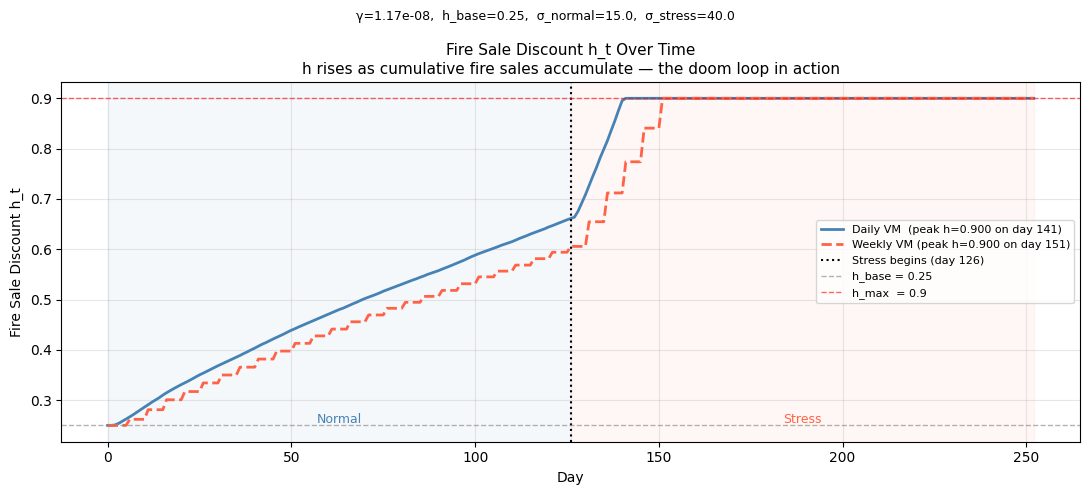


S2: Aggregate fire sales per day...


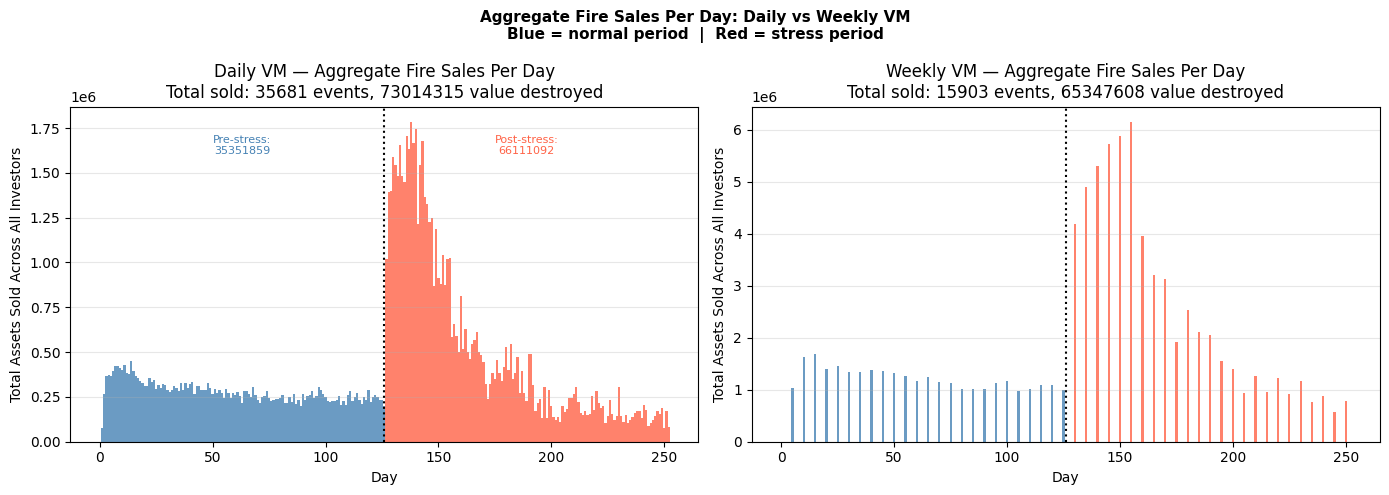


S3: Defaults per day...


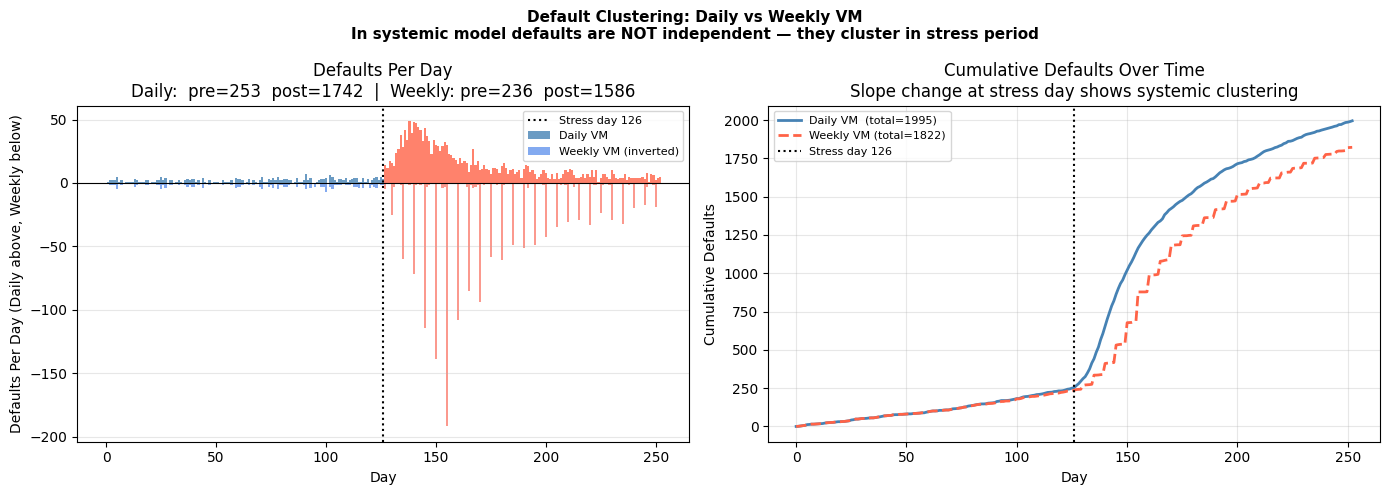


S7: Procyclical vs countercyclical IM...
  Running countercyclical IM version...


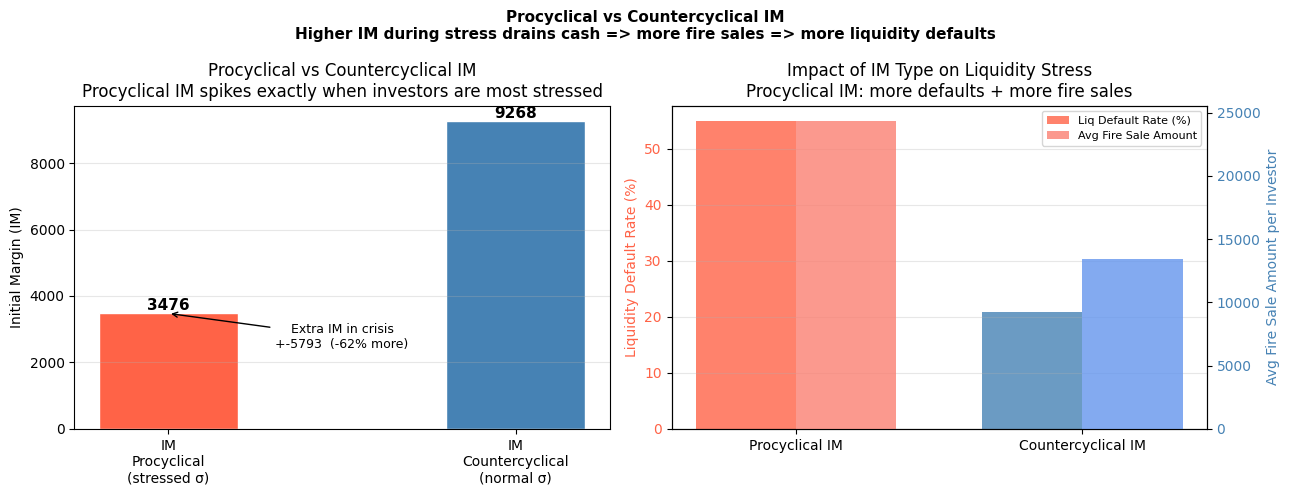


S8: Sigma path + h path...


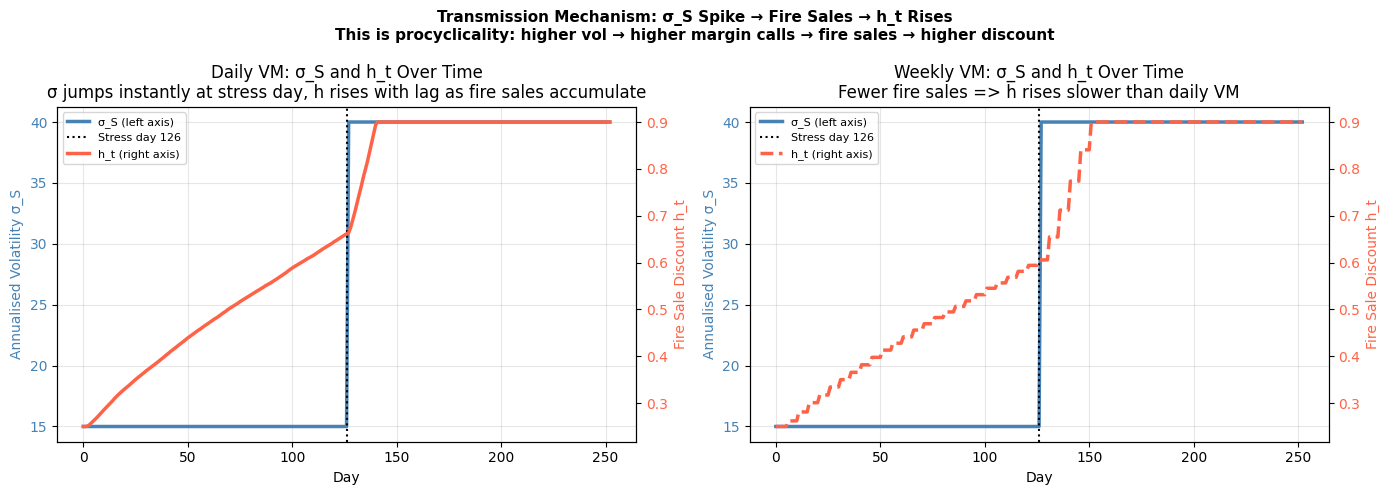


S10: Default day distribution...


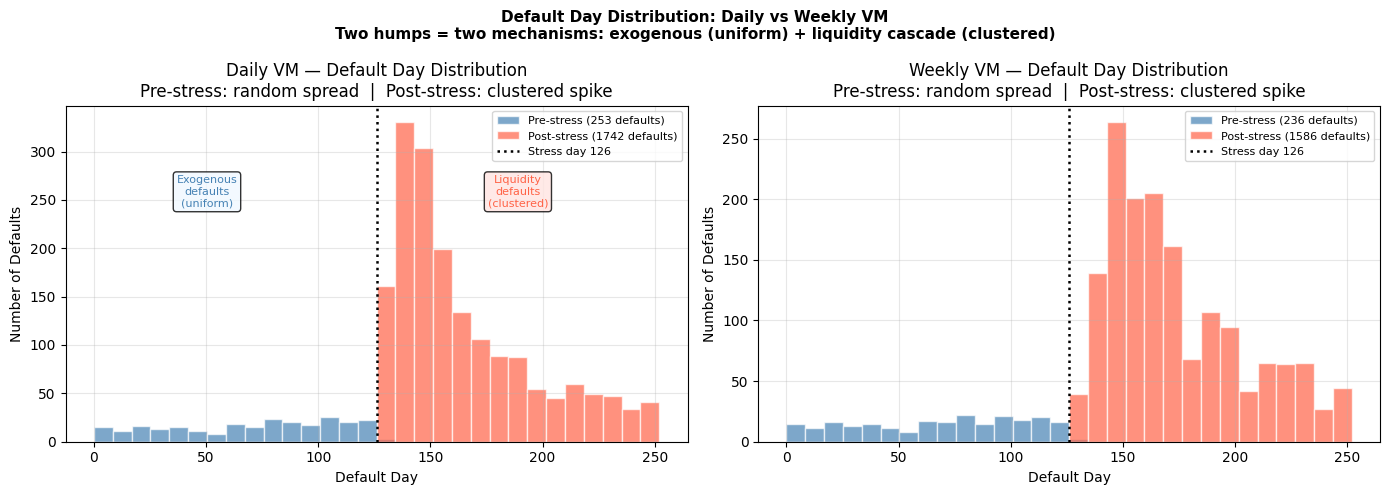


All done.


In [6]:
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



# =============================================================================
# BASE PARAMETERS FOR CASE 3
# Same Q, sigma, PD as other cases for comparability
# gamma calibrated so h reaches ~0.60 when 20% of total pool sold
#   total pool = paths * A0 = 3000 * 50000 = 150,000,000
#   target: h=0.60 when 20% sold => 0.35 / (0.20 * 150M) = 1.17e-8
# =============================================================================
BASE3 = dict(
    Q              = 1000,
    S0             = 100,
    K              = 100,
    sigma_normal   = 15.0,
    sigma_stress   = 40.0,
    stress_day     = 126,
    paths          = 3000,
    PD_annual      = 0.15,
    MPOR           = 10,
    IM_multiplier  = 0.5,
    L0             = 5000.0,
    A0             = 50000.0,
    h_base         = 0.25,
    h_max          = 0.90,
    gamma          = 1.17e-8,
    seed_paths     = 0,
    seed_pd        = 1
)

# day axis for all time series plots
DAYS = list(range(253))


# =============================================================================
# HELPER: run both VM_FREQ variants from same BASE3
# =============================================================================
def run_daily_and_weekly(**kwargs):
    """
    Merges kwargs into BASE3 and runs daily (VM_FREQ=1) and weekly (VM_FREQ=5).
    Returns (rd, rw)
    """
    p = {}
    for k, v in BASE3.items():
        p[k] = v
    for k, v in kwargs.items():
        p[k] = v

    rd = run_case3(**p, VM_FREQ=1)
    rw = run_case3(**p, VM_FREQ=5)
    return rd, rw


# =============================================================================
# PLOT S1: h_t Over Time -- Daily vs Weekly
#
# The doom loop made visible.
# h starts flat at h_base, rises after stress_day as fire sales accumulate.
# Weekly VM => fewer but larger fire sales => slightly different h trajectory.
# Vertical line marks stress_day.
# =============================================================================
def plot_s1_h_over_time(rd, rw, save=False):

    stress_day = rd["stress_day"]
    h_base     = rd["h_base"]
    h_max      = rd["h_max"]

    fig, ax = plt.subplots(figsize=(11, 5))

    ax.plot(DAYS, rd["h_path"], color="steelblue", linewidth=2,
            label=f"Daily VM  (peak h={rd['h_peak']:.3f} on day {rd['h_peak_day']})")
    ax.plot(DAYS, rw["h_path"], color="tomato",    linewidth=2, linestyle="--",
            label=f"Weekly VM (peak h={rw['h_peak']:.3f} on day {rw['h_peak_day']})")

    # stress day marker
    ax.axvline(stress_day, color="black", linestyle=":", linewidth=1.5,
               label=f"Stress begins (day {stress_day})")

    # reference lines
    ax.axhline(h_base, color="grey", linestyle="--", linewidth=1.0, alpha=0.6,
               label=f"h_base = {h_base}")
    ax.axhline(h_max,  color="red",  linestyle="--", linewidth=1.0, alpha=0.6,
               label=f"h_max  = {h_max}")

    # shade normal vs stress period
    ax.axvspan(0,          stress_day, alpha=0.05, color="steelblue")
    ax.axvspan(stress_day, 252,        alpha=0.05, color="tomato")
    ax.text(stress_day / 2,      h_base * 1.02, "Normal", ha="center", fontsize=9, color="steelblue")
    ax.text((stress_day + 252) / 2, h_base * 1.02, "Stress", ha="center", fontsize=9, color="tomato")

    ax.set_xlabel("Day")
    ax.set_ylabel("Fire Sale Discount h_t")
    ax.set_title(
        "Fire Sale Discount h_t Over Time\n"
        "h rises as cumulative fire sales accumulate — the doom loop in action",
        fontsize=11
    )
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    fig.suptitle(
        f"γ={BASE3['gamma']:.2e},  h_base={h_base},  "
        f"σ_normal={BASE3['sigma_normal']},  σ_stress={BASE3['sigma_stress']}",
        fontsize=9
    )
    fig.tight_layout()
    # fig.savefig("plotS1_h_over_time.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT S2: Aggregate Fire Sales Per Day -- Daily vs Weekly
#
# Bar chart of aggregate_sold_per_day[t].
# Shows exactly when the system breaks and how fast the cascade develops.
# Near zero in normal period, massive spike after stress_day.
# =============================================================================
def plot_s2_aggregate_fire_sales(rd, rw, save=False):

    stress_day = rd["stress_day"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- panel 1: daily VM ---
    ax1.bar(DAYS, rd["aggregate_sold_per_day"],
            color=["steelblue" if t <= stress_day else "tomato" for t in DAYS],
            width=1.0, alpha=0.8)
    ax1.axvline(stress_day, color="black", linestyle=":", linewidth=1.5)
    ax1.set_xlabel("Day")
    ax1.set_ylabel("Total Assets Sold Across All Investors")
    ax1.set_title(f"Daily VM — Aggregate Fire Sales Per Day\n"
                  f"Total sold: {rd['total_firesale_events']} events, "
                  f"{rd['total_firesale_amount']:.0f} value destroyed")
    ax1.grid(True, alpha=0.3, axis="y")

    # add pre/post stress totals as text
    pre_stress  = sum(rd["aggregate_sold_per_day"][1:stress_day + 1])
    post_stress = sum(rd["aggregate_sold_per_day"][stress_day + 1:])
    ax1.text(stress_day * 0.5,       max(rd["aggregate_sold_per_day"]) * 0.9,
             f"Pre-stress:\n{pre_stress:.0f}",  ha="center", fontsize=8, color="steelblue")
    ax1.text((stress_day + 252) * 0.5, max(rd["aggregate_sold_per_day"]) * 0.9,
             f"Post-stress:\n{post_stress:.0f}", ha="center", fontsize=8, color="tomato")

    # --- panel 2: weekly VM ---
    ax2.bar(DAYS, rw["aggregate_sold_per_day"],
            color=["steelblue" if t <= stress_day else "tomato" for t in DAYS],
            width=1.0, alpha=0.8)
    ax2.axvline(stress_day, color="black", linestyle=":", linewidth=1.5)
    ax2.set_xlabel("Day")
    ax2.set_ylabel("Total Assets Sold Across All Investors")
    ax2.set_title(f"Weekly VM — Aggregate Fire Sales Per Day\n"
                  f"Total sold: {rw['total_firesale_events']} events, "
                  f"{rw['total_firesale_amount']:.0f} value destroyed")
    ax2.grid(True, alpha=0.3, axis="y")

    fig.suptitle(
        "Aggregate Fire Sales Per Day: Daily vs Weekly VM\n"
        "Blue = normal period  |  Red = stress period",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotS2_aggregate_fire_sales.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT S3: Defaults Per Day -- Daily vs Weekly
#
# Bar chart of defaults_per_day[t].
# Normal period: sparse, random (only exogenous defaults)
# Stress period: clustered spike (liquidity defaults pile up)
# This is SYSTEMIC RISK made visible -- defaults are not independent
# =============================================================================
def plot_s3_defaults_per_day(rd, rw, save=False):

    stress_day = rd["stress_day"]

    # compute cumulative defaults for secondary line
    cum_defaults_d = [0] * 253
    cum_defaults_w = [0] * 253
    for t in range(1, 253):
        cum_defaults_d[t] = cum_defaults_d[t - 1] + rd["defaults_per_day"][t]
        cum_defaults_w[t] = cum_defaults_w[t - 1] + rw["defaults_per_day"][t]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- panel 1: defaults per day ---
    ax1.bar(DAYS, rd["defaults_per_day"],
            color=["steelblue" if t <= stress_day else "tomato" for t in DAYS],
            width=1.0, alpha=0.8, label="Daily VM")
    ax1.bar(DAYS, [-x for x in rw["defaults_per_day"]],
            color=["cornflowerblue" if t <= stress_day else "salmon" for t in DAYS],
            width=1.0, alpha=0.8, label="Weekly VM (inverted)")
    ax1.axvline(stress_day, color="black", linestyle=":", linewidth=1.5,
                label=f"Stress day {stress_day}")
    ax1.axhline(0, color="black", linewidth=0.8)
    ax1.set_xlabel("Day")
    ax1.set_ylabel("Defaults Per Day (Daily above, Weekly below)")
    ax1.set_title("Defaults Per Day: Daily vs Weekly VM\n"
                  "Spike after stress day = systemic liquidity cascade")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3, axis="y")

    # add pre/post counts
    pre_d  = sum(rd["defaults_per_day"][1:stress_day + 1])
    post_d = sum(rd["defaults_per_day"][stress_day + 1:])
    pre_w  = sum(rw["defaults_per_day"][1:stress_day + 1])
    post_w = sum(rw["defaults_per_day"][stress_day + 1:])
    ax1.set_title(
        f"Defaults Per Day\n"
        f"Daily:  pre={pre_d}  post={post_d}  |  "
        f"Weekly: pre={pre_w}  post={post_w}"
    )

    # --- panel 2: cumulative defaults over time ---
    ax2.plot(DAYS, cum_defaults_d, color="steelblue", linewidth=2,
             label=f"Daily VM  (total={rd['n_defaults']})")
    ax2.plot(DAYS, cum_defaults_w, color="tomato",    linewidth=2, linestyle="--",
             label=f"Weekly VM (total={rw['n_defaults']})")
    ax2.axvline(stress_day, color="black", linestyle=":", linewidth=1.5,
                label=f"Stress day {stress_day}")
    ax2.set_xlabel("Day")
    ax2.set_ylabel("Cumulative Defaults")
    ax2.set_title("Cumulative Defaults Over Time\n"
                  "Slope change at stress day shows systemic clustering")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "Default Clustering: Daily vs Weekly VM\n"
        "In systemic model defaults are NOT independent — they cluster in stress period",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotS3_defaults_per_day.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT S6: gamma=0 vs gamma>0 -- The Externality Effect
#
# Most important Case 3 plot for the report.
# Runs two versions: no feedback (gamma=0) vs doom loop (gamma=BASE3 value)
# Shows h_path, defaults_per_day, and total liq defaults side by side
# The gap between the two = the pure cost of the liquidity externality
# =============================================================================
'''#def plot_s6_gamma_comparison(save=False):

    print("  Running gamma=0 (no externality)...")
    rd_no, rw_no = run_daily_and_weekly(gamma=0.0)

    print("  Running gamma>0 (with externality)...")
    rd_ext, rw_ext = run_daily_and_weekly()   # uses BASE3 gamma

    stress_day = BASE3["stress_day"]
    gamma_val  = BASE3["gamma"]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # --- top left: h_path daily -- gamma=0 vs gamma>0 ---
    ax = axes[0][0]
    ax.plot(DAYS, rd_no["h_path"],  color="steelblue", linewidth=2,
            linestyle="--", label=f"γ=0  (fixed h={BASE3['h_base']})")
    ax.plot(DAYS, rd_ext["h_path"], color="tomato",    linewidth=2,
            label=f"γ={gamma_val:.2e}  (doom loop)")
    ax.axvline(stress_day, color="black", linestyle=":", linewidth=1.5)
    ax.set_xlabel("Day")
    ax.set_ylabel("h_t")
    ax.set_title("Fire Sale Discount h_t — Daily VM\n"
                 "γ>0: h rises in stress, γ=0: h stays flat")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # --- top right: h_path weekly -- gamma=0 vs gamma>0 ---
    ax = axes[0][1]
    ax.plot(DAYS, rw_no["h_path"],  color="steelblue", linewidth=2,
            linestyle="--", label=f"γ=0  (fixed h={BASE3['h_base']})")
    ax.plot(DAYS, rw_ext["h_path"], color="tomato",    linewidth=2,
            label=f"γ={gamma_val:.2e}  (doom loop)")
    ax.axvline(stress_day, color="black", linestyle=":", linewidth=1.5)
    ax.set_xlabel("Day")
    ax.set_ylabel("h_t")
    ax.set_title("Fire Sale Discount h_t — Weekly VM\n"
                 "Weekly: fewer sales => h rises slower")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # --- bottom left: defaults per day daily -- gamma=0 vs gamma>0 ---
    ax = axes[1][0]
    ax.bar(DAYS, rd_no["defaults_per_day"],
           color="steelblue", width=1.0, alpha=0.6, label="γ=0")
    ax.bar(DAYS, rd_ext["defaults_per_day"],
           color="tomato",    width=1.0, alpha=0.6, label="γ>0")
    ax.axvline(stress_day, color="black", linestyle=":", linewidth=1.5)
    ax.set_xlabel("Day")
    ax.set_ylabel("Defaults Per Day")
    ax.set_title(
        f"Defaults Per Day — Daily VM\n"
        f"γ=0: liq defaults={rd_no['n_liq_defaults']}  |  "
        f"γ>0: liq defaults={rd_ext['n_liq_defaults']}"
    )
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis="y")

    # --- bottom right: summary bar chart ---
    ax = axes[1][1]
    labels    = ["Liq Defaults\nDaily γ=0", "Liq Defaults\nDaily γ>0",
                 "Liq Defaults\nWeekly γ=0", "Liq Defaults\nWeekly γ>0"]
    values    = [rd_no["n_liq_defaults"],  rd_ext["n_liq_defaults"],
                 rw_no["n_liq_defaults"],  rw_ext["n_liq_defaults"]]
    colors    = ["steelblue", "tomato", "cornflowerblue", "salmon"]

    bars = ax.bar(labels, values, color=colors, edgecolor="white", width=0.5)
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, h,
                f"{int(h)}", ha="center", va="bottom", fontsize=10, fontweight="bold")

    ax.set_ylabel("Number of Liquidity Defaults")
    ax.set_title("Total Liquidity Defaults: γ=0 vs γ>0\n"
                 "Extra defaults from externality = doom loop cost")
    ax.grid(True, alpha=0.3, axis="y")

    # annotate the extra defaults caused by externality
    extra_daily  = rd_ext["n_liq_defaults"] - rd_no["n_liq_defaults"]
    extra_weekly = rw_ext["n_liq_defaults"] - rw_no["n_liq_defaults"]
    ax.text(0.5, max(values) * 0.5,
            f"Extra defaults\nfrom externality:\nDaily  +{extra_daily}\nWeekly +{extra_weekly}",
            ha="center", va="center", fontsize=9,
            bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8))

    fig.suptitle(
        "Liquidity Externality: γ=0 (No Feedback) vs γ>0 (Doom Loop)\n"
        "The gap between γ=0 and γ>0 is the pure cost of the systemic externality",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotS6_gamma_comparison.png", dpi=150)
    plt.show()'''


# =============================================================================
# PLOT S7: IM Procyclical vs Countercyclical
#
# Bar chart comparing IM_procyclical vs IM_countercyclical.
# Procyclical IM = computed from stressed paths => spikes in crisis
# Countercyclical IM = computed from normal sigma only => stable
# Overlay shows that higher IM demand arrives when investors can least afford it
# =============================================================================
def plot_s7_im_procyclical(rd, rw, save=False):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

    # --- panel 1: IM comparison bar chart ---
    labels = ["IM\nProcyclical\n(stressed σ)",
              "IM\nCountercyclical\n(normal σ)"]
    im_vals = [rd["IM_procyclical"], rd["IM_countercyclical"]]
    colors  = ["tomato", "steelblue"]

    bars = ax1.bar(labels, im_vals, color=colors, width=0.4,
                   edgecolor="white")
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2.0, h,
                 f"{h:.0f}", ha="center", va="bottom",
                 fontsize=11, fontweight="bold")

    # add arrow showing the extra IM demand in crisis
    extra_im = rd["IM_procyclical"] - rd["IM_countercyclical"]
    ax1.annotate(
        f"Extra IM in crisis\n+{extra_im:.0f}  ({extra_im/rd['IM_countercyclical']*100:.0f}% more)",
        xy=(0, rd["IM_procyclical"]),
        xytext=(0.5, rd["IM_procyclical"] * 0.7),
        fontsize=9,
        arrowprops=dict(arrowstyle="->", color="black"),
        ha="center"
    )

    ax1.set_ylabel("Initial Margin (IM)")
    ax1.set_title("Procyclical vs Countercyclical IM\n"
                  "Procyclical IM spikes exactly when investors are most stressed")
    ax1.grid(True, alpha=0.3, axis="y")

    # --- panel 2: IM vs fire sale amount and liq default rate ---
    # show how higher IM (procyclical) drains cash => more fire sales
    categories = ["Procyclical IM", "Countercyclical IM"]

    # run countercyclical version using IM_countercyclical
    # approximate by using sigma_normal for both regimes
    print("  Running countercyclical IM version...")
    rd_cc, _ = run_daily_and_weekly(
        sigma_normal=BASE3["sigma_normal"],
        sigma_stress=BASE3["sigma_normal"]   # flat sigma => no IM spike
    )

    liq_rates = [rd["liq_default_rate"] * 100.0,
                 rd_cc["liq_default_rate"] * 100.0]
    fs_amounts = [rd["avg_firesale_amount"],
                  rd_cc["avg_firesale_amount"]]

    x = [0, 1]
    width = 0.35

    ax2_twin = ax2.twinx()

    b1 = ax2.bar([xi - width/2 for xi in x], liq_rates,
                 width=width, color=["tomato", "steelblue"],
                 alpha=0.8, label="Liq Default Rate (%)")
    b2 = ax2_twin.bar([xi + width/2 for xi in x], fs_amounts,
                      width=width, color=["salmon", "cornflowerblue"],
                      alpha=0.8, label="Avg Fire Sale Amount")

    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.set_ylabel("Liquidity Default Rate (%)", color="tomato")
    ax2_twin.set_ylabel("Avg Fire Sale Amount per Investor", color="steelblue")
    ax2.set_title("Impact of IM Type on Liquidity Stress\n"
                  "Procyclical IM: more defaults + more fire sales")
    ax2.tick_params(axis="y", labelcolor="tomato")
    ax2_twin.tick_params(axis="y", labelcolor="steelblue")

    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc="upper right")
    ax2.grid(True, alpha=0.3, axis="y")

    fig.suptitle(
        "Procyclical vs Countercyclical IM\n"
        "Higher IM during stress drains cash => more fire sales => more liquidity defaults",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotS7_im_procyclical.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT S8: Sigma Path + h Path on Same Plot
#
# Two-axis plot showing regime switch and h response.
# Left axis: sigma_path[t] -- jumps at stress_day
# Right axis: h_path[t]    -- rises after stress_day with a lag
# The lag between sigma jumping and h rising shows the transmission mechanism:
#   sigma spike => VM calls => fire sales => h rises
# =============================================================================
def plot_s8_sigma_and_h(rd, rw, save=False):

    stress_day = rd["stress_day"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- panel 1: daily VM ---
    color_sigma = "steelblue"
    color_h     = "tomato"

    ax1_h = ax1.twinx()

    ax1.plot(DAYS, rd["sigma_path"], color=color_sigma, linewidth=2.5,
             label="σ_S (left axis)")
    ax1_h.plot(DAYS, rd["h_path"],  color=color_h,     linewidth=2.5,
               label="h_t (right axis)")

    ax1.axvline(stress_day, color="black", linestyle=":", linewidth=1.5,
                label=f"Stress day {stress_day}")

    ax1.set_xlabel("Day")
    ax1.set_ylabel("Annualised Volatility σ_S", color=color_sigma)
    ax1_h.set_ylabel("Fire Sale Discount h_t",  color=color_h)
    ax1.tick_params(axis="y", labelcolor=color_sigma)
    ax1_h.tick_params(axis="y", labelcolor=color_h)

    ax1.set_title("Daily VM: σ_S and h_t Over Time\n"
                  "σ jumps instantly at stress day, h rises with lag as fire sales accumulate")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_h.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=8)
    ax1.grid(True, alpha=0.3)

    # add transmission annotation
    # find day when h first rises noticeably above h_base
    h_base = rd["h_base"]
    h_threshold = h_base + 0.02   # 2pp above base
    first_rise_day = stress_day
    for t in range(stress_day, 253):
        if rd["h_path"][t] > h_threshold:
            first_rise_day = t
            break
    lag = first_rise_day - stress_day
    if lag > 0:
        ax1_h.annotate(
            f"h starts rising\nday {first_rise_day}\n(lag={lag} days)",
            xy=(first_rise_day, rd["h_path"][first_rise_day]),
            xytext=(first_rise_day + 15, h_base + 0.03),
            fontsize=8,
            arrowprops=dict(arrowstyle="->", color="tomato"),
            color="tomato"
        )

    # --- panel 2: weekly VM ---
    ax2_h = ax2.twinx()

    ax2.plot(DAYS, rw["sigma_path"], color=color_sigma, linewidth=2.5,
             label="σ_S (left axis)")
    ax2_h.plot(DAYS, rw["h_path"],  color=color_h,     linewidth=2.5,
               linestyle="--", label="h_t (right axis)")

    ax2.axvline(stress_day, color="black", linestyle=":", linewidth=1.5,
                label=f"Stress day {stress_day}")

    ax2.set_xlabel("Day")
    ax2.set_ylabel("Annualised Volatility σ_S", color=color_sigma)
    ax2_h.set_ylabel("Fire Sale Discount h_t",  color=color_h)
    ax2.tick_params(axis="y", labelcolor=color_sigma)
    ax2_h.tick_params(axis="y", labelcolor=color_h)

    ax2.set_title("Weekly VM: σ_S and h_t Over Time\n"
                  "Fewer fire sales => h rises slower than daily VM")

    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_h.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "Transmission Mechanism: σ_S Spike → Fire Sales → h_t Rises\n"
        "This is procyclicality: higher vol → higher margin calls → fire sales → higher discount",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotS8_sigma_and_h.png", dpi=150)
    plt.show()


# =============================================================================
# PLOT S10: Default Day Distribution
#
# Histogram of actual_default_day[i] for all defaulted investors.
# Normal period: flat, sparse (exogenous defaults only, random)
# Stress period: sharp spike (liquidity defaults cluster)
# Two humps = proof of two default mechanisms
# Compare gamma=0 (no clustering) vs gamma>0 (clustered)
# =============================================================================
def plot_s10_default_day_distribution(rd, rw, save=False):

    stress_day = rd["stress_day"]

    # collect default days for daily VM
    # separate into pre-stress and post-stress
    def_days_d_pre  = []
    def_days_d_post = []
    for i in range(len(rd["actual_default_day"])):
        t_d = rd["actual_default_day"][i]
        if t_d == -1:
            continue
        if t_d <= stress_day:
            def_days_d_pre.append(t_d)
        else:
            def_days_d_post.append(t_d)

    # collect for weekly VM
    def_days_w_pre  = []
    def_days_w_post = []
    for i in range(len(rw["actual_default_day"])):
        t_d = rw["actual_default_day"][i]
        if t_d == -1:
            continue
        if t_d <= stress_day:
            def_days_w_pre.append(t_d)
        else:
            def_days_w_post.append(t_d)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- panel 1: daily VM ---
    # show pre-stress and post-stress bars in different colours
    all_days_d = def_days_d_pre + def_days_d_post
    colors_d   = (["steelblue"] * len(def_days_d_pre) +
                  ["tomato"]    * len(def_days_d_post))

    if len(all_days_d) > 0:
        ax1.hist(def_days_d_pre,  bins=30, range=(0, 252),
                 color="steelblue", alpha=0.7, edgecolor="white",
                 label=f"Pre-stress ({len(def_days_d_pre)} defaults)")
        ax1.hist(def_days_d_post, bins=30, range=(0, 252),
                 color="tomato",    alpha=0.7, edgecolor="white",
                 label=f"Post-stress ({len(def_days_d_post)} defaults)")

    ax1.axvline(stress_day, color="black", linestyle=":", linewidth=1.8,
                label=f"Stress day {stress_day}")
    ax1.set_xlabel("Default Day")
    ax1.set_ylabel("Number of Defaults")
    ax1.set_title(f"Daily VM — Default Day Distribution\n"
                  f"Pre-stress: random spread  |  Post-stress: clustered spike")
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)

    # annotate the two mechanisms
    ax1.text(stress_day * 0.4, ax1.get_ylim()[1] * 0.7,
             "Exogenous\ndefaults\n(uniform)", ha="center",
             fontsize=8, color="steelblue",
             bbox=dict(boxstyle="round", facecolor="aliceblue", alpha=0.8))
    if len(def_days_d_post) > 0:
        ax1.text((stress_day + 252) * 0.5, ax1.get_ylim()[1] * 0.7,
                 "Liquidity\ndefaults\n(clustered)", ha="center",
                 fontsize=8, color="tomato",
                 bbox=dict(boxstyle="round", facecolor="mistyrose", alpha=0.8))

    # --- panel 2: weekly VM ---
    if len(def_days_w_pre) > 0 or len(def_days_w_post) > 0:
        ax2.hist(def_days_w_pre,  bins=30, range=(0, 252),
                 color="steelblue", alpha=0.7, edgecolor="white",
                 label=f"Pre-stress ({len(def_days_w_pre)} defaults)")
        ax2.hist(def_days_w_post, bins=30, range=(0, 252),
                 color="tomato",    alpha=0.7, edgecolor="white",
                 label=f"Post-stress ({len(def_days_w_post)} defaults)")

    ax2.axvline(stress_day, color="black", linestyle=":", linewidth=1.8,
                label=f"Stress day {stress_day}")
    ax2.set_xlabel("Default Day")
    ax2.set_ylabel("Number of Defaults")
    ax2.set_title(f"Weekly VM — Default Day Distribution\n"
                  f"Pre-stress: random spread  |  Post-stress: clustered spike")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        "Default Day Distribution: Daily vs Weekly VM\n"
        "Two humps = two mechanisms: exogenous (uniform) + liquidity cascade (clustered)",
        fontsize=11, fontweight="bold"
    )
    fig.tight_layout()
    # fig.savefig("plotS10_default_day_distribution.png", dpi=150)
    plt.show()


# =============================================================================
# MAIN
# =============================================================================
if __name__ == "__main__":

    print("=" * 60)
    print("Case 3 Plots -- Systemic Risk and Procyclicality")
    print(f"Base: Q={BASE3['Q']}, sigma_normal={BASE3['sigma_normal']},")
    print(f"      sigma_stress={BASE3['sigma_stress']}, stress_day={BASE3['stress_day']}")
    print(f"      gamma={BASE3['gamma']:.2e}, paths={BASE3['paths']}")
    print("=" * 60)

    # run base daily and weekly once -- reuse for S1, S2, S3, S7, S8, S10
    print("\nRunning base daily and weekly variants...")
    rd, rw = run_daily_and_weekly()

    print(f"\nDaily:  liq_default_rate={rd['liq_default_rate']:.2%}  "
          f"h_peak={rd['h_peak']:.3f}  "
          f"EL={rd['expected_loss']:.4f}")
    print(f"Weekly: liq_default_rate={rw['liq_default_rate']:.2%}  "
          f"h_peak={rw['h_peak']:.3f}  "
          f"EL={rw['expected_loss']:.4f}")

    print("\nS1: h_t over time...")
    plot_s1_h_over_time(rd, rw)

    print("\nS2: Aggregate fire sales per day...")
    plot_s2_aggregate_fire_sales(rd, rw)

    print("\nS3: Defaults per day...")
    plot_s3_defaults_per_day(rd, rw)

   ## print("\nS6: gamma=0 vs gamma>0 (externality effect)...")
    ##plot_s6_gamma_comparison()

    print("\nS7: Procyclical vs countercyclical IM...")
    plot_s7_im_procyclical(rd, rw)

    print("\nS8: Sigma path + h path...")
    plot_s8_sigma_and_h(rd, rw)

    print("\nS10: Default day distribution...")
    plot_s10_default_day_distribution(rd, rw)

    print("\nAll done.")

## Final Plots

SECTION 1 — BASELINE METRICS TABLE
Running 6 variants (paths=20000)...
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
  Q=1000, σ=30, PD=15%, IM_mult=0.5, paths=20000
  Case3: σ_n=15.0, σ_s=40.0, γ=1.17e-08
Metric                            C1 Daily   C1 Weekly    C2 Daily   C2 Weekly    C3 Daily   C3 Weekly
--------------------------------------------------------------------------------------------
IM (procyclical / base)             6944.6      6944.6      6944.6      6944.6      3475.6      3475.6
IM countercyclical (C3)                N/A         N/A         N/A         N/A      9268.2      9268.2
--------------------------------------------------------------------------------------------
Default rate (total)               14.88%      14.88%      33.55%      31.99%      81.05%      77.28% 
  Exo default rate                 14.88%       0.00%    

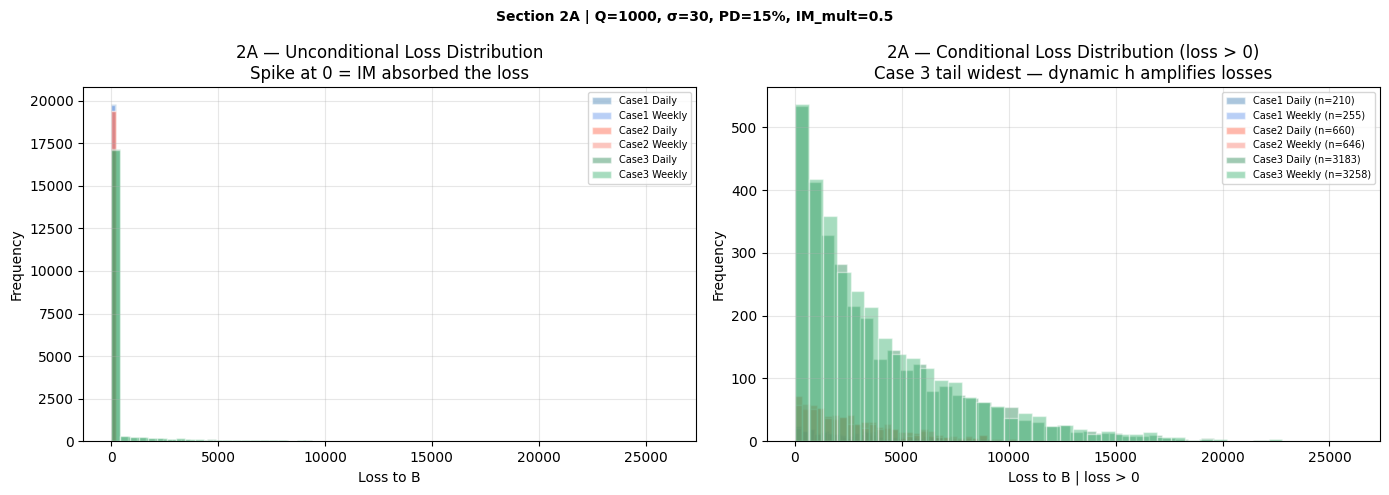

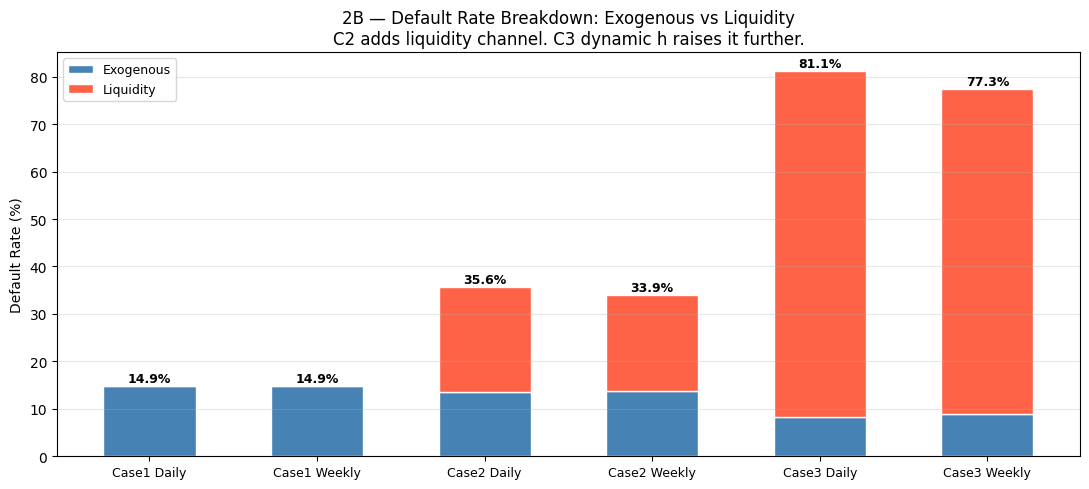

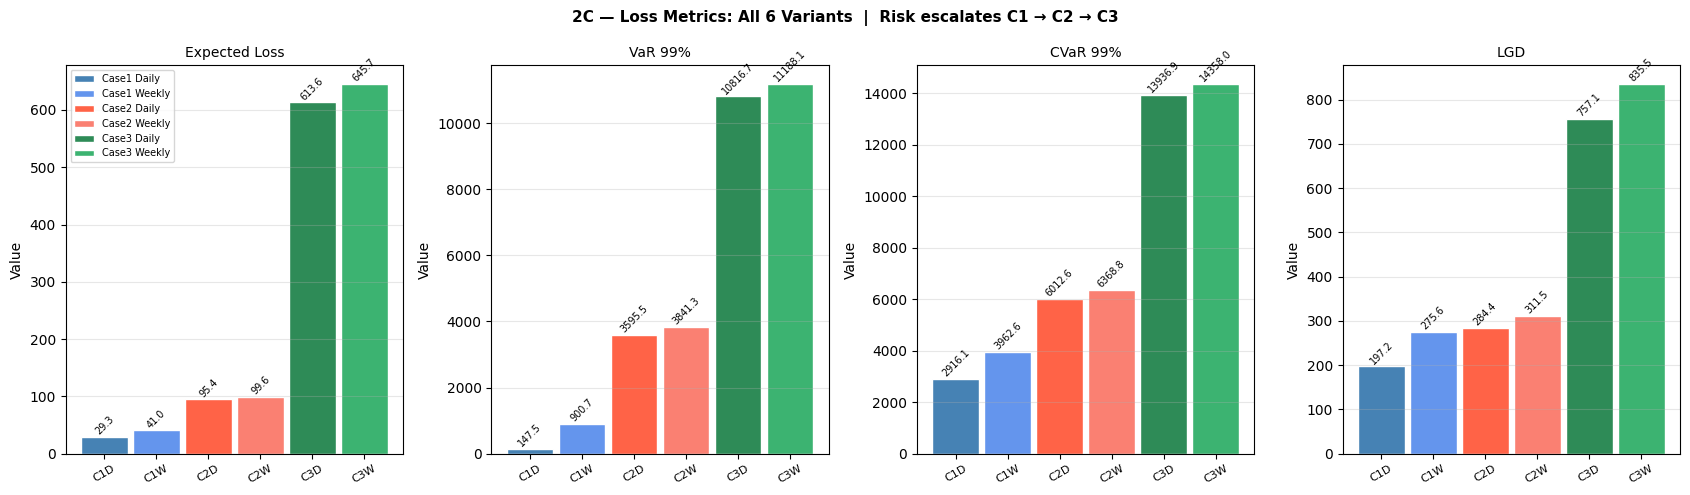


SECTION 3 — What Drives Loss to B


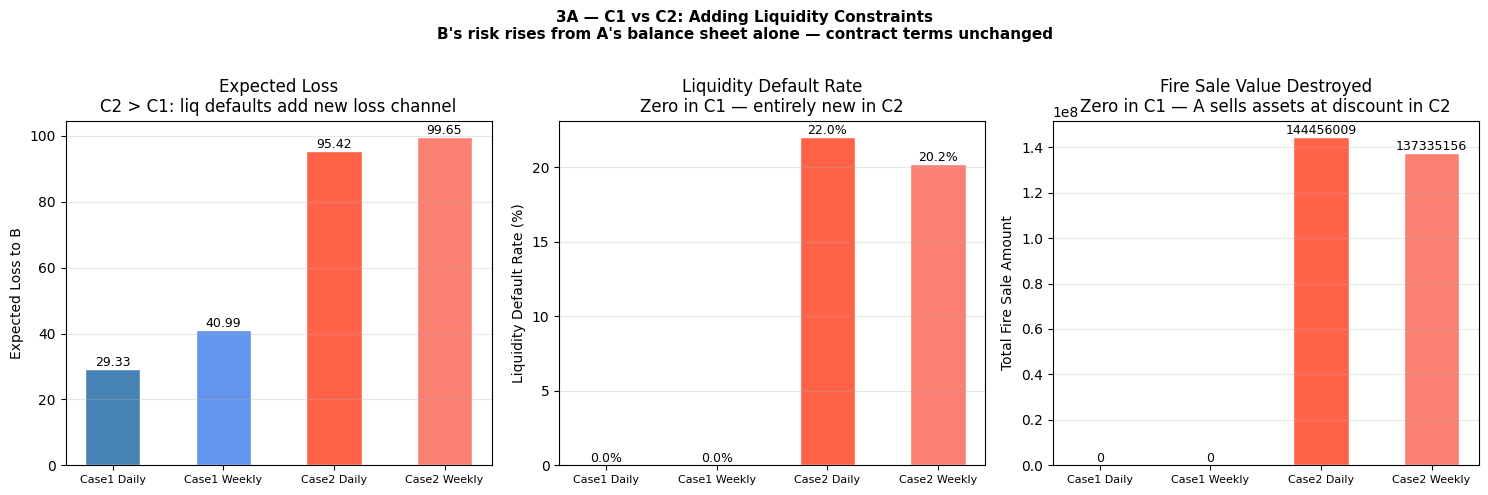

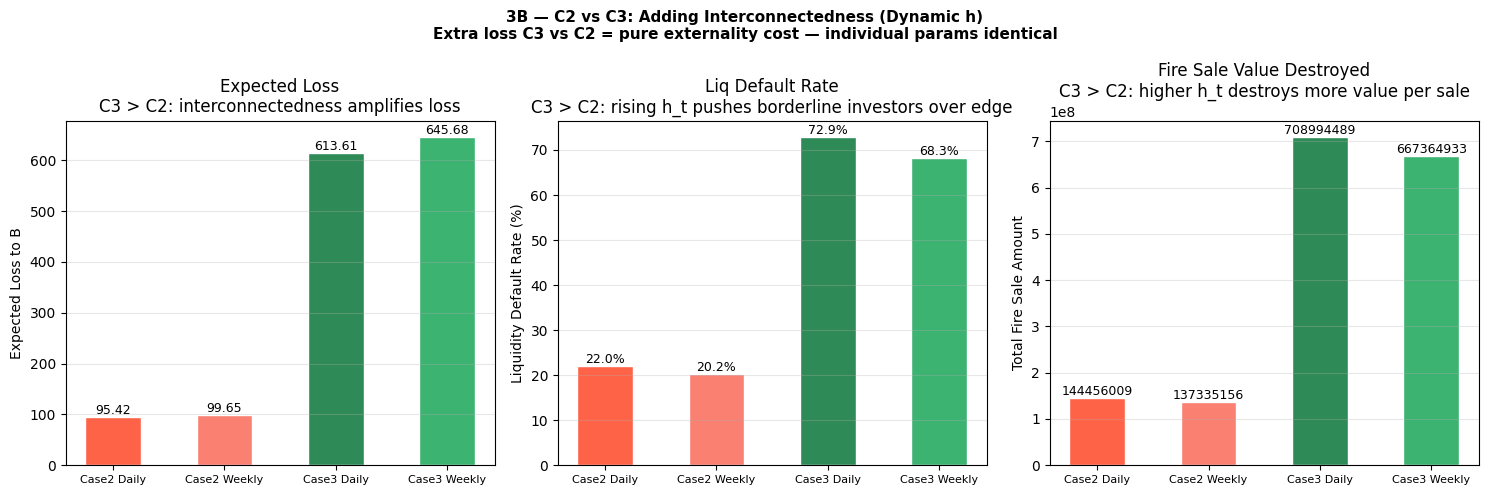

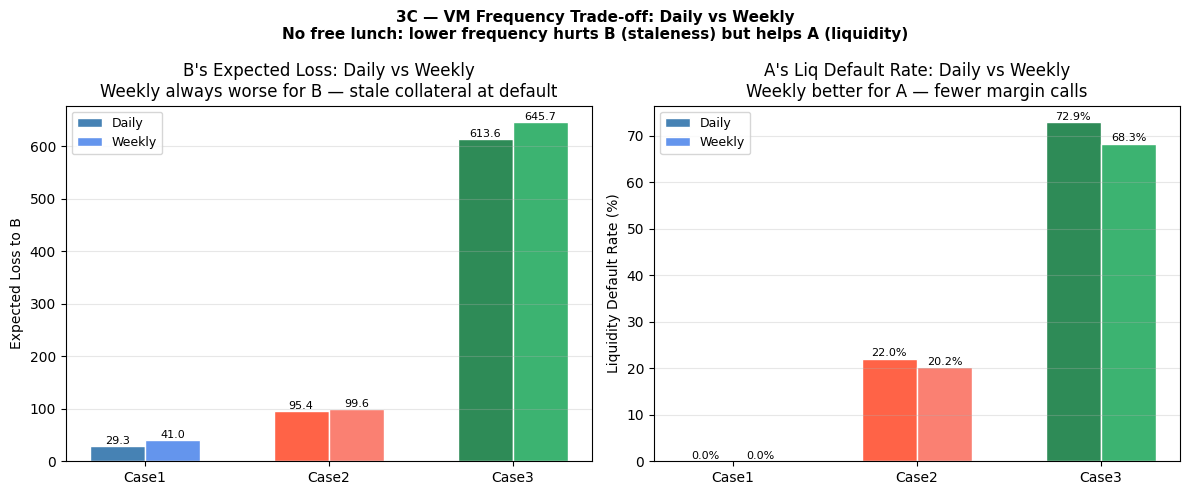


SECTION 4 — Policy Sweeps
  4A: IM multiplier sweep...
Computed IM: 3472.29 (99% VaR = 13889.15)
3472.28687186153
Computed IM: 3472.29 (99% VaR = 13889.15)
Computed IM: 3472.29 (99% VaR = 13889.15)
Computed IM: 3472.29 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 10416.86 (99% VaR = 13889.15)
10416.86061558459
Computed IM: 10416.86 (99% VaR = 13889.15)
Computed IM: 10416.86 (99% VaR = 13889.15)
Computed IM: 10416.86 (99% VaR = 13889.15)
Computed IM: 13889.15 (99% VaR = 13889.15)
13889.14748744612
Computed IM: 13889.15 (99% VaR = 13889.15)
Computed IM: 13889.15 (99% VaR = 13889.15)
Computed IM: 13889.15 (99% VaR = 13889.15)
Computed IM: 17361.43 (99% VaR = 13889.15)
17361.43435930765
Computed IM: 17361.43 (99% VaR = 13889.15)
Computed IM: 17361.43 (99% VaR = 13889.15)
Computed IM: 17361.43 (99% VaR = 13889.15)
Comp

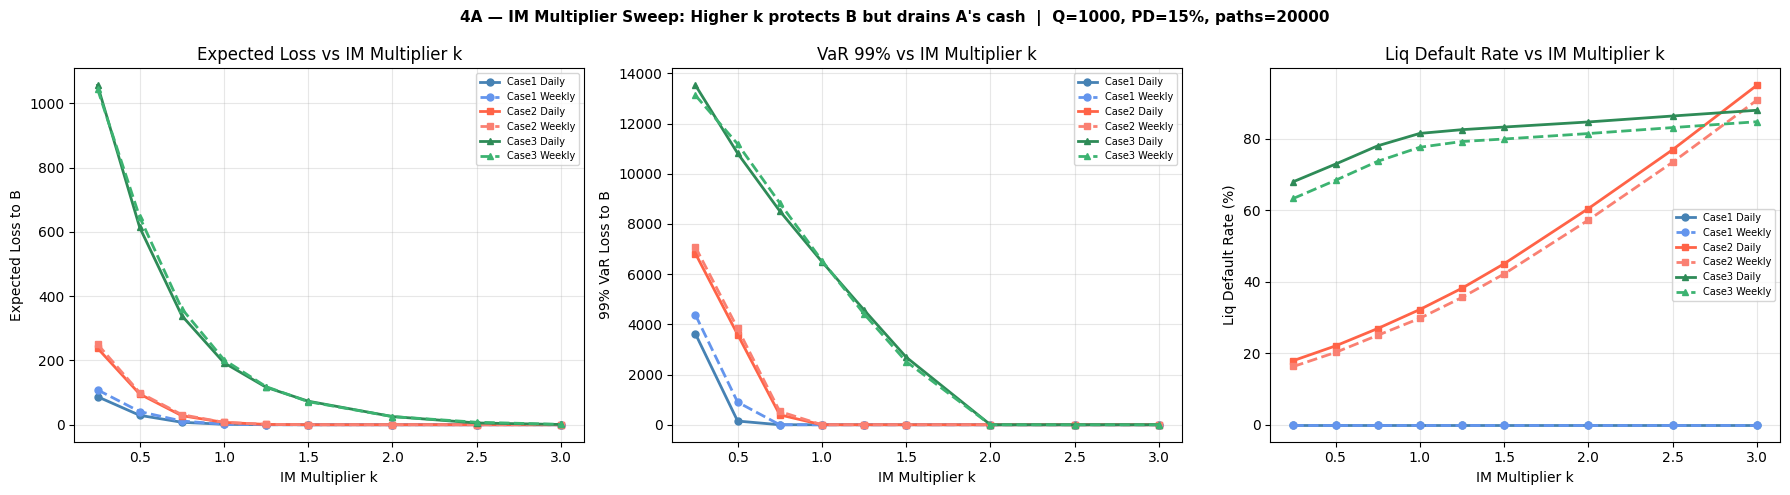

  4B: VM frequency sweep...
    freq=1...
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
    freq=2...
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
    freq=3...
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
    freq=5...
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
    freq=7...
Computed IM: 6944.57 (99% VaR = 13889.15)
6944.57374372306
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.57 (99% VaR = 13889.15)
Computed IM: 6944.5

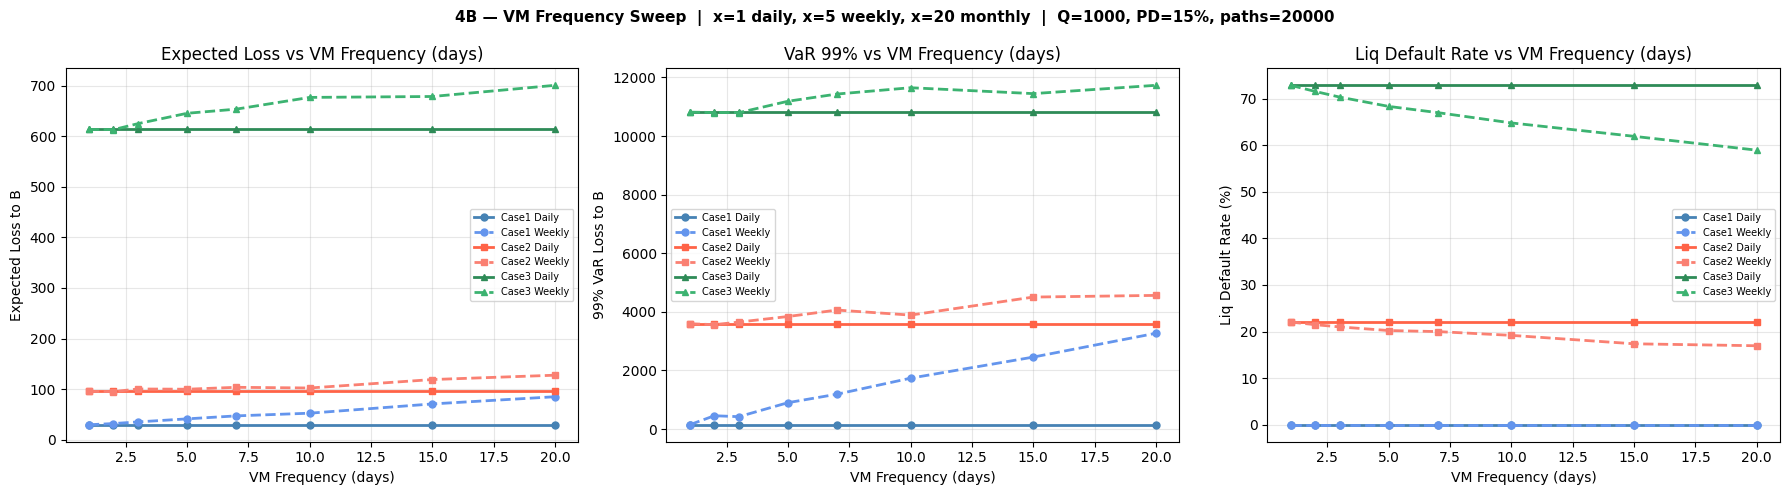

  4C: MPOR sweep...
Computed IM: 2198.47 (99% VaR = 4396.95)
2198.472809467079
Computed IM: 2198.47 (99% VaR = 4396.95)
Computed IM: 2198.47 (99% VaR = 4396.95)
Computed IM: 2198.47 (99% VaR = 4396.95)
Computed IM: 3109.16 (99% VaR = 6218.31)
3109.1572529031955
Computed IM: 3109.16 (99% VaR = 6218.31)
Computed IM: 3109.16 (99% VaR = 6218.31)
Computed IM: 3109.16 (99% VaR = 6218.31)


In [ ]:
# =============================================================================
# ALL SECTIONS — ONE JUPYTER CELL
# Each section defines its own parameters and immediately plots.
# No matplotlib backend override. No files saved. All plots render inline.
# =============================================================================

import math
import matplotlib.pyplot as plt


# ── Shared style (colours, labels — used across all sections) ─────────────────
KEYS   = ["C1D","C1W","C2D","C2W","C3D","C3W"]
DAYS   = list(range(253))
LABELS = {"C1D":"Case1 Daily","C1W":"Case1 Weekly",
          "C2D":"Case2 Daily","C2W":"Case2 Weekly",
          "C3D":"Case3 Daily","C3W":"Case3 Weekly"}
COLORS = {"C1D":"steelblue","C1W":"cornflowerblue",
          "C2D":"tomato",   "C2W":"salmon",
          "C3D":"seagreen", "C3W":"mediumseagreen"}
STYLES = {"C1D":("steelblue",     "-", "o"),"C1W":("cornflowerblue","--","o"),
          "C2D":("tomato",        "-", "s"),"C2W":("salmon",        "--","s"),
          "C3D":("seagreen",      "-", "^"),"C3W":("mediumseagreen","--","^")}


# =============================================================================
# SECTION 1 — BASELINE METRICS TABLE
# Parameters: all six variants with shared base settings.
# Prints a comprehensive comparison table across all cases and VM frequencies.
# =============================================================================
print("=" * 70)
print("SECTION 1 — BASELINE METRICS TABLE")
print("=" * 70)

# ── Section 1 parameters ──────────────────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
sigma_ann     = 30          # constant vol for Case 1 & 2
PD_annual     = 0.15
MPOR          = 10
alpha         = 0.99
IM_multiplier = 0.5
paths         = 20000        # lower to 500 for a quick test
steps         = 252
L0            = 5000.0      # initial cash (Cases 2 & 3)
A0            = 50000.0     # illiquid assets (Cases 2 & 3)
h_fixed       = 0.25        # fixed fire-sale discount (Case 2)
seed_paths    = 0
seed_pd       = 1

# Case 3 extras
sigma_normal  = 15.0
sigma_stress  = 40.0
stress_day    = 126
h_base        = 0.25
h_max         = 0.90
# gamma: h hits 0.60 when 20% of total pool (paths*A0=150M) is sold
gamma         = 1.17e-8

# ── Helper: build param dicts ─────────────────────────────────────────────────
def _p1(**ov):
    p = dict(Q=Q,S0=S0,K=K,sigma_ann=sigma_ann,PD_annual=PD_annual,MPOR=MPOR,
             alpha=alpha,IM_multiplier=IM_multiplier,paths=paths,steps=steps,
             seed_paths=seed_paths,seed_pd=seed_pd)
    p.update(ov); return p

def _p2(**ov):
    p = dict(Q=Q,S0=S0,K=K,sigma_ann=sigma_ann,PD_annual=PD_annual,MPOR=MPOR,
             alpha=alpha,IM_multiplier=IM_multiplier,paths=paths,steps=steps,
             L0=L0,A0=A0,h=h_fixed,seed_paths=seed_paths,seed_pd=seed_pd)
    p.update(ov); return p

def _p3(**ov):
    p = dict(Q=Q,S0=S0,K=K,PD_annual=PD_annual,MPOR=MPOR,alpha=alpha,
             IM_multiplier=IM_multiplier,paths=paths,steps=steps,
             L0=L0,A0=A0,seed_paths=seed_paths,seed_pd=seed_pd,
             sigma_normal=sigma_normal,sigma_stress=sigma_stress,
             stress_day=stress_day,h_base=h_base,h_max=h_max,gamma=gamma)
    p.update(ov); return p

# ── Run all 6 variants ────────────────────────────────────────────────────────
print(f"Running 6 variants (paths={paths})...")
C1D = run_case1(**_p1())
C1W = run_case1_weekly(**_p1(), VM_FREQ=5)
C2D = run_case2(**_p2(), VM_FREQ=1)
C2W = run_case2(**_p2(), VM_FREQ=5)
C3D = run_case3(**_p3(), VM_FREQ=1)
C3W = run_case3(**_p3(), VM_FREQ=5)
V   = {"C1D":C1D,"C1W":C1W,"C2D":C2D,"C2W":C2W,"C3D":C3D,"C3W":C3W}

def _g(r, key, fb=0.0):
    return r.get(key, fb)

# ── Print table ───────────────────────────────────────────────────────────────
W   = 92
lbl = {"C1D":"C1 Daily","C1W":"C1 Weekly","C2D":"C2 Daily",
       "C2W":"C2 Weekly","C3D":"C3 Daily","C3W":"C3 Weekly"}

print("=" * W)
print(f"  Q={Q}, σ={sigma_ann}, PD={PD_annual:.0%}, IM_mult={IM_multiplier}, paths={paths}")
print(f"  Case3: σ_n={sigma_normal}, σ_s={sigma_stress}, γ={gamma:.2e}")
print("=" * W)
print(f"{'Metric':<30}" + "".join(f"{lbl[k]:>12}" for k in KEYS))
print("-" * W)

# IM
row = f"{'IM (procyclical / base)':30}"
for k in KEYS:
    row += f"{_g(V[k],'IM_procyclical',_g(V[k],'IM')):>12.1f}"
print(row)

row = f"{'IM countercyclical (C3)':30}"
for k in KEYS:
    v = _g(V[k],"IM_countercyclical", float("nan"))
    row += f"{'N/A':>12}" if math.isnan(v) else f"{v:>12.1f}"
print(row)
print("-" * W)

for metric, label in [("default_rate","Default rate (total)"),
                       ("exo_default_rate","  Exo default rate"),
                       ("liq_default_rate","  Liq default rate")]:
    row = f"{label:<30}"
    for k in KEYS:
        if metric == "exo_default_rate" and k == "C1D":
            v = _g(V[k],"default_rate")
        elif metric == "liq_default_rate" and k in ("C1D","C1W"):
            v = 0.0
        else:
            v = _g(V[k], metric)
        row += f"{v:>11.2%} "
    print(row)
print("-" * W)

for metric, label in [("expected_loss","Expected loss to B"),
                       ("VaR_99_loss","99% VaR loss"),
                       ("CVaR_99_loss","99% CVaR loss"),
                       ("loss_given_default","Loss given default"),
                       ("pct_loss_positive","% paths positive loss")]:
    row = f"{label:<30}"
    for k in KEYS:
        v = _g(V[k], metric)
        row += f"{v:>11.2%} " if metric == "pct_loss_positive" else f"{v:>12.2f}"
    print(row)
print("-" * W)

for metric, label in [("total_firesale_events","Total fire sale events"),
                       ("total_firesale_amount","Total fire sale amount"),
                       ("avg_firesale_count","Avg fire sales/investor"),
                       ("n_paths_with_firesale","Investors with fire sales")]:
    row = f"{label:<30}"
    for k in KEYS:
        v = _g(V[k], metric)
        row += f"{v:>12.3f}" if metric == "avg_firesale_count" else f"{v:>12.0f}"
    print(row)
print("-" * W)

row = f"{'Peak h_t (C3 only)':30}"
for k in KEYS:
    v = V[k].get("h_peak", float("nan"))
    row += f"{'N/A':>12}" if math.isnan(v) else f"{v:>12.4f}"
print(row)
print("=" * W)

print("\nMODEL SETUP")
print(f"{'Property':<22}" + "".join(f"  {k:<10}" for k in KEYS))
print("-" * 82)
for label, *vals in [
    ("Cash constraint",   "None","None","L0=5000","L0=5000","L0=5000","L0=5000"),
    ("Illiquid assets",   "None","None","A0=50k","A0=50k","A0=50k","A0=50k"),
    ("Fire sale h",       "N/A","N/A","Fixed .25","Fixed .25","Dynamic","Dynamic"),
    ("Sigma",             "Const","Const","Const","Const","Regime","Regime"),
    ("Default channels",  "Exo","Exo","Exo+Liq","Exo+Liq","Exo+Liq","Exo+Liq"),
    ("Investors",         "Indep","Indep","Indep","Indep","Connected","Connected"),
    ("VM freq",           "Daily","Weekly","Daily","Weekly","Daily","Weekly"),
]:
    print(f"{label:<22}" + "".join(f"  {v:<10}" for v in vals))
print("-" * 82)


# =============================================================================
# SECTION 2 — LOSS DISTRIBUTION & DEFAULT BREAKDOWN
# Parameters: uses the 6 variants already run in Section 1 (V dict).
# Plots: 2A loss distributions, 2B default rate stacked bars, 2C loss metrics.
# =============================================================================
print("\nSECTION 2 — Loss Distribution & Default Breakdown")

# ── 2A: Loss distribution (unconditional + conditional on loss > 0) ───────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for k in KEYS:
    loss = V[k]["loss_B"]
    ax1.hist(loss, bins=60, color=COLORS[k], alpha=0.45,
             edgecolor="white", label=LABELS[k])
    pos = [l for l in loss if l > 0]
    if pos:
        ax2.hist(pos, bins=40, color=COLORS[k], alpha=0.45,
                 edgecolor="white", label=f"{LABELS[k]} (n={len(pos)})")
ax1.set_xlabel("Loss to B"); ax1.set_ylabel("Frequency")
ax1.set_title("2A — Unconditional Loss Distribution\nSpike at 0 = IM absorbed the loss")
ax1.legend(fontsize=7); ax1.grid(True, alpha=0.3)
ax2.set_xlabel("Loss to B | loss > 0"); ax2.set_ylabel("Frequency")
ax2.set_title("2A — Conditional Loss Distribution (loss > 0)\nCase 3 tail widest — dynamic h amplifies losses")
ax2.legend(fontsize=7); ax2.grid(True, alpha=0.3)
fig.suptitle(f"Section 2A | Q={Q}, σ={sigma_ann}, PD={PD_annual:.0%}, IM_mult={IM_multiplier}",
             fontsize=10, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 2B: Default rate breakdown — stacked bars exo + liq ──────────────────────
fig, ax = plt.subplots(figsize=(11, 5))
x = list(range(len(KEYS)))
for j, k in enumerate(KEYS):
    exo = (V[k]["default_rate"] if k == "C1D"
           else V[k].get("exo_default_rate", V[k]["default_rate"])) * 100
    liq = V[k].get("liq_default_rate", 0.0) * 100
    ax.bar(x[j], exo, width=0.55, color="steelblue", edgecolor="white",
           label="Exogenous" if j == 0 else "")
    ax.bar(x[j], liq, width=0.55, bottom=exo, color="tomato", edgecolor="white",
           label="Liquidity" if j == 0 else "")
    ax.text(x[j], exo + liq + 0.2, f"{exo+liq:.1f}%",
            ha="center", va="bottom", fontsize=9, fontweight="bold")
ax.set_xticks(x); ax.set_xticklabels([LABELS[k] for k in KEYS], fontsize=9)
ax.set_ylabel("Default Rate (%)"); ax.legend(fontsize=9)
ax.set_title("2B — Default Rate Breakdown: Exogenous vs Liquidity\n"
             "C2 adds liquidity channel. C3 dynamic h raises it further.")
ax.grid(True, alpha=0.3, axis="y")
fig.tight_layout()
plt.show()

# ── 2C: Loss metrics grouped bar chart ───────────────────────────────────────
metrics_2c = [("expected_loss","Expected Loss"), ("VaR_99_loss","VaR 99%"),
              ("CVaR_99_loss","CVaR 99%"),       ("loss_given_default","LGD")]
bw = 0.8 / len(KEYS)
fig, axes = plt.subplots(1, 4, figsize=(17, 5))
for mi, (met, mlbl) in enumerate(metrics_2c):
    ax = axes[mi]
    for j, k in enumerate(KEYS):
        val = V[k].get(met, 0.0)
        xp  = j * bw
        ax.bar(xp, val, width=bw*0.9, color=COLORS[k], edgecolor="white",
               label=LABELS[k] if mi == 0 else "")
        ax.text(xp, val, f"{val:.1f}", ha="center", va="bottom", fontsize=7, rotation=45)
    ax.set_xticks([j*bw for j in range(len(KEYS))])
    ax.set_xticklabels(KEYS, fontsize=8, rotation=30)
    ax.set_title(mlbl, fontsize=10); ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3, axis="y")
axes[0].legend(fontsize=7, loc="upper left")
fig.suptitle("2C — Loss Metrics: All 6 Variants  |  Risk escalates C1 → C2 → C3",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()


# =============================================================================
# SECTION 3 — WHAT DRIVES LOSS TO B
# Parameters: uses the same 6 variants from Section 1 (V dict).
# Plots: 3A C1 vs C2, 3B C2 vs C3, 3C daily vs weekly trade-off.
# =============================================================================
print("\nSECTION 3 — What Drives Loss to B")

def _bars(ax, keys, metric, pct=False, fmt=None):
    for j, k in enumerate(keys):
        val = V[k].get(metric, 0.0) * (100 if pct else 1)
        ax.bar(j, val, width=0.5, color=COLORS[k], edgecolor="white")
        lbl_str = (fmt or ("{:.1f}%" if pct else "{:.2f}")).format(val)
        ax.text(j, val, lbl_str, ha="center", va="bottom", fontsize=9)
    ax.set_xticks(range(len(keys)))
    ax.set_xticklabels([LABELS[k] for k in keys], fontsize=8)
    ax.grid(True, alpha=0.3, axis="y")

# ── 3A: Case 1 vs Case 2 — what liquidity constraints add ────────────────────
ks3a = ["C1D","C1W","C2D","C2W"]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
_bars(ax1, ks3a, "expected_loss")
_bars(ax2, ks3a, "liq_default_rate", pct=True)
_bars(ax3, ks3a, "total_firesale_amount", fmt="{:.0f}")
ax1.set_ylabel("Expected Loss to B")
ax1.set_title("Expected Loss\nC2 > C1: liq defaults add new loss channel")
ax2.set_ylabel("Liquidity Default Rate (%)")
ax2.set_title("Liquidity Default Rate\nZero in C1 — entirely new in C2")
ax3.set_ylabel("Total Fire Sale Amount")
ax3.set_title("Fire Sale Value Destroyed\nZero in C1 — A sells assets at discount in C2")
fig.suptitle("3A — C1 vs C2: Adding Liquidity Constraints\n"
             "B's risk rises from A's balance sheet alone — contract terms unchanged",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 3B: Case 2 vs Case 3 — what interconnectedness adds ──────────────────────
ks3b = ["C2D","C2W","C3D","C3W"]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
_bars(ax1, ks3b, "expected_loss")
_bars(ax2, ks3b, "liq_default_rate", pct=True)
_bars(ax3, ks3b, "total_firesale_amount", fmt="{:.0f}")
ax1.set_ylabel("Expected Loss to B")
ax1.set_title("Expected Loss\nC3 > C2: interconnectedness amplifies loss")
ax2.set_ylabel("Liquidity Default Rate (%)")
ax2.set_title("Liq Default Rate\nC3 > C2: rising h_t pushes borderline investors over edge")
ax3.set_ylabel("Total Fire Sale Amount")
ax3.set_title("Fire Sale Value Destroyed\nC3 > C2: higher h_t destroys more value per sale")
fig.suptitle("3B — C2 vs C3: Adding Interconnectedness (Dynamic h)\n"
             "Extra loss C3 vs C2 = pure externality cost — individual params identical",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 3C: Daily vs Weekly — VM frequency trade-off ─────────────────────────────
cases3c = [("C1","Case1"),("C2","Case2"),("C3","Case3")]
x3c = list(range(3)); w = 0.3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for j, (pfx, clbl) in enumerate(cases3c):
    kd, kw = pfx+"D", pfx+"W"
    el_d   = V[kd]["expected_loss"]; el_w  = V[kw]["expected_loss"]
    liq_d  = V[kd].get("liq_default_rate",0)*100
    liq_w  = V[kw].get("liq_default_rate",0)*100
    ax1.bar(x3c[j]-w/2, el_d, width=w, color=COLORS[kd], edgecolor="white",
            label="Daily" if j==0 else "")
    ax1.bar(x3c[j]+w/2, el_w, width=w, color=COLORS[kw], edgecolor="white",
            label="Weekly" if j==0 else "")
    ax1.text(x3c[j]-w/2, el_d, f"{el_d:.1f}", ha="center", va="bottom", fontsize=8)
    ax1.text(x3c[j]+w/2, el_w, f"{el_w:.1f}", ha="center", va="bottom", fontsize=8)
    ax2.bar(x3c[j]-w/2, liq_d, width=w, color=COLORS[kd], edgecolor="white",
            label="Daily" if j==0 else "")
    ax2.bar(x3c[j]+w/2, liq_w, width=w, color=COLORS[kw], edgecolor="white",
            label="Weekly" if j==0 else "")
    ax2.text(x3c[j]-w/2, liq_d+0.1, f"{liq_d:.1f}%", ha="center", va="bottom", fontsize=8)
    ax2.text(x3c[j]+w/2, liq_w+0.1, f"{liq_w:.1f}%", ha="center", va="bottom", fontsize=8)
for ax in (ax1, ax2):
    ax.set_xticks(x3c); ax.set_xticklabels([c[1] for c in cases3c])
    ax.legend(fontsize=9); ax.grid(True, alpha=0.3, axis="y")
ax1.set_ylabel("Expected Loss to B")
ax1.set_title("B's Expected Loss: Daily vs Weekly\nWeekly always worse for B — stale collateral at default")
ax2.set_ylabel("Liquidity Default Rate (%)")
ax2.set_title("A's Liq Default Rate: Daily vs Weekly\nWeekly better for A — fewer margin calls")
fig.suptitle("3C — VM Frequency Trade-off: Daily vs Weekly\n"
             "No free lunch: lower frequency hurts B (staleness) but helps A (liquidity)",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()


# =============================================================================
# SECTION 4 — POLICY SWEEPS
# Parameters: each sweep overrides one parameter; all others same as Section 1.
# Plots: 4A IM multiplier, 4B VM frequency, 4C MPOR, 4D L0.
# =============================================================================
print("\nSECTION 4 — Policy Sweeps")

def _sweep(param, values):
    """Sweep one parameter across all 6 variants. Returns dict of result lists."""
    res = {k: {"el":[],"var99":[],"liq":[]} for k in KEYS}
    for v in values:
        ov = {param: v}
        rm = {
            "C1D": run_case1(**_p1(**ov)),
            "C1W": run_case1_weekly(**_p1(**ov), VM_FREQ=5),
            "C2D": run_case2(**_p2(**ov), VM_FREQ=1),
            "C2W": run_case2(**_p2(**ov), VM_FREQ=5),
            "C3D": run_case3(**_p3(**ov), VM_FREQ=1),
            "C3W": run_case3(**_p3(**ov), VM_FREQ=5),
        }
        for k, r in rm.items():
            res[k]["el"].append(r["expected_loss"])
            res[k]["var99"].append(r["VaR_99_loss"])
            res[k]["liq"].append(r.get("liq_default_rate",0)*100)
    return res

def _plot_sweep(xvals, res, xlabel, title):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for k in KEYS:
        col, ls, mk = STYLES[k]
        kw = dict(color=col, linestyle=ls, marker=mk, markersize=5, linewidth=2, label=LABELS[k])
        axes[0].plot(xvals, res[k]["el"],    **kw)
        axes[1].plot(xvals, res[k]["var99"], **kw)
        axes[2].plot(xvals, res[k]["liq"],   **kw)
    for ax, yl, sub in [
        (axes[0], "Expected Loss to B",        f"Expected Loss vs {xlabel}"),
        (axes[1], "99% VaR Loss to B",         f"VaR 99% vs {xlabel}"),
        (axes[2], "Liq Default Rate (%)",       f"Liq Default Rate vs {xlabel}"),
    ]:
        ax.set_xlabel(xlabel); ax.set_ylabel(yl); ax.set_title(sub)
        ax.legend(fontsize=7); ax.grid(True, alpha=0.3)
    fig.suptitle(f"{title}  |  Q={Q}, PD={PD_annual:.0%}, paths={paths}",
                 fontsize=11, fontweight="bold")
    fig.tight_layout()
    plt.show()

# ── 4A: IM multiplier sweep ───────────────────────────────────────────────────
print("  4A: IM multiplier sweep...")
im_vals = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
_plot_sweep(im_vals, _sweep("IM_multiplier", im_vals),
            "IM Multiplier k",
            "4A — IM Multiplier Sweep: Higher k protects B but drains A's cash")

# ── 4B: VM frequency sweep ───────────────────────────────────────────────────
print("  4B: VM frequency sweep...")
freq_vals = [1, 2, 3, 5, 7, 10, 15, 20]
res4b = {k: {"el":[],"var99":[],"liq":[]} for k in KEYS}
for freq in freq_vals:
    print(f"    freq={freq}...")
    rm = {
        "C1D": run_case1(**_p1()),
        "C1W": run_case1_weekly(**_p1(), VM_FREQ=freq),
        "C2D": run_case2(**_p2(), VM_FREQ=1),
        "C2W": run_case2(**_p2(), VM_FREQ=freq),
        "C3D": run_case3(**_p3(), VM_FREQ=1),
        "C3W": run_case3(**_p3(), VM_FREQ=freq),
    }
    for k, r in rm.items():
        res4b[k]["el"].append(r["expected_loss"])
        res4b[k]["var99"].append(r["VaR_99_loss"])
        res4b[k]["liq"].append(r.get("liq_default_rate",0)*100)
_plot_sweep(freq_vals, res4b,
            "VM Frequency (days)",
            "4B — VM Frequency Sweep  |  x=1 daily, x=5 weekly, x=20 monthly")

# ── 4C: MPOR sweep ───────────────────────────────────────────────────────────
print("  4C: MPOR sweep...")
mpor_vals = [1, 2, 3, 5, 7, 10, 15, 20]
_plot_sweep(mpor_vals, _sweep("MPOR", mpor_vals),
            "MPOR (days)",
            "4C — MPOR Sweep: Longer MPOR raises IM but also close-out exposure")

# ── 4D: L0 sweep — Case 2 & 3 only ──────────────────────────────────────────
print("  4D: L0 sweep...")
l0_vals = [500, 1000, 2000, 3000, 5000, 8000, 12000, 20000, 35000, 50000]
c2d_el=[]; c2w_el=[]; c3d_el=[]; c3w_el=[]
c2d_lq=[]; c2w_lq=[]; c3d_lq=[]; c3w_lq=[]
for l0 in l0_vals:
    print(f"    L0={l0}...")
    r2d = run_case2(**_p2(L0=l0), VM_FREQ=1)
    r2w = run_case2(**_p2(L0=l0), VM_FREQ=5)
    r3d = run_case3(**_p3(L0=l0), VM_FREQ=1)
    r3w = run_case3(**_p3(L0=l0), VM_FREQ=5)
    c2d_el.append(r2d["expected_loss"]); c2d_lq.append(r2d["liq_default_rate"]*100)
    c2w_el.append(r2w["expected_loss"]); c2w_lq.append(r2w["liq_default_rate"]*100)
    c3d_el.append(r3d["expected_loss"]); c3d_lq.append(r3d["liq_default_rate"]*100)
    c3w_el.append(r3w["expected_loss"]); c3w_lq.append(r3w["liq_default_rate"]*100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
for el, lq, lbl4d, col, ls, mk in [
    (c2d_el, c2d_lq, "Case2 Daily",  "tomato",        "-",  "s"),
    (c2w_el, c2w_lq, "Case2 Weekly", "salmon",         "--", "s"),
    (c3d_el, c3d_lq, "Case3 Daily",  "seagreen",       "-",  "^"),
    (c3w_el, c3w_lq, "Case3 Weekly", "mediumseagreen", "--", "^"),
]:
    ax1.plot(l0_vals, el, color=col, linestyle=ls, marker=mk,
             linewidth=2, markersize=6, label=lbl4d)
    ax2.plot(l0_vals, lq, color=col, linestyle=ls, marker=mk,
             linewidth=2, markersize=6, label=lbl4d)
ax1.set_xlabel("Initial Cash L0"); ax1.set_ylabel("Expected Loss to B")
ax1.set_title("Expected Loss vs L0\nHigher L0: fewer fire sales → lower B loss")
ax1.legend(fontsize=8); ax1.grid(True, alpha=0.3)
ax2.set_xlabel("Initial Cash L0"); ax2.set_ylabel("Liq Default Rate (%)")
ax2.set_title("Liq Default Rate vs L0\nC3 needs larger buffer — rising h costs more per sale")
ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)
fig.suptitle("4D — Cash Buffer L0 Sweep: Case 2 vs Case 3\n"
             "C3 needs larger L0 because dynamic h amplifies each fire sale",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()


# =============================================================================
# SECTION 5 — SYSTEMIC RISK (CASE 3)
# Parameters: Case 3 regime-switching sigma + dynamic h, daily and weekly.
# Plots: 5A sigma+h transmission, 5B default clustering,
#        5C externality gamma=0 vs gamma>0, 5D default day distribution.
# =============================================================================
print("\nSECTION 5 — Systemic Risk (Case 3)")

# ── Section 5 parameters ──────────────────────────────────────────────────────
Q5            = 1000
PD5           = 0.15
MPOR5         = 10
alpha5        = 0.99
IM_mult5      = 0.5
paths5        = 3000        # lower to 500 for a quick test
steps5        = 252
L0_5          = 5000.0
A0_5          = 50000.0
sigma_norm5   = 15.0
sigma_str5    = 40.0
stress5       = 126
h_base5       = 0.25
h_max5        = 0.90
gamma5        = 1.17e-8
seed_paths5   = 0
seed_pd5      = 1

def _p5(**ov):
    p = dict(Q=Q5, PD_annual=PD5, MPOR=MPOR5, alpha=alpha5,
             IM_multiplier=IM_mult5, paths=paths5, steps=steps5,
             L0=L0_5, A0=A0_5, sigma_normal=sigma_norm5,
             sigma_stress=sigma_str5, stress_day=stress5,
             h_base=h_base5, h_max=h_max5, gamma=gamma5,
             seed_paths=seed_paths5, seed_pd=seed_pd5,
             S0=100, K=100)
    p.update(ov); return p

print(f"  Running base Case 3 (paths={paths5})...")
rd5 = run_case3(**_p5(), VM_FREQ=1)
rw5 = run_case3(**_p5(), VM_FREQ=5)

# ── 5A: Sigma regime + h_t over time (transmission mechanism) ─────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
for col, (r, flbl) in enumerate([(rd5,"Daily VM"),(rw5,"Weekly VM")]):
    ax_s = axes[0][col]
    ax_s.plot(DAYS, r["sigma_path"], color="steelblue", linewidth=2.5)
    ax_s.axvline(stress5, color="black", linestyle=":", linewidth=1.5,
                 label=f"Stress day {stress5}")
    ax_s.axvspan(0, stress5, alpha=0.05, color="steelblue")
    ax_s.axvspan(stress5, 252, alpha=0.05, color="tomato")
    ax_s.text(stress5/2,       4, f"Normal\nσ={sigma_norm5}",
              ha="center", fontsize=9, color="steelblue")
    ax_s.text((stress5+252)/2, 4, f"Stress\nσ={sigma_str5}",
              ha="center", fontsize=9, color="tomato")
    ax_s.set_xlabel("Day"); ax_s.set_ylabel("Annualised Volatility σ")
    ax_s.set_title(f"{flbl} — Volatility Regime Switch\n"
                   f"σ: {sigma_norm5} → {sigma_str5} at day {stress5}")
    ax_s.legend(fontsize=8); ax_s.grid(True, alpha=0.3)

    ax_h = axes[1][col]
    ax_h.plot(DAYS, r["h_path"], color="tomato", linewidth=2.5)
    ax_h.axvline(stress5, color="black", linestyle=":", linewidth=1.5)
    ax_h.axhline(h_base5, color="grey", linestyle="--", alpha=0.7,
                 label=f"h_base={h_base5}")
    ax_h.axhline(h_max5,  color="red",  linestyle="--", alpha=0.7,
                 label=f"h_max={h_max5}")
    lag_day = stress5
    for t in range(stress5, 253):
        if r["h_path"][t] > h_base5 + 0.01:
            lag_day = t; break
    ax_h.annotate(f"h rises day {lag_day}\n(lag={lag_day-stress5}d)",
                  xy=(lag_day, r["h_path"][lag_day]),
                  xytext=(lag_day+20, h_base5+0.04), fontsize=8, color="tomato",
                  arrowprops=dict(arrowstyle="->", color="tomato"))
    ax_h.set_xlabel("Day"); ax_h.set_ylabel("Fire Sale Discount h_t")
    ax_h.set_title(f"{flbl} — h_t Over Time\n"
                   f"Peak={r['h_peak']:.3f} day {r['h_peak_day']}")
    ax_h.legend(fontsize=8); ax_h.grid(True, alpha=0.3)
fig.suptitle("5A — Transmission: σ Spike → Fire Sales → h_t Rises\n"
             "σ jumps instantly. h responds with lag as fire sales accumulate.",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 5B: Default clustering ────────────────────────────────────────────────────
cum_d = [0]*253; cum_w = [0]*253
for t in range(1, 253):
    cum_d[t] = cum_d[t-1] + rd5["defaults_per_day"][t]
    cum_w[t] = cum_w[t-1] + rw5["defaults_per_day"][t]
pre_d  = sum(rd5["defaults_per_day"][1:stress5+1])
post_d = sum(rd5["defaults_per_day"][stress5+1:])
pre_w  = sum(rw5["defaults_per_day"][1:stress5+1])
post_w = sum(rw5["defaults_per_day"][stress5+1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.bar(DAYS, rd5["defaults_per_day"],
        color=["steelblue" if t<=stress5 else "tomato" for t in DAYS],
        width=1.0, alpha=0.8, label="Daily VM (above axis)")
ax1.bar(DAYS, [-x for x in rw5["defaults_per_day"]],
        color=["cornflowerblue" if t<=stress5 else "salmon" for t in DAYS],
        width=1.0, alpha=0.8, label="Weekly VM (below axis)")
ax1.axvline(stress5, color="black", linestyle=":", linewidth=1.8)
ax1.axhline(0, color="black", linewidth=0.8)
ax1.set_xlabel("Day"); ax1.set_ylabel("Defaults Per Day")
ax1.set_title(f"Defaults Per Day\n"
              f"Daily: pre={pre_d} post={post_d}  |  Weekly: pre={pre_w} post={post_w}")
ax1.legend(fontsize=8); ax1.grid(True, alpha=0.3, axis="y")

ax2.plot(DAYS, cum_d, color="steelblue", linewidth=2.5,
         label=f"Daily (total={rd5['n_defaults']})")
ax2.plot(DAYS, cum_w, color="tomato", linewidth=2.5, linestyle="--",
         label=f"Weekly (total={rw5['n_defaults']})")
ax2.axvline(stress5, color="black", linestyle=":", linewidth=1.8,
            label=f"Stress day {stress5}")
ax2.annotate("Slope steepens\n= systemic cascade",
             xy=(stress5, cum_d[stress5]),
             xytext=(stress5+30, cum_d[stress5]+10), fontsize=8,
             arrowprops=dict(arrowstyle="->", color="black"))
ax2.set_xlabel("Day"); ax2.set_ylabel("Cumulative Defaults")
ax2.set_title("Cumulative Defaults\nSlope change at stress day = systemic clustering")
ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)
fig.suptitle("5B — Default Clustering: Systemic Risk Made Visible\n"
             "Defaults in stress period are correlated — cascade, not independence",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 5C: Externality — gamma=0 vs gamma>0 ─────────────────────────────────────
'''print("  5C: Running gamma=0 and gamma>0 variants...")
rd_no  = run_case3(**_p5(gamma=0.0), VM_FREQ=1)
rw_no  = run_case3(**_p5(gamma=0.0), VM_FREQ=5)
rd_ext = run_case3(**_p5(),          VM_FREQ=1)
rw_ext = run_case3(**_p5(),          VM_FREQ=5)

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
for col, (r_no, r_ext, flbl) in enumerate([
    (rd_no, rd_ext, "Daily VM"), (rw_no, rw_ext, "Weekly VM")
]):
    axes[0][col].plot(DAYS, r_no["h_path"],  color="steelblue", linewidth=2,
                      linestyle="--", label="γ=0 (no feedback, fixed h)")
    axes[0][col].plot(DAYS, r_ext["h_path"], color="tomato",    linewidth=2,
                      label=f"γ={gamma5:.2e} (doom loop)")
    axes[0][col].axvline(stress5, color="black", linestyle=":", linewidth=1.5)
    axes[0][col].set_xlabel("Day"); axes[0][col].set_ylabel("h_t")
    axes[0][col].set_title(f"{flbl} — h_t: γ=0 vs γ>0\n"
                            f"Peak γ>0: {r_ext['h_peak']:.3f}  |  γ=0 flat at {h_base5}")
    axes[0][col].legend(fontsize=8); axes[0][col].grid(True, alpha=0.3)

    extra = r_ext["n_liq_defaults"] - r_no["n_liq_defaults"]
    axes[1][col].bar(DAYS, r_no["defaults_per_day"],  color="steelblue", width=1.0,
                     alpha=0.55, label=f"γ=0 (liq defaults={r_no['n_liq_defaults']})")
    axes[1][col].bar(DAYS, r_ext["defaults_per_day"], color="tomato",    width=1.0,
                     alpha=0.55, label=f"γ>0 (liq defaults={r_ext['n_liq_defaults']})")
    axes[1][col].axvline(stress5, color="black", linestyle=":", linewidth=1.5)
    axes[1][col].set_xlabel("Day"); axes[1][col].set_ylabel("Defaults Per Day")
    axes[1][col].set_title(f"{flbl} — Defaults Per Day\n"
                            f"Extra liq defaults from externality: +{extra}")
    axes[1][col].legend(fontsize=8); axes[1][col].grid(True, alpha=0.3, axis="y")
fig.suptitle(f"5C — Externality: γ=0 vs γ={gamma5:.2e} (Doom Loop)\n"
             "Gap = pure cost of the liquidity externality",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()'''

# ── 5D: Default day distribution — two-hump histogram ────────────────────────
'''fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for ax, r, flbl in [(ax1, rd5, "Daily VM"), (ax2, rw5, "Weekly VM")]:
    dd   = r["actual_default_day"]
    pre  = [dd[i] for i in range(len(dd)) if 0 < dd[i] <= stress5]
    post = [dd[i] for i in range(len(dd)) if dd[i] > stress5]
    if pre:
        ax.hist(pre,  bins=25, range=(1,252), color="steelblue", alpha=0.7,
                edgecolor="white", label=f"Pre-stress (n={len(pre)}) — exogenous, uniform")
    if post:
        ax.hist(post, bins=25, range=(1,252), color="tomato",    alpha=0.7,
                edgecolor="white", label=f"Post-stress (n={len(post)}) — liquidity cascade, clustered")
    ax.axvline(stress5, color="black", linestyle=":", linewidth=1.8,
               label=f"Stress day {stress5}")
    ax.set_xlabel("Default Day"); ax.set_ylabel("Number of Defaults")
    ax.set_title(f"{flbl} — Default Day Distribution\nTwo humps = two distinct mechanisms")
    ax.legend(fontsize=8); ax.grid(True, alpha=0.3)
fig.suptitle("5D — Default Day Distribution (Case 3)\n"
             "Pre-stress: uniform random.  Post-stress: clustered cascade.",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()'''


# =============================================================================
# SECTION 6 — PROCYCLICALITY
# Parameters: Case 3 with procyclical (sigma switches) vs countercyclical
#             (flat sigma = sigma_normal) IM rule, daily and weekly.
# Plots: 6A IM comparison, 6B impact on A, 6C impact on B.
# =============================================================================
print("\nSECTION 6 — Procyclicality")

# ── Section 6 parameters ──────────────────────────────────────────────────────
Q6          = 1000
PD6         = 0.15
MPOR6       = 10
alpha6      = 0.99
IM_mult6    = 0.5
paths6      = 3000          # lower to 500 for a quick test
steps6      = 252
L0_6        = 5000.0
A0_6        = 50000.0
sigma_norm6 = 15.0
sigma_str6  = 40.0
stress6     = 126
h_base6     = 0.25
h_max6      = 0.90
gamma6      = 1.17e-8
seed_p6     = 0
seed_d6     = 1

def _p6(**ov):
    p = dict(Q=Q6, PD_annual=PD6, MPOR=MPOR6, alpha=alpha6,
             IM_multiplier=IM_mult6, paths=paths6, steps=steps6,
             L0=L0_6, A0=A0_6, sigma_normal=sigma_norm6,
             sigma_stress=sigma_str6, stress_day=stress6,
             h_base=h_base6, h_max=h_max6, gamma=gamma6,
             seed_paths=seed_p6, seed_pd=seed_d6, S0=100, K=100)
    p.update(ov); return p

print(f"  Running procyclical variants (paths={paths6})...")
rd_pro = run_case3(**_p6(), VM_FREQ=1)
rw_pro = run_case3(**_p6(), VM_FREQ=5)

print("  Running countercyclical variants (flat sigma)...")
# countercyclical: sigma_stress = sigma_normal => IM computed on normal vol => no IM spike
rd_cc  = run_case3(**_p6(sigma_stress=sigma_norm6), VM_FREQ=1)
rw_cc  = run_case3(**_p6(sigma_stress=sigma_norm6), VM_FREQ=5)

im_pro  = rd_pro["IM_procyclical"]
im_cc   = rd_pro["IM_countercyclical"]
diff_im = im_pro - im_cc

# ── 6A: IM comparison ────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

cats   = [f"Procyclical IM\n(σ={sigma_str6})",
          f"Countercyclical IM\n(σ={sigma_norm6})",
          "Difference\n(extra in crisis)"]
vals6a = [im_pro, im_cc, diff_im]
cols6a = ["tomato", "steelblue", "orange"]
for bar in ax1.bar(cats, vals6a, color=cols6a, width=0.45, edgecolor="white"):
    h6 = bar.get_height()
    ax1.text(bar.get_x()+bar.get_width()/2, h6, f"{h6:.0f}",
             ha="center", va="bottom", fontsize=11, fontweight="bold")
ax1.set_ylabel("Initial Margin"); ax1.grid(True, alpha=0.3, axis="y")
ax1.set_title(f"IM: Procyclical vs Countercyclical\n"
              f"Procyclical is {diff_im/im_cc*100:.0f}% higher — demanded at worst moment")

im_path_pro = [im_pro if t > stress6 else im_cc for t in DAYS]
im_path_cc  = [im_cc for _ in DAYS]
ax2.plot(DAYS, im_path_pro, color="tomato",    linewidth=2.5,
         label=f"Procyclical (jumps to {im_pro:.0f})")
ax2.plot(DAYS, im_path_cc,  color="steelblue", linewidth=2.5, linestyle="--",
         label=f"Countercyclical (stable at {im_cc:.0f})")
ax2.axvline(stress6, color="black", linestyle=":", linewidth=1.5,
            label=f"Stress day {stress6}")
ax2.fill_between(DAYS, im_path_cc, im_path_pro, alpha=0.15, color="orange",
                 label=f"Extra IM demand = {diff_im:.0f}")
ax2.set_xlabel("Day"); ax2.set_ylabel("Required Initial Margin")
ax2.set_title("IM Over Time: Procyclical Spikes in Crisis\n"
              "Orange = extra collateral demanded at the worst possible time")
ax2.legend(fontsize=8); ax2.grid(True, alpha=0.3)
fig.suptitle("6A — Procyclical vs Countercyclical IM\n"
             "σ rises in crisis → IM rises → cash drained → fire sales → doom loop",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 6B: Impact on A ──────────────────────────────────────────────────────────
labs6  = ["Pro Daily","Pro Weekly","CC Daily","CC Weekly"]
cols6  = ["tomato","salmon","steelblue","cornflowerblue"]
x6     = list(range(4))
liq6   = [rd_pro["liq_default_rate"]*100, rw_pro["liq_default_rate"]*100,
          rd_cc["liq_default_rate"]*100,  rw_cc["liq_default_rate"]*100]
fs6    = [rd_pro["total_firesale_amount"], rw_pro["total_firesale_amount"],
          rd_cc["total_firesale_amount"],  rw_cc["total_firesale_amount"]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
for j in range(4):
    ax1.bar(x6[j], liq6[j], width=0.5, color=cols6[j], edgecolor="white")
    ax1.text(x6[j], liq6[j]+0.1, f"{liq6[j]:.1f}%",
             ha="center", va="bottom", fontsize=10, fontweight="bold")
    ax2.bar(x6[j], fs6[j], width=0.5, color=cols6[j], edgecolor="white")
    ax2.text(x6[j], fs6[j], f"{fs6[j]:.0f}",
             ha="center", va="bottom", fontsize=9, rotation=30)
for ax, yl in [(ax1,"Liq Default Rate (%)"),(ax2,"Total Fire Sale Amount")]:
    ax.set_xticks(x6); ax.set_xticklabels(labs6, fontsize=9)
    ax.set_ylabel(yl); ax.grid(True, alpha=0.3, axis="y")
reduction = liq6[0] - liq6[2]
ax1.set_title("Liq Default Rate: Pro vs CC IM\nCC keeps A's cash free → fewer liq defaults")
ax1.annotate(f"↓ {reduction:.1f}pp reduction",
             xy=(2, liq6[2]), xytext=(0.5, max(liq6)*0.65), fontsize=9,
             arrowprops=dict(arrowstyle="->", color="steelblue"), color="steelblue")
ax2.set_title("Fire Sale Amount: Pro vs CC IM\nCC IM → fewer fire sales → less value destroyed")
fig.suptitle("6B — Impact on A: Procyclical IM Creates Liquidity Stress\n"
             "Pro = tomato/salmon.  Countercyclical = steelblue/cornflowerblue.",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

# ── 6C: Impact on B ──────────────────────────────────────────────────────────
el6  = [rd_pro["expected_loss"], rw_pro["expected_loss"],
        rd_cc["expected_loss"],  rw_cc["expected_loss"]]
var6 = [rd_pro["VaR_99_loss"],   rw_pro["VaR_99_loss"],
        rd_cc["VaR_99_loss"],    rw_cc["VaR_99_loss"]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
for j in range(4):
    ax1.bar(x6[j], el6[j],  width=0.5, color=cols6[j], edgecolor="white")
    ax1.text(x6[j], el6[j],  f"{el6[j]:.2f}",
             ha="center", va="bottom", fontsize=10, fontweight="bold")
    ax2.bar(x6[j], var6[j], width=0.5, color=cols6[j], edgecolor="white")
    ax2.text(x6[j], var6[j], f"{var6[j]:.2f}",
             ha="center", va="bottom", fontsize=10, fontweight="bold")
for ax, yl in [(ax1,"Expected Loss to B"),(ax2,"99% VaR Loss to B")]:
    ax.set_xticks(x6); ax.set_xticklabels(labs6, fontsize=9)
    ax.set_ylabel(yl); ax.grid(True, alpha=0.3, axis="y")
ax1.set_title("B's Expected Loss: Pro vs CC IM\nIf CC EL ≤ Pro EL: CC still protects B sufficiently")
ax2.set_title("B's VaR99: Pro vs CC IM\nTail risk comparison across IM rules")
verdict  = ("CC IM does NOT hurt B\n(EL same or lower)\n→ Win-win policy"
            if el6[2] <= el6[0] else
            "CC IM slightly hurts B\n(EL higher)\n→ Trade-off exists")
vcol     = "seagreen" if el6[2] <= el6[0] else "orange"
ax1.text(0.97, 0.97, verdict, transform=ax1.transAxes, ha="right", va="top",
         fontsize=9, color=vcol,
         bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.8))
fig.suptitle("6C — Impact on B: Does Countercyclical IM Hurt B's Protection?\n"
             "Key question: can we stabilise A without exposing B to more risk?",
             fontsize=11, fontweight="bold")
fig.tight_layout()
plt.show()

print("\n=== ALL SECTIONS COMPLETE ===")

## case 2 where Asset can be transfered

In [16]:
import math
import random


# =============================================================================
# FUNCTION: simulate_illiquid_price_path
#
# Simulates the market price of A's illiquid asset over time using GBM.
# This is SEPARATE from V_paths (different underlying, different sigma).
#
# Each investor i gets their own independent price path.
# The price determines:
#   - How many units A must post to cover a VM shortfall (day t)
#   - How much B recovers when seizing and selling those units (day t_closeout)
#
# Parameters:
#   P0           : initial price per unit of illiquid asset (e.g. 100)
#   sigma_asset  : annualised volatility of illiquid asset (e.g. 0.20 = 20%)
#   mu           : annualised drift (default 0 -- conservative, no free lunch)
#   paths, steps : must match V_paths dimensions
#   seed         : separate seed from MTM and PD seeds
#
# Returns:
#   P_paths : [paths][steps+1] -- price of illiquid asset per unit per day
# =============================================================================
def simulate_illiquid_price_path(P0=100.0, sigma_asset=0.20, sigma_ann=0.0,
                                  paths=3000, steps=252, T=1.0, seed=99):

    random.seed(seed)

    dt = T / steps

    P_paths = [[0.0] * (steps + 1) for _ in range(paths)]

    for i in range(paths):
        P_paths[i][0] = P0
        for t in range(1, steps + 1):
            dW = random.gauss(0.0, math.sqrt(dt))
            # GBM: dP = sigma_ann*P*dt + sigma*P*dW
            # exact discretisation: P(t) = P(t-1) * exp((sigma_ann - 0.5*sigma^2)*dt + sigma*dW)
            P_paths[i][t] = P_paths[i][t - 1] * math.exp(
                (sigma_ann - 0.5 * sigma_asset ** 2) * dt + sigma_asset * dW
            )

    return P_paths


# =============================================================================
# FUNCTION: run_policy_d
#
# Policy (d): Illiquid assets posted directly as collateral (no fire sales).
#
# WHAT CHANGES vs Case 2:
#   - When A cannot meet a VM call from cash, instead of fire-selling assets
#     for cash, A posts asset UNITS directly into the margin account.
#   - No fire sale occurs => no h discount => no value destroyed at posting time.
#   - The margin account accumulates asset units over time (alongside the
#     initial IM which is still posted as cash).
#
# WHERE RISK TRANSFERS TO B:
#   - On default, B seizes the margin account which contains:
#       (a) IM -- posted as cash at inception, stable value
#       (b) asset units -- posted over the life of the contract, VOLATILE value
#   - B must sell those units in the market at discount h to recover cash.
#   - B's recovery = IM_cash + margin_units * P_paths[i][t_closeout] * (1 - h)
#   - Both P_at_closeout and h are uncertain => B faces volatile recovery.
#
# LIQUIDITY DEFAULT CONDITION:
#   - In Case 2: A defaults when BOTH cash AND illiquid asset value exhausted.
#   - In Policy (d): A defaults when asset UNITS are exhausted (nothing left
#     to post into the margin account). Cash exhaustion alone is not enough --
#     A still has units it can post.
#
# ASSUMPTIONS:
#   - IM is still posted as cash at day 0 (only VM calls use asset collateral).
#   - If L0 < IM at day 0, A posts asset units to cover the shortfall
#     (same logic as intra-period VM shortfalls).
#   - Asset units posted are based on TODAY's price P_paths[i][t].
#   - h is the discount B pays at close-out (same fixed h as Case 2).
#   - No systemic feedback -- this is Case 2 level complexity, no shared market.
#
# Calls existing functions:
#   simulate_mtm_paths(...)         -- already written
#   compute_IM(...)                 -- already written
#   simulate_default_days(...)      -- already written
#   simulate_illiquid_price_path()  -- new function above
# =============================================================================
def run_policy_d(Q=100, S0=100, K=100,
                 sigma_ann=15.0,
                 paths=3000, steps=252, T=1.0,
                 PD_annual=0.0293, MPOR=10,
                 alpha=0.99, IM_multiplier=1.0,
                 L0=5000.0,
                 A0=50000.0,        # total initial VALUE of illiquid assets
                 P0=100.0,          # initial price per unit of illiquid asset
                 sigma_asset=0.20,  # volatility of illiquid asset price
                 h=0.25,            # discount B pays to sell seized assets at close-out
                 VM_FREQ=1,         # 1=daily VM, 5=weekly VM
                 seed_paths=0, seed_pd=1, seed_asset=99):

    # ------------------------------------------------------------------
    # STEP 1: Simulate MTM paths  (existing function)
    # ------------------------------------------------------------------
    V_paths = simulate_mtm_paths(
        Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
        paths=paths, steps=steps, T=T, seed=seed_paths
    )

    # ------------------------------------------------------------------
    # STEP 2: Compute Initial Margin  (existing function)
    # ------------------------------------------------------------------
    IM = compute_IM(V_paths, MPOR=MPOR, alpha=alpha,
                    IM_multiplier=IM_multiplier)

    # ------------------------------------------------------------------
    # STEP 3: Simulate exogenous default triggers  (existing function)
    # ------------------------------------------------------------------
    default_triggers, first_exo_default = simulate_default_days(
        paths=paths, steps=steps, PD_annual=PD_annual, seed=seed_pd
    )

    # ------------------------------------------------------------------
    # STEP 4: Simulate illiquid asset price paths  (new function)
    # ------------------------------------------------------------------
    P_paths = simulate_illiquid_price_path(
        P0=P0, sigma_asset=sigma_asset,
        paths=paths, steps=steps, T=T, seed=seed_asset
    )

    # ------------------------------------------------------------------
    # STEP 5: Allocate per-investor arrays
    # ------------------------------------------------------------------

    # cash balance for each investor on each day
    free_cash   = [0.0] * paths   # scalar updated each day (no need for full path)

    # illiquid asset units held by A (reduces as units posted to margin)
    asset_units = [0.0] * paths   # scalar updated each day

    # units accumulated in the margin account (increases as A posts)
    margin_units = [0.0] * paths  # scalar updated each day

    # VM collateral arrays (for plotting and loss calculation)
    VMa = [[0.0] * (steps + 1) for _ in range(paths)]
    VMb = [[0.0] * (steps + 1) for _ in range(paths)]

    # default trackers
    liq_default_day    = [-1]    * paths
    liq_defaulted      = [False] * paths
    exo_defaulted      = [False] * paths
    actual_default_day = [-1]    * paths
    defaulted          = [False] * paths
    already_out        = [False] * paths

    # loss arrays
    loss_B       = [0.0] * paths
    exposure_arr = [0.0] * paths
    recovery_arr = [0.0] * paths

    # vm call size tracker
    vm_call_sizes = []

    # ------------------------------------------------------------------
    # STEP 6: Initialise day 0 balances
    #
    # IM is posted as CASH at inception (always).
    # If L0 < IM, cover shortfall by posting asset units (policy d logic).
    # ------------------------------------------------------------------
    for i in range(paths):

        # each investor starts with A0/P0 units of illiquid asset
        asset_units[i]  = A0 / P0
        margin_units[i] = 0.0

        # free cash after locking IM away
        L = L0 - IM

        if L < 0.0:
            # cash insufficient to fund IM shortfall
            # post asset units at day 0 price to cover the gap
            shortfall_im = -L
            L = 0.0

            units_to_post_im = shortfall_im / P_paths[i][0]

            if asset_units[i] >= units_to_post_im:
                asset_units[i]  -= units_to_post_im
                margin_units[i] += units_to_post_im
                # no fire sale, no value destroyed

            else:
                # even all units cannot cover IM shortfall
                # post everything and still default immediately
                margin_units[i] += asset_units[i]
                asset_units[i]   = 0.0

                liq_default_day[i] = 0
                liq_defaulted[i]   = True
                already_out[i]     = True

        free_cash[i] = L

        # day 0 VM (V0 = 0 since K = S0, but handle general case)
        v0 = V_paths[i][0]
        if v0 < 0.0:
            VMa[i][0] = -v0
            VMb[i][0] = 0.0
        else:
            VMa[i][0] = 0.0
            VMb[i][0] = v0

    # ------------------------------------------------------------------
    # STEP 7: Main simulation loop -- investor by investor, day by day
    #
    # (No day-first structure needed -- no shared market impact in policy d
    # since there are no fire sales feeding into aggregate selling.)
    # ------------------------------------------------------------------
    for i in range(paths):

        for t in range(1, steps + 1):

            # skip if already defaulted
            if already_out[i]:
                VMa[i][t] = VMa[i][t - 1]
                VMb[i][t] = VMb[i][t - 1]
                continue

            v_today = V_paths[i][t]
            L = free_cash[i]
            units_held   = asset_units[i]
            units_margin = margin_units[i]

            # -----------------------------------------------------------
            # VM EXCHANGE DAY
            # -----------------------------------------------------------
            if t % VM_FREQ == 0:

                t_prev_exchange = t - VM_FREQ
                vm_call = v_today - V_paths[i][t_prev_exchange]

                vm_call_sizes.append(abs(vm_call))

                if vm_call >= 0.0:
                    # B pays A -- cash arrives
                    L += vm_call

                else:
                    # A must pay B
                    amount_needed = -vm_call

                    if L >= amount_needed:
                        # enough cash -- pay directly
                        L -= amount_needed

                    else:
                        # -----------------------------------------------
                        # POLICY (d) LOGIC:
                        # Instead of fire-selling for cash, post asset units
                        # directly into the margin account.
                        # -----------------------------------------------
                        shortfall = amount_needed - L
                        L = 0.0   # exhaust cash first

                        # units needed to cover shortfall at TODAY's price
                        # (no discount -- posting at full market value)
                        units_to_post = shortfall / P_paths[i][t]

                        if units_held >= units_to_post:
                            # post units directly -- no value destroyed
                            units_held   -= units_to_post
                            units_margin += units_to_post

                        else:
                            # not enough units to cover the shortfall
                            # post everything remaining and default
                            units_margin += units_held
                            units_held    = 0.0

                            liq_default_day[i] = t
                            liq_defaulted[i]   = True
                            already_out[i]     = True

                # update VM arrays on exchange day
                if v_today < 0.0:
                    VMa[i][t] = -v_today
                    VMb[i][t] = 0.0
                else:
                    VMa[i][t] = 0.0
                    VMb[i][t] = v_today

            else:
                # non-exchange day: carry forward VM, no cash movement
                VMa[i][t] = VMa[i][t - 1]
                VMb[i][t] = VMb[i][t - 1]

            # check exogenous default on this day
            if first_exo_default[i] == t and not already_out[i]:
                already_out[i] = True

            # write back updated balances
            free_cash[i]    = L
            asset_units[i]  = units_held
            margin_units[i] = units_margin

    # ------------------------------------------------------------------
    # STEP 8: Compute loss to B for each investor
    #
    # KEY DIFFERENCE:
    # B seizes the margin account which contains asset UNITS (not cash).
    # B sells those units at close-out price P_paths[i][t_closeout]
    # with discount h.
    # Recovery is therefore VOLATILE -- it depends on where the asset
    # price ended up at close-out, not on what A originally posted.
    # ------------------------------------------------------------------
    for i in range(paths):

        # determine actual default day
        t_exo = first_exo_default[i]
        t_liq = liq_default_day[i]

        t_d = -1
        if t_exo != -1 and t_liq != -1:
            t_d = min(t_exo, t_liq)
        elif t_exo != -1:
            t_d = t_exo
        elif t_liq != -1:
            t_d = t_liq

        actual_default_day[i] = t_d

        if t_d != -1:
            defaulted[i] = True
            if t_exo != -1 and t_d == t_exo:
                exo_defaulted[i] = True

        if t_d == -1:
            continue   # no default => no loss

        # last VM exchange day before default
        t_last_vm  = (t_d // VM_FREQ) * VM_FREQ

        # close-out day (MPOR days after default)
        t_closeout = t_d + MPOR
        if t_closeout > steps:
            t_closeout = steps

        # B's exposure: how much A owes B at close-out
        V_closeout = V_paths[i][t_closeout]
        exposure   = max(-V_closeout, 0.0)

        # B's recovery:
        #   (a) IM -- posted as cash at day 0, fully stable
        #   (b) margin account asset units -- volatile
        #       B seizes units_margin[i] and sells at P_closeout with discount h
        #
        # NOTE: margin_units[i] reflects units posted UP TO the default day.
        # After default, no more posting occurs, so this is the final count.

        P_closeout     = P_paths[i][t_closeout]
        asset_recovery = margin_units[i] * P_closeout * (1.0 - h)

        recovery = IM + asset_recovery   # IM is cash (safe) + asset recovery (volatile)
        loss     = max(exposure - recovery, 0.0)

        exposure_arr[i] = exposure
        recovery_arr[i] = recovery
        loss_B[i]       = loss

    # ------------------------------------------------------------------
    # STEP 9: Summary statistics
    # ------------------------------------------------------------------

    # default counts
    n_defaulted     = 0
    n_exo_defaulted = 0
    n_liq_defaulted = 0
    for i in range(paths):
        if defaulted[i]:
            n_defaulted += 1
        if exo_defaulted[i]:
            n_exo_defaulted += 1
        if liq_defaulted[i]:
            n_liq_defaulted += 1

    default_rate     = n_defaulted     / paths
    exo_default_rate = n_exo_defaulted / paths
    liq_default_rate = n_liq_defaulted / paths

    # loss statistics
    total_loss    = sum(loss_B)
    expected_loss = total_loss / paths

    lgd_sum   = 0.0
    lgd_count = 0
    for i in range(paths):
        if defaulted[i]:
            lgd_sum   += loss_B[i]
            lgd_count += 1
    loss_given_default = lgd_sum / lgd_count if lgd_count > 0 else 0.0

    n_positive_loss   = sum(1 for x in loss_B if x > 0.0)
    pct_loss_positive = n_positive_loss / paths

    loss_sorted = sorted(loss_B)
    idx_var99   = int(math.floor(0.99 * (paths - 1)))
    var_99      = loss_sorted[idx_var99]

    cvar_sum   = 0.0
    cvar_count = 0
    for i in range(paths):
        if loss_B[i] >= var_99:
            cvar_sum   += loss_B[i]
            cvar_count += 1
    cvar_99 = cvar_sum / cvar_count if cvar_count > 0 else 0.0

    # margin account statistics
    # how many units were posted in total across all investors
    total_units_posted = sum(margin_units)
    avg_units_posted   = total_units_posted / paths

    # total value recovered by B across all defaulted investors
    total_asset_recovery = sum(recovery_arr[i] - IM
                               for i in range(paths) if defaulted[i])

    # ------------------------------------------------------------------
    # STEP 10: Package results
    # ------------------------------------------------------------------
    results = {

        # raw per-investor arrays
        "V_paths"            : V_paths,
        "P_paths"            : P_paths,       # NEW -- illiquid asset prices
        "VMa"                : VMa,
        "VMb"                : VMb,

        # per-investor final balances
        "free_cash"          : free_cash,     # cash remaining at end
        "asset_units"        : asset_units,   # units still on A's balance sheet
        "margin_units"       : margin_units,  # units in margin account at end

        # per-investor default info
        "default_triggers"   : default_triggers,
        "first_exo_default"  : first_exo_default,
        "liq_default_day"    : liq_default_day,
        "actual_default_day" : actual_default_day,

        # per-investor default flags
        "defaulted"          : defaulted,
        "exo_defaulted"      : exo_defaulted,
        "liq_defaulted"      : liq_defaulted,

        # per-investor loss decomposition
        "loss_B"             : loss_B,
        "exposure"           : exposure_arr,
        "recovery"           : recovery_arr,

        # vm call sizes
        "vm_call_sizes"      : vm_call_sizes,

        # scalar parameters
        "IM"                 : IM,
        "PD_annual"          : PD_annual,
        "MPOR"               : MPOR,
        "alpha"              : alpha,
        "IM_multiplier"      : IM_multiplier,
        "Q"                  : Q,
        "sigma"              : sigma_ann,
        "sigma_asset"        : sigma_asset,
        "L0"                 : L0,
        "A0"                 : A0,
        "P0"                 : P0,
        "h"                  : h,
        "VM_FREQ"            : VM_FREQ,
        "free_cash_after_IM" : max(L0 - IM, 0.0),

        # summary statistics
        "default_rate"            : default_rate,
        "exo_default_rate"        : exo_default_rate,
        "liq_default_rate"        : liq_default_rate,
        "expected_loss"           : expected_loss,
        "VaR_99_loss"             : var_99,
        "CVaR_99_loss"            : cvar_99,
        "loss_given_default"      : loss_given_default,
        "pct_loss_positive"       : pct_loss_positive,
        "n_defaults"              : n_defaulted,
        "n_exo_defaults"          : n_exo_defaulted,
        "n_liq_defaults"          : n_liq_defaulted,

        # margin account / asset collateral summaries
        "total_units_posted"      : total_units_posted,
        "avg_units_posted"        : avg_units_posted,
        "total_asset_recovery"    : total_asset_recovery,
    }

    return results


# =============================================================================
# QUICK TEST
# =============================================================================
if __name__ == "__main__":

    PARAMS = dict(
        paths         = 1000,
        Q             = 1000,
        sigma_ann     = 15.0,
        PD_annual     = 0.15,
        MPOR          = 10,
        IM_multiplier = 0.5,
        L0            = 5000.0,
        A0            = 50000.0,
        P0            = 100.0,
        sigma_asset   = 0.20,
        h             = 0.25,
        seed_paths    = 0,
        seed_pd       = 1,
        seed_asset    = 99,
    )

    print("Running Policy (d) -- Daily VM (VM_FREQ=1) ...")
    rd = run_policy_d(**PARAMS, VM_FREQ=1)

    print("Running Policy (d) -- Weekly VM (VM_FREQ=5) ...")
    rw = run_policy_d(**PARAMS, VM_FREQ=5)

    print(f"\n{'':35s} {'Daily':>12} {'Weekly':>12}")
    print(f"{'IM':35s} {rd['IM']:>12.2f} {rw['IM']:>12.2f}")
    print(f"{'Free cash after IM':35s} {rd['free_cash_after_IM']:>12.2f} {rw['free_cash_after_IM']:>12.2f}")
    print(f"{'Default rate (any)':35s} {rd['default_rate']:>12.2%} {rw['default_rate']:>12.2%}")
    print(f"{'Exo default rate':35s} {rd['exo_default_rate']:>12.2%} {rw['exo_default_rate']:>12.2%}")
    print(f"{'Liq default rate':35s} {rd['liq_default_rate']:>12.2%} {rw['liq_default_rate']:>12.2%}")
    print(f"{'Expected loss to B':35s} {rd['expected_loss']:>12.4f} {rw['expected_loss']:>12.4f}")
    print(f"{'99% VaR loss':35s} {rd['VaR_99_loss']:>12.4f} {rw['VaR_99_loss']:>12.4f}")
    print(f"{'99% CVaR loss':35s} {rd['CVaR_99_loss']:>12.4f} {rw['CVaR_99_loss']:>12.4f}")
    print(f"{'Loss given default':35s} {rd['loss_given_default']:>12.4f} {rw['loss_given_default']:>12.4f}")
    print(f"{'Total units posted':35s} {rd['total_units_posted']:>12.2f} {rw['total_units_posted']:>12.2f}")
    print(f"{'Avg units posted per inv':35s} {rd['avg_units_posted']:>12.4f} {rw['avg_units_posted']:>12.4f}")

Running Policy (d) -- Daily VM (VM_FREQ=1) ...
Computed IM: 3444.79 (99% VaR = 6889.59)
Running Policy (d) -- Weekly VM (VM_FREQ=5) ...
Computed IM: 3444.79 (99% VaR = 6889.59)

                                           Daily       Weekly
IM                                       3444.79      3444.79
Free cash after IM                       1555.21      1555.21
Default rate (any)                        15.80%       15.80%
Exo default rate                          15.60%       15.60%
Liq default rate                           0.20%        0.20%
Expected loss to B                      103.3122     112.7720
99% VaR loss                           4118.2012    3914.3383
99% CVaR loss                          7277.7907    7277.1542
Loss given default                      653.8748     713.7469
Total units posted                      89712.50     83460.63
Avg units posted per inv                 89.7125      83.4606


## Plots related to the Asset transfer case
What Each Plot Shows

Plot 1 — Stacked bar chart. Blue = exogenous defaults, red = liquidity defaults. Side by side for Case 2 and Policy (d). The red bar nearly disappears under Policy (d) — that's the story.

Plot 4 — Two panels. Left: full loss distribution including all the zero-loss paths (big spike at zero). Right: zoomed into the tail (only paths where B actually lost money). Shows VaR99 as dashed vertical lines.

Plot 5 — Overlaid histograms of recovery / exposure for Case 2 vs Policy (d). Case 2 recovery rates are tight and mostly above 1.0 (cash is stable). Policy (d) recovery rates are wide and spread — sometimes B recovers well, sometimes badly. The vertical dashed line at 1.0 is full recovery.

Plot 6 — Scatter plot. X-axis is the illiquid asset price at close-out day, Y-axis is B's loss. Strong negative slope — the cheaper the asset at close-out, the worse B's recovery. Has a trend line with the slope annotated. This is the most intuitive chart for explaining the risk transfer mechanism.

Plot 14 — Four side-by-side bar charts: liquidity default rate, expected loss, VaR99, CVaR99. All four variants on each chart. Dotted vertical line separates Case 2 from Policy (d). The whole trade-off visible in one figure — left bar goes down (good for A), right three bars go up (bad for B).

In [ ]:
# =============================================================================
# POLICY (d) PLOTS
# Assumes run_policy_d() and run_case2() results already in memory:
#   rd_daily  = run_policy_d(..., VM_FREQ=1)
#   rd_weekly = run_policy_d(..., VM_FREQ=5)
#   rc2_daily  = run_case2(..., VM_FREQ=1)    # for comparison plots
#   rc2_weekly = run_case2(..., VM_FREQ=5)
#
# All functions (simulate_mtm_paths, compute_IM, simulate_default_days,
# simulate_illiquid_price_path, run_policy_d, run_case2) are already
# defined above in the same notebook. No imports needed beyond:
#   import matplotlib.pyplot as plt
#   import matplotlib.gridspec as gridspec
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

# ── shared style ──────────────────────────────────────────────────────────────
C_DAILY   = "#2E75B6"   # blue   -- policy d daily
C_WEEKLY  = "#ED7D31"   # orange -- policy d weekly
C2_DAILY  = "#70AD47"   # green  -- case 2 daily
C2_WEEKLY = "#7030A0"   # purple -- case 2 weekly
C_EXO     = "#2E75B6"
C_LIQ     = "#C00000"
ALPHA_HIST = 0.65
BINS       = 60

# run the four simulations (adjust params to match rest of notebook)
PARAMS_BASE = dict(
    Q=1000, S0=100, K=100, sigma_ann=15.0,
    paths=3000, steps=252, ##T=1.0,
    PD_annual=0.0293, MPOR=10,
    alpha=0.99, IM_multiplier=1.0,
    L0=5000.0, A0=50000.0,
    seed_paths=0, seed_pd=1,
)

# policy d specific params
PD_PARAMS = dict(P0=100.0, sigma_asset=0.20, h=0.25, seed_asset=99)

# case 2 specific params
C2_PARAMS = dict(h=0.25)

print("Running simulations ...")
rd_daily   = run_policy_d(**PARAMS_BASE, **PD_PARAMS, VM_FREQ=1)
rd_weekly  = run_policy_d(**PARAMS_BASE, **PD_PARAMS, VM_FREQ=5)
rc2_daily  = run_case2(**PARAMS_BASE, **C2_PARAMS, VM_FREQ=1)
rc2_weekly = run_case2(**PARAMS_BASE, **C2_PARAMS, VM_FREQ=5)
print("Done.")


# =============================================================================
# PLOT 1 — Default Rate Breakdown: Exogenous vs Liquidity
# Policy (d) daily/weekly vs Case 2 daily/weekly
# =============================================================================
fig, ax = plt.subplots(figsize=(9, 5))

labels   = ["Case 2\nDaily", "Case 2\nWeekly",
            "Policy (d)\nDaily", "Policy (d)\nWeekly"]
exo_vals = [rc2_daily["exo_default_rate"],  rc2_weekly["exo_default_rate"],
            rd_daily["exo_default_rate"],    rd_weekly["exo_default_rate"]]
liq_vals = [rc2_daily["liq_default_rate"],  rc2_weekly["liq_default_rate"],
            rd_daily["liq_default_rate"],    rd_weekly["liq_default_rate"]]

x     = range(len(labels))
width = 0.55

bars_exo = ax.bar(x, exo_vals, width, label="Exogenous default",
                  color=C_EXO, alpha=0.85)
bars_liq = ax.bar(x, liq_vals, width, bottom=exo_vals,
                  label="Liquidity default", color=C_LIQ, alpha=0.85)

# total label on top of each bar
for i in range(len(labels)):
    total = exo_vals[i] + liq_vals[i]
    ax.text(i, total + 0.002, f"{total:.1%}", ha="center",
            va="bottom", fontsize=9, fontweight="bold")

ax.set_xticks(list(x))
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylabel("Default Rate", fontsize=11)
ax.set_title("Plot 1 — Default Rate Breakdown\nCase 2 vs Policy (d): "
             "Exogenous vs Liquidity Defaults", fontsize=12, fontweight="bold")
ax.legend(fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{v:.1%}"))
ax.set_ylim(0, max(exo_vals[i] + liq_vals[i] for i in range(4)) * 1.20)

# annotation
ax.annotate("Liquidity defaults\ndrop sharply\nunder policy (d)",
            xy=(2, liq_vals[2] + exo_vals[2]),
            xytext=(2.6, liq_vals[2] + exo_vals[2] + 0.02),
            arrowprops=dict(arrowstyle="->", color="black"),
            fontsize=9, color="darkred")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()


# =============================================================================
# PLOT 4 — B's Loss Distribution
# Unconditional (left) and conditional on loss > 0 (right)
# Policy (d) daily vs weekly
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

loss_d = rd_daily["loss_B"]
loss_w = rd_weekly["loss_B"]

# left panel: unconditional (all paths, including zeros)
ax = axes[0]
ax.hist(loss_d, bins=BINS, alpha=ALPHA_HIST, color=C_DAILY,
        label=f"Daily  EL={rd_daily['expected_loss']:.1f}", density=True)
ax.hist(loss_w, bins=BINS, alpha=ALPHA_HIST, color=C_WEEKLY,
        label=f"Weekly EL={rd_weekly['expected_loss']:.1f}", density=True)
ax.set_xlabel("Loss to B", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.set_title("Unconditional\n(includes zero-loss paths)", fontsize=11)
ax.legend(fontsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# right panel: conditional on loss > 0
ax = axes[1]
loss_d_pos = [v for v in loss_d if v > 0]
loss_w_pos = [v for v in loss_w if v > 0]
n_pos_d = len(loss_d_pos)
n_pos_w = len(loss_w_pos)
ax.hist(loss_d_pos, bins=BINS, alpha=ALPHA_HIST, color=C_DAILY,
        label=f"Daily  n={n_pos_d}  VaR99={rd_daily['VaR_99_loss']:.1f}",
        density=True)
ax.hist(loss_w_pos, bins=BINS, alpha=ALPHA_HIST, color=C_WEEKLY,
        label=f"Weekly n={n_pos_w}  VaR99={rd_weekly['VaR_99_loss']:.1f}",
        density=True)
ax.axvline(rd_daily["VaR_99_loss"],  color=C_DAILY,  ls="--", lw=1.5,
           label=f"VaR99 daily")
ax.axvline(rd_weekly["VaR_99_loss"], color=C_WEEKLY, ls="--", lw=1.5,
           label=f"VaR99 weekly")
ax.set_xlabel("Loss to B | Loss > 0", fontsize=11)
ax.set_ylabel("Density", fontsize=11)
ax.set_title("Conditional on Positive Loss\n(tail shape)", fontsize=11)
ax.legend(fontsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.suptitle("Plot 4 — B's Loss Distribution under Policy (d)\n"
             "Asset collateral transfers price risk to B",
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


# =============================================================================
# PLOT 5 — Recovery Rate Distribution
# recovery / exposure for defaulted paths with positive exposure
# Policy (d) vs Case 2 overlaid -- shows how volatile B's recovery becomes
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

def recovery_rates(results):
    """Return list of recovery/exposure for defaulted paths with exposure > 0."""
    rates = []
    for i in range(len(results["loss_B"])):
        if results["defaulted"][i] and results["exposure"][i] > 0:
            rate = results["recovery"][i] / results["exposure"][i]
            rates.append(rate)
    return rates

rr_pd_d  = recovery_rates(rd_daily)
rr_pd_w  = recovery_rates(rd_weekly)
rr_c2_d  = recovery_rates(rc2_daily)
rr_c2_w  = recovery_rates(rc2_weekly)

for ax, rr_pd, rr_c2, vm_label, c_pd, c_c2 in [
    (axes[0], rr_pd_d, rr_c2_d, "Daily VM",  C_DAILY,  C2_DAILY),
    (axes[1], rr_pd_w, rr_c2_w, "Weekly VM", C_WEEKLY, C2_WEEKLY),
]:
    ax.hist(rr_c2, bins=50, alpha=ALPHA_HIST, color=c_c2,
            label=f"Case 2  mean={sum(rr_c2)/len(rr_c2):.2f}", density=True)
    ax.hist(rr_pd, bins=50, alpha=ALPHA_HIST, color=c_pd,
            label=f"Policy (d)  mean={sum(rr_pd)/len(rr_pd):.2f}", density=True)
    ax.axvline(1.0, color="black", ls="--", lw=1.5, label="Full recovery")
    ax.set_xlabel("Recovery Rate  (recovery / exposure)", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.set_title(vm_label, fontsize=11)
    ax.legend(fontsize=9)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Plot 5 — Recovery Rate Distribution: Case 2 vs Policy (d)\n"
             "Policy (d) widens B's recovery distribution — asset price risk",
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


# =============================================================================
# PLOT 6 — Scatter: Illiquid Asset Price at Close-out vs B's Loss
# Shows the direct mechanism: low P_closeout => poor recovery => big loss
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

def closeout_prices_and_losses(results):
    """
    For each defaulted path with positive exposure,
    return (P_at_closeout, loss_B).
    """
    prices = []
    losses = []
    steps  = len(results["V_paths"][0]) - 1
    MPOR   = results["MPOR"]
    for i in range(len(results["loss_B"])):
        if results["defaulted"][i] and results["exposure"][i] > 0:
            t_d       = results["actual_default_day"][i]
            t_closeout = min(t_d + MPOR, steps)
            prices.append(results["P_paths"][i][t_closeout])
            losses.append(results["loss_B"][i])
    return prices, losses

for ax, results, label, color in [
    (axes[0], rd_daily,  "Daily VM",  C_DAILY),
    (axes[1], rd_weekly, "Weekly VM", C_WEEKLY),
]:
    prices, losses = closeout_prices_and_losses(results)

    ax.scatter(prices, losses, alpha=0.35, s=12, color=color, linewidths=0)

    # overlay a simple trend line
    if len(prices) > 2:
        n   = len(prices)
        mx  = sum(prices) / n
        my  = sum(losses) / n
        cov = sum((prices[j] - mx) * (losses[j] - my) for j in range(n))
        var = sum((prices[j] - mx) ** 2 for j in range(n))
        slope     = cov / var if var > 0 else 0
        intercept = my - slope * mx
        x_line = [min(prices), max(prices)]
        y_line = [slope * x + intercept for x in x_line]
        ax.plot(x_line, y_line, color="black", lw=1.5, ls="--",
                label=f"Trend  slope={slope:.2f}")

    ax.set_xlabel("Illiquid Asset Price at Close-out  P(t_closeout)", fontsize=11)
    ax.set_ylabel("Loss to B", fontsize=11)
    ax.set_title(label, fontsize=11)
    ax.legend(fontsize=9)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("Plot 6 — Illiquid Asset Price at Close-out vs B's Loss\n"
             "Lower asset price at close-out => worse recovery => higher loss",
             fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


# =============================================================================
# PLOT 14 — The Full Trade-off: Case 2 vs Policy (d)
# Four grouped bars: Liq Default Rate, Expected Loss, VaR99, CVaR99
# =============================================================================
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

group_labels = ["Case 2\nDaily", "Case 2\nWeekly",
                "Policy(d)\nDaily", "Policy(d)\nWeekly"]
colors       = [C2_DAILY, C2_WEEKLY, C_DAILY, C_WEEKLY]
x            = list(range(4))
bar_width    = 0.6

metrics = [
    ("Liquidity Default Rate",
     [rc2_daily["liq_default_rate"],  rc2_weekly["liq_default_rate"],
      rd_daily["liq_default_rate"],   rd_weekly["liq_default_rate"]],
     True, "darkred"),

    ("Expected Loss to B",
     [rc2_daily["expected_loss"],     rc2_weekly["expected_loss"],
      rd_daily["expected_loss"],      rd_weekly["expected_loss"]],
     False, None),

    ("VaR 99% Loss",
     [rc2_daily["VaR_99_loss"],       rc2_weekly["VaR_99_loss"],
      rd_daily["VaR_99_loss"],        rd_weekly["VaR_99_loss"]],
     False, None),

    ("CVaR 99% Loss",
     [rc2_daily["CVaR_99_loss"],      rc2_weekly["CVaR_99_loss"],
      rd_daily["CVaR_99_loss"],       rd_weekly["CVaR_99_loss"]],
     False, None),
]

for ax, (title, values, is_pct, highlight_color) in zip(axes, metrics):
    bars = ax.bar(x, values, bar_width, color=colors, alpha=0.85,
                  edgecolor="white", linewidth=0.8)

    # value labels on top of each bar
    for bar, val in zip(bars, values):
        label = f"{val:.1%}" if is_pct else f"{val:.1f}"
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + max(values) * 0.02,
                label, ha="center", va="bottom", fontsize=8, fontweight="bold")

    ax.set_title(title, fontsize=10, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels, fontsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if is_pct:
        ax.yaxis.set_major_formatter(
            plt.FuncFormatter(lambda v, _: f"{v:.1%}"))

    ax.set_ylim(0, max(values) * 1.25)

# add a dividing line between Case 2 and Policy (d) bars on each axis
for ax in axes:
    ax.axvline(1.5, color="grey", ls=":", lw=1.2, alpha=0.7)

# add legend manually under the figure
legend_patches = [
    plt.Rectangle((0, 0), 1, 1, color=C2_DAILY,  alpha=0.85, label="Case 2 Daily"),
    plt.Rectangle((0, 0), 1, 1, color=C2_WEEKLY, alpha=0.85, label="Case 2 Weekly"),
    plt.Rectangle((0, 0), 1, 1, color=C_DAILY,   alpha=0.85, label="Policy (d) Daily"),
    plt.Rectangle((0, 0), 1, 1, color=C_WEEKLY,  alpha=0.85, label="Policy (d) Weekly"),
]
fig.legend(handles=legend_patches, loc="lower center", ncol=4,
           fontsize=9, frameon=False, bbox_to_anchor=(0.5, -0.04))

fig.suptitle("Plot 14 — The Full Trade-off: Case 2 vs Policy (d)\n"
             "A is safer (fewer liq defaults)  |  B is riskier (higher loss tail)",
             fontsize=12, fontweight="bold")
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()

In [ ]:
# =============================================================================
# REPORT PLOT GENERATOR — Custom Palette
# Run this as a cell at the BOTTOM of your notebook.
# All simulation functions must already be defined above this cell.
#
# Output: 8 PNG files saved to OUT folder below.
# =============================================================================

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math, random, os

OUT = './report_plots'   # <-- change this path if needed
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
# #A0FFFF  cyan-mint       → C1 (lightest, base case)
# #638EFF  medium blue     → C2 Daily
# #002EFF  deep royal blue → C2 Weekly
# #002D49  navy            → C3 Daily  (darkest)
# #D8E4D6  sage grey-green → C3 Weekly (muted contrast)

P1 = '#A0FFFF'   # C1 Daily
P2 = '#638EFF'   # C1 Weekly
P3 = '#638EFF'   # C2 Daily   (same hue, solid line distinguishes)
P4 = '#002EFF'   # C2 Weekly
P5 = '#002D49'   # C3 Daily
P6 = '#D8E4D6'   # C3 Weekly

# Explicit per-variant assignments
C  = {'C1D': '#A0FFFF',
      'C1W': '#638EFF',
      'C2D': '#002EFF',
      'C2W': '#638EFF',
      'C3D': '#002D49',
      'C3W': '#D8E4D6'}

# Make C2W visually distinct from C1W: use dashed line + same hue
LS = {'C1D': '-',  'C1W': '--',
      'C2D': '-',  'C2W': '--',
      'C3D': '-',  'C3W': '--'}

LB = {'C1D': 'C1 Daily',  'C1W': 'C1 Weekly',
      'C2D': 'C2 Daily',  'C2W': 'C2 Weekly',
      'C3D': 'C3 Daily',  'C3W': 'C3 Weekly'}

# Accent colours (still from the palette where possible)
COL_NAVY    = '#002D49'
COL_BLUE    = '#002EFF'
COL_MID     = '#638EFF'
COL_CYAN    = '#A0FFFF'
COL_SAGE    = '#D8E4D6'
COL_STRESS  = '#002EFF'   # stress annotation
COL_NORMAL  = '#A0FFFF'   # normal period annotation
COL_ANNOT   = '#002D49'   # annotation text

# Background: white; spines: navy
BG   = 'white'
SPINE= '#002D49'

def style_ax(ax):
    """Apply consistent spine / background styling to an axes."""
    ax.set_facecolor(BG)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(SPINE)
    ax.spines['bottom'].set_color(SPINE)
    ax.tick_params(colors=SPINE)
    ax.xaxis.label.set_color(SPINE)
    ax.yaxis.label.set_color(SPINE)
    ax.title.set_color(SPINE)

def style_fig(fig):
    fig.patch.set_facecolor(BG)

def savefig(name):
    plt.savefig(f'{OUT}/{name}', dpi=150, bbox_inches='tight', facecolor=BG)
    plt.close('all')
    print(f"  Saved: {name}")

# ── Shared parameters ─────────────────────────────────────────────────────────
PATHS = 1000
STEPS = 252
DAYS  = list(range(STEPS + 1))
KEYS  = ['C1D', 'C1W', 'C2D', 'C2W', 'C3D', 'C3W']

BASE1 = dict(Q=1000, S0=100, K=100, sigma_ann=30, PD_annual=0.15, MPOR=10,
             alpha=0.99, IM_multiplier=0.5, paths=PATHS, steps=STEPS,
             seed_paths=0, seed_pd=1)
BASE2 = dict(**BASE1, L0=5000.0, A0=50000.0, h=0.25)
BASE3 = dict(Q=1000, S0=100, K=100, sigma_normal=15.0, sigma_stress=40.0,
             stress_day=126, PD_annual=0.15, MPOR=10, alpha=0.99,
             IM_multiplier=0.5, paths=PATHS, steps=STEPS,
             L0=5000.0, A0=50000.0, h_base=0.25, h_max=0.90,
             gamma=1.17e-8, seed_paths=0, seed_pd=1)
PD_EXTRA = dict(P0=100.0, sigma_asset=0.20, h=0.25, seed_asset=99)

# ══════════════════════════════════════════════════════════════════════════════
print("Running simulations...")
c1d = run_case1(**BASE1)
c1w = run_case1_weekly(**BASE1, VM_FREQ=5)
c2d = run_case2(**BASE2, VM_FREQ=1)
c2w = run_case2(**BASE2, VM_FREQ=5)
c3d = run_case3(**BASE3, VM_FREQ=1)
c3w = run_case3(**BASE3, VM_FREQ=5)
V   = {'C1D': c1d, 'C1W': c1w, 'C2D': c2d, 'C2W': c2w, 'C3D': c3d, 'C3W': c3w}

PD_BASE = {k: v for k, v in BASE2.items() if k != 'h'}
rd_d  = run_policy_d(**PD_BASE, **PD_EXTRA, VM_FREQ=1)
rd_w  = run_policy_d(**PD_BASE, **PD_EXTRA, VM_FREQ=5)
rc2d  = run_case2(**BASE2, VM_FREQ=1)
rc2w  = run_case2(**BASE2, VM_FREQ=5)
rd_cc = run_case3(**{**BASE3, 'sigma_stress': BASE3['sigma_normal']}, VM_FREQ=1)
rw_cc = run_case3(**{**BASE3, 'sigma_stress': BASE3['sigma_normal']}, VM_FREQ=5)
print("Simulations done.\n")

# ════════════════════════════════════════════════════════════════════════════
# FIGURE A — Sample MTM paths with ±IM bands
# ════════════════════════════════════════════════════════════════════════════
print("Figure A...")
fig, ax = plt.subplots(figsize=(11, 4.5))
style_fig(fig)
vp = c1d['V_paths']; IM = c1d['IM']
for i in range(min(30, len(vp))):
    ax.plot(DAYS, vp[i], color=COL_MID, alpha=0.28, lw=0.9)
ax.axhline( IM, color=COL_BLUE,  ls='--', lw=2.2, label=f'+IM = {IM:,.0f}')
ax.axhline(-IM, color=COL_NAVY,  ls='--', lw=2.2, label=f'−IM = {-IM:,.0f}')
ax.axhline(  0, color=COL_ANNOT, lw=0.8, alpha=0.35)
ax.set_xlabel('Trading Day', fontsize=12)
ax.set_ylabel('MTM Value  V(t)', fontsize=12)
ax.set_title(
    f'Figure A — Sample MTM Paths with ±IM Bands\n'
    f'Q=1,000   σ=30%   MPOR=10   k=0.5   ({PATHS} paths total, 30 shown)',
    fontsize=11)
leg = ax.legend(fontsize=11, framealpha=0.9)
style_ax(ax)
plt.tight_layout(); savefig('fig_A.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE B — Loss distribution: all 6 variants
# ════════════════════════════════════════════════════════════════════════════
print("Figure B...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
style_fig(fig)
for k in KEYS:
    loss = V[k]['loss_B']
    ax1.hist(loss, bins=50, color=C[k], alpha=0.60, edgecolor='white',
             linewidth=0.4, label=f"{LB[k]}  EL={V[k]['expected_loss']:.0f}")
    pos = [x for x in loss if x > 0]
    if pos:
        ax2.hist(pos, bins=35, color=C[k], alpha=0.60, edgecolor='white',
                 linewidth=0.4, label=f"{LB[k]} (n={len(pos)})")
for ax, ttl in [
    (ax1, 'Unconditional\n(spike at 0 = margin absorbs most losses)'),
    (ax2, 'Conditional on Loss > 0\n(tail only — C3 widest)'),
]:
    ax.set_xlabel('Loss to B', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(ttl, fontsize=11)
    ax.legend(fontsize=8, framealpha=0.9)
    style_ax(ax)
fig.suptitle(
    'Figure B — Loss Distribution: All Six Variants\n'
    'Q=1,000  σ=30%  PD=15%  MPOR=10  k=0.5',
    fontsize=11, fontweight='bold', color=SPINE)
plt.tight_layout(); savefig('fig_B.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE C — IM multiplier sweep + MPOR sweep (4 panels)
# ════════════════════════════════════════════════════════════════════════════
print("Figure C — policy sweeps (~90 s)...")

def run_all_cases(override):
    b1 = {**BASE1, **override}
    b2 = {**BASE2, **override}
    b3 = {**BASE3, **override}
    k1 = ['Q','S0','K','sigma_ann','PD_annual','MPOR','alpha','IM_multiplier',
          'paths','steps','seed_paths','seed_pd']
    k2 = k1 + ['L0','A0','h']
    k3 = ['Q','S0','K','sigma_normal','sigma_stress','stress_day','PD_annual',
          'MPOR','alpha','IM_multiplier','paths','steps','L0','A0',
          'h_base','h_max','gamma','seed_paths','seed_pd']
    return {
        'C1D': run_case1(**{k: b1[k] for k in k1 if k in b1}),
        'C1W': run_case1_weekly(**{k: b1[k] for k in k1 if k in b1}, VM_FREQ=5),
        'C2D': run_case2(**{k: b2[k] for k in k2 if k in b2}, VM_FREQ=1),
        'C2W': run_case2(**{k: b2[k] for k in k2 if k in b2}, VM_FREQ=5),
        'C3D': run_case3(**{k: b3[k] for k in k3 if k in b3}, VM_FREQ=1),
        'C3W': run_case3(**{k: b3[k] for k in k3 if k in b3}, VM_FREQ=5),
    }

k_vals    = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0]
mpor_vals = [2, 5, 7, 10, 15, 20]
sw_k    = {k: {'el': [], 'liq': []} for k in KEYS}
sw_mpor = {k: {'el': [], 'v99': []} for k in KEYS}

for kv in k_vals:
    res = run_all_cases({'IM_multiplier': kv})
    for k in KEYS:
        sw_k[k]['el'].append(res[k]['expected_loss'])
        sw_k[k]['liq'].append(res[k].get('liq_default_rate', 0) * 100)
    print(f"  k={kv} done")

for mv in mpor_vals:
    res = run_all_cases({'MPOR': mv})
    for k in KEYS:
        sw_mpor[k]['el'].append(res[k]['expected_loss'])
        sw_mpor[k]['v99'].append(res[k]['VaR_99_loss'])
    print(f"  MPOR={mv} done")

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
style_fig(fig)
for ax, ykey, data, xvals, xlabel, ylabel, title in [
    (axes[0], 'el',  sw_k,    k_vals,    'IM Multiplier k', 'Expected Loss to B',
     '(a) IM Multiplier k vs Expected Loss\nNon-monotonic in C2/C3'),
    (axes[1], 'liq', sw_k,    k_vals,    'IM Multiplier k', 'Liq Default Rate (%)',
     '(a) IM Multiplier k vs Liq Default Rate\nHigher k drains cash in C2/C3'),
    (axes[2], 'el',  sw_mpor, mpor_vals, 'MPOR (days)',     'Expected Loss to B',
     '(c) MPOR vs Expected Loss\nShorter MPOR = win-win'),
    (axes[3], 'v99', sw_mpor, mpor_vals, 'MPOR (days)',     'VaR 99% Loss',
     '(c) MPOR vs VaR 99%\nC3 most sensitive'),
]:
    mk = 'o' if ax in (axes[0], axes[1]) else 's'
    for k in KEYS:
        ax.plot(xvals, data[k][ykey], color=C[k], ls=LS[k],
                marker=mk, ms=5, lw=2, label=LB[k])
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title, fontsize=10)
    ax.legend(fontsize=7, framealpha=0.9)
    style_ax(ax)

fig.suptitle(
    'Figure C — Policy Sweeps: IM Multiplier k (panels 1–2) and MPOR (panels 3–4)\n'
    'All six variants shown',
    fontsize=11, fontweight='bold', color=SPINE)
plt.tight_layout(); savefig('fig_C.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE D — h_t over time (doom loop)
# ════════════════════════════════════════════════════════════════════════════
print("Figure D...")
fig, ax = plt.subplots(figsize=(11, 4.5))
style_fig(fig)
sd = BASE3['stress_day']

ax.plot(DAYS, c3d['h_path'], color=COL_NAVY, lw=2.5,
        label=f"Daily VM  (peak h={c3d['h_peak']:.3f} on day {c3d['h_peak_day']})")
ax.plot(DAYS, c3w['h_path'], color=COL_MID,  lw=2.5, ls='--',
        label=f"Weekly VM (peak h={c3w['h_peak']:.3f} on day {c3w['h_peak_day']})")
ax.axvline(sd, color=COL_BLUE, ls=':', lw=1.8, label=f'Stress begins — Day {sd}')
ax.axhline(BASE3['h_base'], color=COL_SAGE, ls='--', lw=1.2,
           label=f"h_base = {BASE3['h_base']}")
ax.axhline(BASE3['h_max'],  color=COL_BLUE, ls='-.',  lw=1.2,
           label=f"h_max = {BASE3['h_max']}")
ax.axvspan(0,  sd,  alpha=0.06, color=COL_CYAN)
ax.axvspan(sd, 252, alpha=0.08, color=COL_BLUE)
ax.text(sd / 2,       BASE3['h_base'] * 1.06, 'Normal',
        ha='center', fontsize=10, color=COL_NAVY, fontweight='bold')
ax.text((sd + 252)/2, BASE3['h_base'] * 1.06, 'Stress',
        ha='center', fontsize=10, color=COL_BLUE, fontweight='bold')
ax.set_xlabel('Trading Day', fontsize=12)
ax.set_ylabel('Fire-Sale Discount  h_t', fontsize=12)
ax.set_title(
    f'Figure D — Fire-Sale Discount h_t Over Time: The Doom Loop\n'
    f'σ_normal={BASE3["sigma_normal"]}  σ_stress={BASE3["sigma_stress"]}  '
    f'γ={BASE3["gamma"]:.2e}',
    fontsize=11)
ax.legend(fontsize=10, framealpha=0.9)
style_ax(ax)
plt.tight_layout(); savefig('fig_D.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE E — Procyclical vs Countercyclical IM
# ════════════════════════════════════════════════════════════════════════════
print("Figure E...")
im_pro  = c3d['IM_procyclical']
im_cc   = c3d['IM_countercyclical']
diff_im = im_pro - im_cc

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
style_fig(fig)

# Panel 1: IM size bars
ax = axes[0]
cats   = ['Procyclical\nIM', 'Countercyclical\nIM', 'Difference\n(crisis extra)']
vals   = [im_pro, im_cc, diff_im]
bcolsE = [COL_NAVY, COL_MID, COL_BLUE]
bars   = ax.bar(cats, vals, color=bcolsE, width=0.5, edgecolor='white', alpha=0.92)
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(vals)*0.02,
            f'{v:,.0f}', ha='center', fontsize=12, fontweight='bold', color=SPINE)
ax.set_ylabel('Initial Margin', fontsize=11)
ax.set_title(
    f'IM Size Comparison\nProcyclical is {diff_im/im_cc*100:.0f}% higher\n'
    f'— demanded at worst moment', fontsize=10)
style_ax(ax)

# Panels 2 & 3: liq defaults + expected loss
vnames  = ['Pro\nDaily', 'Pro\nWeekly', 'CC\nDaily', 'CC\nWeekly']
bcolsE2 = [COL_NAVY, COL_MID, COL_BLUE, COL_CYAN]

for ax, yvals, ylabel, title in [
    (axes[1],
     [c3d['liq_default_rate']*100, c3w['liq_default_rate']*100,
      rd_cc['liq_default_rate']*100, rw_cc['liq_default_rate']*100],
     'Liquidity Default Rate (%)',
     'Impact on A\nCountercyclical → far fewer liq defaults'),
    (axes[2],
     [c3d['expected_loss'], c3w['expected_loss'],
      rd_cc['expected_loss'], rw_cc['expected_loss']],
     'Expected Loss to B',
     "Impact on B\nCC leaves B's loss similar or lower"),
]:
    bars = ax.bar(vnames, yvals, color=bcolsE2, width=0.55, edgecolor='white', alpha=0.92)
    for bar, v in zip(bars, yvals):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + max(yvals)*0.025,
                f'{v:.1f}' if v < 100 else f'{v:.0f}',
                ha='center', fontsize=11, fontweight='bold', color=SPINE)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=10)
    style_ax(ax)

fig.suptitle(
    "Figure E — Procyclical vs Countercyclical IM\n"
    "Countercyclical breaks the doom loop without increasing B's risk",
    fontsize=11, fontweight='bold', color=SPINE)
plt.tight_layout(); savefig('fig_E.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE F — Default breakdown: Case 2 vs Policy (d)
# ════════════════════════════════════════════════════════════════════════════
print("Figure F...")
fig, ax = plt.subplots(figsize=(9, 5))
style_fig(fig)

labels   = ['Case 2\nDaily', 'Case 2\nWeekly', 'Policy (d)\nDaily', 'Policy (d)\nWeekly']
exo_vals = [rc2d['exo_default_rate'], rc2w['exo_default_rate'],
            rd_d['exo_default_rate'],  rd_w['exo_default_rate']]
liq_vals = [rc2d['liq_default_rate'], rc2w['liq_default_rate'],
            rd_d['liq_default_rate'],  rd_w['liq_default_rate']]
x = range(4)

ax.bar(x, exo_vals, 0.55, label='Exogenous default', color=COL_MID,  alpha=0.92)
ax.bar(x, liq_vals, 0.55, bottom=exo_vals,
       label='Liquidity default', color=COL_NAVY, alpha=0.92)
for i in range(4):
    total = exo_vals[i] + liq_vals[i]
    ax.text(i, total + 0.005, f'{total:.1%}',
            ha='center', fontsize=11, fontweight='bold', color=SPINE)

ax.set_xticks(list(x)); ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel('Default Rate', fontsize=12)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f'{v:.0%}'))
ax.set_title(
    'Figure F — Default Rate Breakdown: Case 2 vs Policy (d)\n'
    'Liquidity defaults nearly disappear when assets posted directly as collateral',
    fontsize=11)
ax.legend(fontsize=11, framealpha=0.9)
ax.set_ylim(0, max(exo_vals[i]+liq_vals[i] for i in range(4)) * 1.28)
ax.annotate(
    'Liquidity defaults\nnear zero under Policy (d)',
    xy=(2, liq_vals[2] + exo_vals[2]),
    xytext=(2.55, liq_vals[2] + exo_vals[2] + 0.045),
    arrowprops=dict(arrowstyle='->', color=COL_BLUE, lw=1.5),
    fontsize=9, color=COL_BLUE)
style_ax(ax)
plt.tight_layout(); savefig('fig_F.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE G — Recovery rate distribution: Case 2 vs Policy (d)
# ════════════════════════════════════════════════════════════════════════════
print("Figure G...")
def rec_rates(res):
    return [res['recovery'][i] / res['exposure'][i]
            for i in range(len(res['loss_B']))
            if res['defaulted'][i] and res['exposure'][i] > 0]

rr_c2d = rec_rates(rc2d); rr_c2w = rec_rates(rc2w)
rr_pdd = rec_rates(rd_d);  rr_pdw = rec_rates(rd_w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
style_fig(fig)
for ax, rrc2, rrpd, title in [
    (ax1, rr_c2d, rr_pdd, 'Daily VM'),
    (ax2, rr_c2w, rr_pdw, 'Weekly VM'),
]:
    if rrc2:
        ax.hist(rrc2, bins=40, alpha=0.70, color=COL_MID,  density=True,
                edgecolor='white', linewidth=0.4,
                label=f'Case 2  mean={sum(rrc2)/len(rrc2):.2f}')
    if rrpd:
        ax.hist(rrpd, bins=40, alpha=0.70, color=COL_NAVY, density=True,
                edgecolor='white', linewidth=0.4,
                label=f'Policy (d)  mean={sum(rrpd)/len(rrpd):.2f}')
    ax.axvline(1.0, color=COL_BLUE, ls='--', lw=2, label='Full recovery = 1.0')
    ax.set_xlabel('Recovery Rate  (recovery / exposure)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.legend(fontsize=10, framealpha=0.9)
    style_ax(ax)
fig.suptitle(
    'Figure G — Recovery Rate Distribution: Case 2 vs Policy (d)\n'
    'Cash collateral: tight cluster near 1.  Asset collateral: wide spread — B bears price risk.',
    fontsize=11, fontweight='bold', color=SPINE)
plt.tight_layout(); savefig('fig_G.png')

# ════════════════════════════════════════════════════════════════════════════
# FIGURE H — Summary: all 6 variants, 4 metrics
# ════════════════════════════════════════════════════════════════════════════
print("Figure H...")
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
style_fig(fig)
metrics = [
    ('expected_loss',    'Expected Loss to B'),
    ('VaR_99_loss',      'VaR 99% Loss'),
    ('CVaR_99_loss',     'CVaR 99% Loss'),
    ('liq_default_rate', 'Liq Default Rate (%)'),
]
for ax, (met, title) in zip(axes, metrics):
    vals = [V[k].get(met, 0.0) * (100 if 'rate' in met else 1) for k in KEYS]
    bars = ax.bar(range(6), vals, color=[C[k] for k in KEYS],
                  edgecolor='white', linewidth=0.5, width=0.7, alpha=0.92)
    for bar, v in zip(bars, vals):
        fmt = f'{v:.0f}%' if 'rate' in met else f'{v:,.0f}'
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + max(vals)*0.025,
                fmt, ha='center', fontsize=8, fontweight='bold', color=SPINE,
                rotation=0 if max(vals) < 2000 else 90)
    ax.set_xticks(range(6))
    ax.set_xticklabels([LB[k].replace(' ', '\n') for k in KEYS], fontsize=8)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.axvline(1.5, color=COL_SAGE, ls=':', lw=1.2, alpha=0.8)
    ax.axvline(3.5, color=COL_SAGE, ls=':', lw=1.2, alpha=0.8)
    ymax = max(vals)
    for xv, lbl in [(0.75, 'C1'), (2.5, 'C2'), (4.5, 'C3')]:
        ax.text(xv, ymax * 0.96, lbl, ha='center', fontsize=9,
                color=COL_MID, style='italic', fontweight='bold')
    style_ax(ax)
fig.suptitle(
    'Figure H — Comprehensive Risk Metrics: All Six Variants\n'
    'Risk escalates C1 → C2 → C3.  CVaR99 disproportionately large in C3.',
    fontsize=11, fontweight='bold', color=SPINE)
plt.tight_layout(); savefig('fig_H.png')

print("\nAll 8 figures saved to:", OUT)
for f in sorted(os.listdir(OUT)):
    print(f"  {f}")

## Report Plot- Simulation of VT

In [17]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1 = '#A0FFFF'
C2 = '#638EFF'
C3 = '#002EFF'
C4 = '#002D49'
C5 = '#D8E4D6'
BK = '#000000'
BG = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q         = 1000
S0        = 100
K         = 100
SIGMA     = 30.0      # single sigma — Case 1/2 base
STEPS     = 252
PATHS     = 50
SEED      = 0

# ── Simulate ──────────────────────────────────────────────────────────────────
random.seed(SEED)
dt    = 1.0 / STEPS
V0    = Q * (S0 - K)
std   = abs(Q) * SIGMA * math.sqrt(dt)
days  = list(range(STEPS + 1))

V_paths = [[0.0] * (STEPS + 1) for _ in range(PATHS)]
for i in range(PATHS):
    V_paths[i][0] = V0
    for t in range(1, STEPS + 1):
        V_paths[i][t] = V_paths[i][t-1] + random.gauss(0.0, std)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)

for i in range(PATHS):
    ax.plot(days, V_paths[i],
            color=C2, alpha=0.45, lw=0.9, rasterized=True)

# zero line
ax.axhline(0, color=BK, lw=0.9, alpha=0.4)

# ── Spine / tick styling ──────────────────────────────────────────────────────
for sp in ['top', 'right']:
    ax.spines[sp].set_visible(False)
ax.spines['left'].set_color(BK)
ax.spines['bottom'].set_color(BK)
ax.tick_params(colors=BK, labelsize=10)
ax.xaxis.label.set_color(BK)
ax.yaxis.label.set_color(BK)
ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.set_xlim(0, STEPS)
ax.set_xlabel('Trading Day', fontsize=12)
ax.set_ylabel('MTM Value  V(t)', fontsize=12)
ax.set_title(
    'Simulated MTM Paths  —  V(t) = Q · (Sₜ − K)\n'
    f'Q = {Q}  ·  S₀ = K = {S0}  ·  σ = {SIGMA}  ·  {PATHS} paths  ·  252 trading days',
    fontsize=11, color=BK, pad=10
)

# annotation box
ax.text(0.98, 0.05,
        f'V₀ = Q·(S₀ − K) = {int(V0)}\n'
        f'σ_annual = {SIGMA}  ·  daily std = Q·σ·√(1/252) = {std:,.1f}',
        transform=ax.transAxes, ha='right', va='bottom',
        fontsize=8.5, color=C4,
        bbox=dict(boxstyle='round,pad=0.45', facecolor='white',
                  edgecolor=C2, linewidth=1))

fig.tight_layout()
path = f'{OUT}/fig_vt_paths.png'
fig.savefig(path, dpi=150, bbox_inches='tight', facecolor=BG)
print(f"Saved: {path}")

Saved: ./report_plots/fig_vt_paths.png


## Report plot B's loss distribution

In [18]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions from notebook ─────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'   # cyan       — Daily VM
C2  = '#638EFF'   # mid blue
C3  = '#002EFF'   # deep blue  — Weekly VM
C4  = '#002D49'   # navy
C5  = '#D8E4D6'   # sage
BK  = '#000000'   # black
BG  = 'white'

# Daily = C4 (navy), Weekly = C3 (deep blue) — same per plot, contrasting pair
COL_DAILY  = C4   # navy
COL_WEEKLY = C3   # deep blue

# ── Base parameters ───────────────────────────────────────────────────────────
PARAMS = dict(
    Q             = 1000,
    S0            = 100,
    K             = 100,
    sigma_ann     = 30,
    PD_annual     = 0.15,
    MPOR          = 10,
    IM_multiplier = 0.5,
    paths         = 2000,
    steps         = 252,
    seed_paths    = 0,
    seed_pd       = 1,
)
# Case 2 extras
PARAMS2 = dict(**PARAMS, L0=5000.0, A0=50000.0, h=0.25)
# Case 3 extras
PARAMS3 = dict(
    Q             = 1000,
    S0            = 100,
    K             = 100,
    sigma_normal  = 15.0,
    sigma_stress  = 40.0,
    stress_day    = 126,
    PD_annual     = 0.15,
    MPOR          = 10,
    IM_multiplier = 0.5,
    paths         = 2000,
    steps         = 252,
    L0            = 5000.0,
    A0            = 50000.0,
    h_base        = 0.25,
    h_max         = 0.90,
    gamma         = 1.17e-8,
    seed_paths    = 0,
    seed_pd       = 1,
)

# ── Run all 6 variants ────────────────────────────────────────────────────────
print("Running Case 1 Daily...")
c1d = run_case1(**PARAMS, VM_FREQ=1) if False else run_case1(
    Q=PARAMS['Q'], S0=PARAMS['S0'], K=PARAMS['K'],
    sigma_ann=PARAMS['sigma_ann'], PD_annual=PARAMS['PD_annual'],
    MPOR=PARAMS['MPOR'], IM_multiplier=PARAMS['IM_multiplier'],
    paths=PARAMS['paths'], steps=PARAMS['steps'],
    seed_paths=PARAMS['seed_paths'], seed_pd=PARAMS['seed_pd'])

print("Running Case 1 Weekly...")
c1w = run_case1_weekly(
    Q=PARAMS['Q'], S0=PARAMS['S0'], K=PARAMS['K'],
    sigma_ann=PARAMS['sigma_ann'], PD_annual=PARAMS['PD_annual'],
    MPOR=PARAMS['MPOR'], IM_multiplier=PARAMS['IM_multiplier'],
    paths=PARAMS['paths'], steps=PARAMS['steps'],
    VM_FREQ=5,
    seed_paths=PARAMS['seed_paths'], seed_pd=PARAMS['seed_pd'])

print("Running Case 2 Daily...")
c2d = run_case2(
    Q=PARAMS['Q'], S0=PARAMS['S0'], K=PARAMS['K'],
    sigma_ann=PARAMS['sigma_ann'], PD_annual=PARAMS['PD_annual'],
    MPOR=PARAMS['MPOR'], IM_multiplier=PARAMS['IM_multiplier'],
    paths=PARAMS['paths'], steps=PARAMS['steps'],
    L0=PARAMS2['L0'], A0=PARAMS2['A0'], h=PARAMS2['h'],
    VM_FREQ=1,
    seed_paths=PARAMS['seed_paths'], seed_pd=PARAMS['seed_pd'])

print("Running Case 2 Weekly...")
c2w = run_case2(
    Q=PARAMS['Q'], S0=PARAMS['S0'], K=PARAMS['K'],
    sigma_ann=PARAMS['sigma_ann'], PD_annual=PARAMS['PD_annual'],
    MPOR=PARAMS['MPOR'], IM_multiplier=PARAMS['IM_multiplier'],
    paths=PARAMS['paths'], steps=PARAMS['steps'],
    L0=PARAMS2['L0'], A0=PARAMS2['A0'], h=PARAMS2['h'],
    VM_FREQ=5,
    seed_paths=PARAMS['seed_paths'], seed_pd=PARAMS['seed_pd'])

print("Running Case 3 Daily...")
c3d = run_case3(
    Q=PARAMS3['Q'], S0=PARAMS3['S0'], K=PARAMS3['K'],
    sigma_normal=PARAMS3['sigma_normal'], sigma_stress=PARAMS3['sigma_stress'],
    stress_day=PARAMS3['stress_day'],
    PD_annual=PARAMS3['PD_annual'], MPOR=PARAMS3['MPOR'],
    IM_multiplier=PARAMS3['IM_multiplier'],
    paths=PARAMS3['paths'], steps=PARAMS3['steps'],
    L0=PARAMS3['L0'], A0=PARAMS3['A0'],
    h_base=PARAMS3['h_base'], h_max=PARAMS3['h_max'], gamma=PARAMS3['gamma'],
    VM_FREQ=1,
    seed_paths=PARAMS3['seed_paths'], seed_pd=PARAMS3['seed_pd'])

print("Running Case 3 Weekly...")
c3w = run_case3(
    Q=PARAMS3['Q'], S0=PARAMS3['S0'], K=PARAMS3['K'],
    sigma_normal=PARAMS3['sigma_normal'], sigma_stress=PARAMS3['sigma_stress'],
    stress_day=PARAMS3['stress_day'],
    PD_annual=PARAMS3['PD_annual'], MPOR=PARAMS3['MPOR'],
    IM_multiplier=PARAMS3['IM_multiplier'],
    paths=PARAMS3['paths'], steps=PARAMS3['steps'],
    L0=PARAMS3['L0'], A0=PARAMS3['A0'],
    h_base=PARAMS3['h_base'], h_max=PARAMS3['h_max'], gamma=PARAMS3['gamma'],
    VM_FREQ=5,
    seed_paths=PARAMS3['seed_paths'], seed_pd=PARAMS3['seed_pd'])

print("All simulations done.\n")

# ── Helper: conditional loss distribution (loss > 0 only) ────────────────────
def cond_losses(result):
    """Return losses > 0 only (conditional on positive loss)."""
    return [l for l in result['loss_B'] if l > 0.0]

def style_ax(ax):
    for sp in ['top', 'right']:
        ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK)
    ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=9)
    ax.xaxis.label.set_color(BK)
    ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG)

def plot_loss_dist(ax, losses_d, losses_w, title, param_str,
                   col_d, col_w, n_bins=40):
    """Plot conditional loss distribution for daily and weekly on one axes."""
    if not losses_d and not losses_w:
        ax.text(0.5, 0.5, 'No positive losses', transform=ax.transAxes,
                ha='center', va='center', color=C4)
        return

    all_vals = losses_d + losses_w
    x_max = np.percentile(all_vals, 99) * 1.05 if all_vals else 1.0
    bins = np.linspace(0, x_max, n_bins + 1)

    # Daily histogram
    if losses_d:
        ax.hist(losses_d, bins=bins, density=True,
                color=col_d, alpha=0.75, edgecolor=BK,
                linewidth=0.4, label=f'Daily VM  (n={len(losses_d):,})',
                zorder=3)
    # Weekly histogram
    if losses_w:
        ax.hist(losses_w, bins=bins, density=True,
                color=col_w, alpha=0.55, edgecolor=BK,
                linewidth=0.4, label=f'Weekly VM  (n={len(losses_w):,})',
                zorder=4)

    # VaR99 vertical lines
    if losses_d:
        var99_d = np.percentile(losses_d, 99)
        ax.axvline(var99_d, color=col_d, lw=1.6, ls='--', zorder=5)
        ax.text(var99_d, ax.get_ylim()[1] * 0.95,
                f' VaR₉₉\n {var99_d:,.0f}',
                fontsize=7, color=col_d, va='top')
    if losses_w:
        var99_w = np.percentile(losses_w, 99)
        ax.axvline(var99_w, color=col_w, lw=1.6, ls=':', zorder=5)
        ax.text(var99_w, ax.get_ylim()[1] * 0.70,
                f' VaR₉₉\n {var99_w:,.0f}',
                fontsize=7, color=col_w, va='top')

    style_ax(ax)
    ax.set_xlabel('Loss to B  (monetary units)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(lambda y, _: f'{y:.4f}'))
    ax.set_title(title + '\n' + param_str, fontsize=8.5,
                 color=BK, pad=6)
    ax.legend(fontsize=8, framealpha=0.9, edgecolor=C2,
              facecolor='white', loc='upper right')


# ── Case 1 parameter string ───────────────────────────────────────────────────
p1_str = (f"Q={PARAMS['Q']}  σ={PARAMS['sigma_ann']}  PD={PARAMS['PD_annual']:.0%}"
          f"  MPOR={PARAMS['MPOR']}  k={PARAMS['IM_multiplier']}"
          f"  paths={PARAMS['paths']}  IM={c1d['IM']:,.0f}")

p2_str = (f"Q={PARAMS['Q']}  σ={PARAMS['sigma_ann']}  PD={PARAMS['PD_annual']:.0%}"
          f"  MPOR={PARAMS['MPOR']}  k={PARAMS['IM_multiplier']}"
          f"  L₀={PARAMS2['L0']:,.0f}  A₀={PARAMS2['A0']:,.0f}"
          f"  h={PARAMS2['h']}  paths={PARAMS['paths']}  IM={c2d['IM']:,.0f}")

p3_str = (f"Q={PARAMS3['Q']}  σ_n={PARAMS3['sigma_normal']}  σ_s={PARAMS3['sigma_stress']}"
          f"  stress_day={PARAMS3['stress_day']}  PD={PARAMS3['PD_annual']:.0%}"
          f"  MPOR={PARAMS3['MPOR']}  k={PARAMS3['IM_multiplier']}"
          f"  L₀={PARAMS3['L0']:,.0f}  γ={PARAMS3['gamma']:.2e}"
          f"  paths={PARAMS3['paths']}  IM={c3d['IM_procyclical']:,.0f}")

# ── Get conditional losses ────────────────────────────────────────────────────
l1d = cond_losses(c1d)
l1w = cond_losses(c1w)
l2d = cond_losses(c2d)
l2w = cond_losses(c2w)
l3d = cond_losses(c3d)
l3w = cond_losses(c3w)

print(f"C1 Daily: {len(l1d)} positive losses | C1 Weekly: {len(l1w)}")
print(f"C2 Daily: {len(l2d)} positive losses | C2 Weekly: {len(l2w)}")
print(f"C3 Daily: {len(l3d)} positive losses | C3 Weekly: {len(l3w)}")

# ── Build 3 separate figures (one per case) ───────────────────────────────────
cases = [
    ('Case 1 — Unlimited Cash  (Exogenous Default Only)',  p1_str,  l1d, l1w,  C4,  C3),
    ('Case 2 — Limited Cash + Fire Sales  (Liq + Exo Default)', p2_str, l2d, l2w, C4, C3),
    ('Case 3 — Systemic Risk + Procyclical Margins  (Liq + Exo + Doom Loop)', p3_str, l3d, l3w, C4, C3),
]

fnames = ['fig_loss_dist_C1.png', 'fig_loss_dist_C2.png', 'fig_loss_dist_C3.png']

for (title, pstr, ld, lw, cd, cw), fname in zip(cases, fnames):
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor(BG)

    plot_loss_dist(ax, ld, lw, title, pstr, cd, cw, n_bins=45)

    fig.tight_layout()
    path = f'{OUT}/{fname}'
    fig.savefig(path, dpi=150, bbox_inches='tight', facecolor=BG)
    plt.close(fig)
    print(f"Saved: {path}")

print("\nAll 3 plots saved.")

Running Case 1 Daily...
Computed IM: 6879.36 (99% VaR = 13758.72)
6879.362433141856
Running Case 1 Weekly...
Computed IM: 6879.36 (99% VaR = 13758.72)
Running Case 2 Daily...
Computed IM: 6879.36 (99% VaR = 13758.72)
Running Case 2 Weekly...
Computed IM: 6879.36 (99% VaR = 13758.72)
Running Case 3 Daily...
Running Case 3 Weekly...
All simulations done.

C1 Daily: 27 positive losses | C1 Weekly: 34
C2 Daily: 67 positive losses | C2 Weekly: 71
C3 Daily: 293 positive losses | C3 Weekly: 250
Saved: ./report_plots/fig_loss_dist_C1.png
Saved: ./report_plots/fig_loss_dist_C2.png
Saved: ./report_plots/fig_loss_dist_C3.png

All 3 plots saved.


## Fire sale Vs systemic model

Default rates: C3 liquidity default (59.4%) is dramatically higher than C2 (20.2%) — this is the systemic externality. Even with identical σ (no procyclicality), the doom loop alone causes 3× more liquidity defaults because h_t rises as investors fire-sell into the same market, forcing others to sell even more.
Fire sale events: C2 has more individual fire sale events (31,319 vs 19,682) but C3 has far more defaults — the key difference is that in C3 each fire sale is more costly because h_t is higher (dynamically rising), meaning fewer events are needed to exhaust A's assets and trigger default.
This is exactly the systemic externality argument — the harm in C3 is not more fire sales, it is that each fire sale is more destructive because of the shared market impact.

In [19]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'   # cyan
C2  = '#638EFF'   # mid blue  — Case 2 (Fire Sale)
C3  = '#002EFF'   # deep blue — Case 3 (Systemic)
C4  = '#002D49'   # navy
C5  = '#D8E4D6'   # sage
BK  = '#000000'   # black
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
SIGMA         = 30.0      # single sigma — NO procyclicality in C3
PD_ANNUAL     = 0.15
MPOR          = 10
IM_MULT       = 0.5
PATHS         = 2000
STEPS         = 252
L0            = 5000.0
A0            = 50000.0
H             = 0.25
H_BASE        = 0.25
H_MAX         = 0.90
GAMMA         = 1.17e-8
SEED_PATHS    = 0
SEED_PD       = 1

# ── Run Case 2 — Fire Sale model (daily VM) ───────────────────────────────────
print("Running Case 2 — Fire Sale model (daily VM)...")
c2 = run_case2(
    Q=Q, S0=S0, K=K, sigma_ann=SIGMA,
    PD_annual=PD_ANNUAL, MPOR=MPOR, IM_multiplier=IM_MULT,
    paths=PATHS, steps=STEPS,
    L0=L0, A0=A0, h=H,
    VM_FREQ=1,
    seed_paths=SEED_PATHS, seed_pd=SEED_PD
)

# ── Run Case 3 — Systemic model, NO procyclicality ───────────────────────────
# sigma_normal = sigma_stress = SIGMA  =>  flat sigma, no regime switch
# doom loop still active via gamma > 0
print("Running Case 3 — Systemic model, no procyclicality (daily VM)...")
c3 = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=SIGMA, sigma_stress=SIGMA,   # same sigma => no procyclicality
    stress_day=126,
    PD_annual=PD_ANNUAL, MPOR=MPOR, IM_multiplier=IM_MULT,
    paths=PATHS, steps=STEPS,
    L0=L0, A0=A0,
    h_base=H_BASE, h_max=H_MAX, gamma=GAMMA,
    VM_FREQ=1,
    seed_paths=SEED_PATHS, seed_pd=SEED_PD
)
print("Done.\n")

# ── Extract metrics ───────────────────────────────────────────────────────────
# Default rates (%)
c2_exo_rate  = c2['exo_default_rate']  * 100
c2_liq_rate  = c2['liq_default_rate']  * 100
c3_exo_rate  = c3['exo_default_rate']  * 100
c3_liq_rate  = c3['liq_default_rate']  * 100

# Fire sale events
c2_fs_events = c2['total_firesale_events']
c3_fs_events = c3['total_firesale_events']

print(f"Case 2 — Exo default: {c2_exo_rate:.1f}%  Liq default: {c2_liq_rate:.1f}%  "
      f"Fire sales: {c2_fs_events:,}")
print(f"Case 3 — Exo default: {c3_exo_rate:.1f}%  Liq default: {c3_liq_rate:.1f}%  "
      f"Fire sales: {c3_fs_events:,}")

# ── Parameter string ──────────────────────────────────────────────────────────
param_str = (
    f"Q={Q}  |  σ={SIGMA} (no procyclicality — single σ for both cases)  |  "
    f"PD={PD_ANNUAL:.0%}  |  MPOR={MPOR}  |  k={IM_MULT}  |  "
    f"L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  h={H}  |  γ={GAMMA:.2e}  |  "
    f"paths={PATHS}  |  Daily VM only"
)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.patch.set_facecolor(BG)

def style(ax):
    for sp in ['top', 'right']:
        ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK)
    ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=10)
    ax.xaxis.label.set_color(BK)
    ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG)

# ── LEFT PANEL: Default rates (stacked bar) ───────────────────────────────────
labels  = ['Case 2\nFire Sale Model', 'Case 3\nSystemic Model']
exo     = [c2_exo_rate, c3_exo_rate]
liq     = [c2_liq_rate, c3_liq_rate]
x       = np.arange(len(labels))
width   = 0.45

bars_exo = ax1.bar(x, exo, width, color=C2, alpha=0.85,
                   edgecolor=BK, linewidth=0.7,
                   label='Exogenous Default Rate (%)')
bars_liq = ax1.bar(x, liq, width, bottom=exo, color=C3, alpha=0.85,
                   edgecolor=BK, linewidth=0.7,
                   label='Liquidity Default Rate (%)')

# value labels inside bars
for i, (e, l) in enumerate(zip(exo, liq)):
    if e > 0.5:
        ax1.text(x[i], e / 2, f'{e:.1f}%', ha='center', va='center',
                 fontsize=9.5, color='white', fontweight='bold')
    if l > 0.5:
        ax1.text(x[i], e + l / 2, f'{l:.1f}%', ha='center', va='center',
                 fontsize=9.5, color='white', fontweight='bold')

# total label on top
for i, (e, l) in enumerate(zip(exo, liq)):
    ax1.text(x[i], e + l + 0.5, f'Total: {e+l:.1f}%',
             ha='center', va='bottom', fontsize=9, color=C4, fontweight='bold')

style(ax1)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=10)
ax1.set_ylabel('Default Rate  (%)', fontsize=10)
ax1.set_ylim(0, max(c2_exo_rate+c2_liq_rate, c3_exo_rate+c3_liq_rate) * 1.18)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax1.set_title('Default Rates — Exogenous vs Liquidity\n(Daily VM)', fontsize=10, color=BK, pad=8)
ax1.legend(fontsize=8.5, framealpha=0.9, edgecolor=C2, facecolor='white', loc='upper right')

# ── RIGHT PANEL: Total fire sale events (bar) ────────────────────────────────
fs_vals = [c2_fs_events, c3_fs_events]
cols    = [C2, C3]

bars_fs = ax2.bar(x, fs_vals, width, color=cols, alpha=0.85,
                  edgecolor=BK, linewidth=0.7)

# label each bar
for i, v in enumerate(fs_vals):
    ax2.text(x[i], v + max(fs_vals) * 0.01, f'{v:,}',
             ha='center', va='bottom', fontsize=10, color=C4, fontweight='bold')

style(ax2)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, fontsize=10)
ax2.set_ylabel('Total Fire Sale Events  (count)', fontsize=10)
ax2.set_ylim(0, max(fs_vals) * 1.18)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:,.0f}'))
ax2.set_title('Total Fire Sale Events\n(Daily VM)', fontsize=10, color=BK, pad=8)

# legend patches for case identification
from matplotlib.patches import Patch
legend_els = [Patch(facecolor=C2, edgecolor=BK, label='Case 2 — Fire Sale Model'),
              Patch(facecolor=C3, edgecolor=BK, label='Case 3 — Systemic Model')]
ax2.legend(handles=legend_els, fontsize=8.5, framealpha=0.9,
           edgecolor=C2, facecolor='white', loc='upper right')

# ── Super-title + parameter string ───────────────────────────────────────────
fig.suptitle(
    'Case 2 (Fire Sale)  vs  Case 3 (Systemic — No Procyclicality)  |  Daily VM\n' + param_str,
    fontsize=8.5, color=BK, y=1.03
)

fig.tight_layout()
out_path = f'{OUT}/fig_c2_vs_c3_defaults_firesales.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"\nSaved: {out_path}")

Running Case 2 — Fire Sale model (daily VM)...
Computed IM: 6879.36 (99% VaR = 13758.72)
Running Case 3 — Systemic model, no procyclicality (daily VM)...
Done.

Case 2 — Exo default: 13.7%  Liq default: 20.2%  Fire sales: 31,319
Case 3 — Exo default: 8.5%  Liq default: 59.7%  Fire sales: 19,599

Saved: ./report_plots/fig_c2_vs_c3_defaults_firesales.png


## Policy A plots

The three panels show Expected Loss, VaR₉₉, and Liquidity Default Rate against the IM multiplier k across all six variants. Case 1 remains flat near zero throughout — unlimited cash means margin level is irrelevant to B's risk. Cases 2 and 3 show a non-monotonic relationship in the VaR₉₉ panel: increasing k initially reduces B's tail loss as the larger buffer absorbs close-out exposure, but beyond k ≈ 1.0–1.5 VaR₉₉ rises again because higher IM locks more of A's cash at inception, depleting the liquidity buffer and triggering more fire sales precisely during stress — when B's exposure is largest. Case 3 amplifies this effect through the doom loop.

In [20]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
C5  = '#D8E4D6'
BK  = '#000000'
BG  = 'white'

# ── Base parameters (from notebook) ──────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
sigma_ann     = 30
PD_annual     = 0.15
MPOR          = 10
alpha         = 0.99
IM_multiplier = 1
paths         = 2000
steps         = 252
L0            = 5000.0
A0            = 50000.0
h_fixed       = 0.25
seed_paths    = 0
seed_pd       = 1

# Case 3 — NO procyclicality: sigma_normal = sigma_stress = sigma_ann
sigma_normal  = sigma_ann
sigma_stress  = sigma_ann
stress_day    = 126
h_base        = 0.25
h_max         = 0.90
gamma         = 1.17e-8

# ── Parameter builders ────────────────────────────────────────────────────────
def _p1(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
             PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
             IM_multiplier=IM_multiplier, paths=paths, steps=steps,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def _p2(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
             PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
             IM_multiplier=IM_multiplier, paths=paths, steps=steps,
             L0=L0, A0=A0, h=h_fixed,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def _p3(**ov):
    p = dict(Q=Q, S0=S0, K=K,
             sigma_normal=sigma_normal, sigma_stress=sigma_stress,
             stress_day=stress_day,
             PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
             IM_multiplier=IM_multiplier, paths=paths, steps=steps,
             L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

# ── Styles ────────────────────────────────────────────────────────────────────
STYLES = {
    "C1D": (C4, '-',  'o'),
    "C1W": (C4, '--', 'o'),
    "C2D": (C2, '-',  's'),
    "C2W": (C2, '--', 's'),
    "C3D": (C3, '-',  '^'),
    "C3W": (C3, '--', '^'),
}
LABELS = {
    "C1D": "Case 1  Daily",  "C1W": "Case 1  Weekly",
    "C2D": "Case 2  Daily",  "C2W": "Case 2  Weekly",
    "C3D": "Case 3  Daily",  "C3W": "Case 3  Weekly",
}
KEYS = ["C1D", "C1W", "C2D", "C2W", "C3D", "C3W"]

# ── Sweep ─────────────────────────────────────────────────────────────────────
def _sweep(param, values):
    res = {k: {"el": [], "var99": [], "liq": []} for k in KEYS}
    for i, v in enumerate(values):
        print(f"  {param}={v}  ({i+1}/{len(values)})")
        ov = {param: v}
        rm = {
            "C1D": run_case1(**_p1(**ov)),
            "C1W": run_case1_weekly(**_p1(**ov), VM_FREQ=5),
            "C2D": run_case2(**_p2(**ov), VM_FREQ=1),
            "C2W": run_case2(**_p2(**ov), VM_FREQ=5),
            "C3D": run_case3(**_p3(**ov), VM_FREQ=1),
            "C3W": run_case3(**_p3(**ov), VM_FREQ=5),
        }
        for k, r in rm.items():
            res[k]["el"].append(r["expected_loss"])
            res[k]["var99"].append(r["VaR_99_loss"])
            res[k]["liq"].append(r.get("liq_default_rate", 0) * 100)
    return res

def style_ax(ax):
    for sp in ['top', 'right']:
        ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK)
    ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=9)
    ax.xaxis.label.set_color(BK)
    ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG)
    ax.grid(True, alpha=0.12, color=C4)

# ── Run ───────────────────────────────────────────────────────────────────────
print("Running Policy 4A — IM Multiplier sweep...")
im_vals = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
res = _sweep("IM_multiplier", im_vals)
print("Done.\n")

param_str = (
    f"Q={Q}  |  σ={sigma_ann} (no procyclicality — σ_normal = σ_stress)  |  "
    f"PD={PD_annual:.0%}  |  MPOR={MPOR}  |  "
    f"L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  h={h_fixed}  |  "
    f"γ={gamma:.2e}  |  paths={paths}"
)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor(BG)

metrics = [
    ("el",    "Expected Loss to B  (monetary units)", "Expected Loss to B  vs  IM Multiplier k"),
    ("var99", "99% VaR Loss to B  (monetary units)",  "VaR₉₉ Loss to B  vs  IM Multiplier k"),
    ("liq",   "Liquidity Default Rate  (%)",           "Liquidity Default Rate  vs  IM Multiplier k"),
]

for ax, (metric, ylabel, subtitle) in zip(axes, metrics):
    for k in KEYS:
        col, ls, mk = STYLES[k]
        ax.plot(im_vals, res[k][metric],
                color=col, linestyle=ls, marker=mk,
                markersize=5, linewidth=2, label=LABELS[k])
    style_ax(ax)
    ax.set_xlabel("IM Multiplier  k  (dimensionless)", fontsize=9)
    ax.set_ylabel(ylabel, fontsize=9)
    ax.set_title(subtitle, fontsize=9.5, color=BK, pad=6)
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
    if metric in ("el", "var99"):
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda y, _: f'{y:,.0f}'))
    else:
        ax.yaxis.set_major_formatter(
            mticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))
    ax.legend(fontsize=7.5, framealpha=0.9, edgecolor=C2,
              facecolor='white', loc='upper right')

fig.suptitle(
    "Policy 4A — IM Multiplier Sweep  |  Higher k protects B but drains A's cash\n"
    "Case 3: no procyclicality (σ_normal = σ_stress = 30)  |  " + param_str,
    fontsize=8.5, color=BK, y=1.02
)

fig.tight_layout()
out_path = f'{OUT}/fig_policy_4A_IM_sweep.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"Saved: {out_path}")

Running Policy 4A — IM Multiplier sweep...
  IM_multiplier=0.25  (1/9)
Computed IM: 3439.68 (99% VaR = 13758.72)
3439.681216570928
Computed IM: 3439.68 (99% VaR = 13758.72)
Computed IM: 3439.68 (99% VaR = 13758.72)
Computed IM: 3439.68 (99% VaR = 13758.72)
  IM_multiplier=0.5  (2/9)
Computed IM: 6879.36 (99% VaR = 13758.72)
6879.362433141856
Computed IM: 6879.36 (99% VaR = 13758.72)
Computed IM: 6879.36 (99% VaR = 13758.72)
Computed IM: 6879.36 (99% VaR = 13758.72)
  IM_multiplier=0.75  (3/9)
Computed IM: 10319.04 (99% VaR = 13758.72)
10319.043649712785
Computed IM: 10319.04 (99% VaR = 13758.72)
Computed IM: 10319.04 (99% VaR = 13758.72)
Computed IM: 10319.04 (99% VaR = 13758.72)
  IM_multiplier=1.0  (4/9)
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  IM_multiplier=1.25  (5/9)
Computed IM: 17198.41 (99% VaR = 13758.72)
17198.40608285464
Comp

## Policy B Vm frequency

The left panel shows that weekly VM calls are approximately 2.2× larger in mean size than daily calls (3,366 vs 1,509 monetary units), as MTM changes accumulate over five days before settlement. The right panel shows the resulting effect on total default rates across VM exchange frequencies from daily to monthly. Case 1 (navy) remains flat — exogenous defaults are unaffected by settlement frequency. Cases 2 and 3 show a mild increasing trend with longer frequencies — less frequent but larger VM calls are harder for cash-constrained investors to absorb in a single payment, marginally raising liquidity defaults. Case 3 sits consistently above Case 2 due to the systemic doom loop amplifying each fire-sale event

In [21]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
C5  = '#D8E4D6'
BK  = '#000000'
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
sigma_ann     = 30
PD_annual     = 0.15
MPOR          = 10
alpha         = 0.99
IM_multiplier = 1
paths         = 2000
steps         = 252
L0            = 5000.0
A0            = 50000.0
h_fixed       = 0.25
seed_paths    = 0
seed_pd       = 1

# Case 3 — no procyclicality
sigma_normal  = sigma_ann
sigma_stress  = sigma_ann
stress_day    = 126
h_base        = 0.25
h_max         = 0.90
gamma         = 1.17e-8

# ── Parameter builders ────────────────────────────────────────────────────────
def _p1(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
             MPOR=MPOR, alpha=alpha, IM_multiplier=IM_multiplier,
             paths=paths, steps=steps, seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def _p2(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
             MPOR=MPOR, alpha=alpha, IM_multiplier=IM_multiplier,
             paths=paths, steps=steps, L0=L0, A0=A0, h=h_fixed,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def _p3(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_normal=sigma_normal,
             sigma_stress=sigma_stress, stress_day=stress_day,
             PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
             IM_multiplier=IM_multiplier, paths=paths, steps=steps,
             L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def style_ax(ax):
    for sp in ['top', 'right']: ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK); ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=9)
    ax.xaxis.label.set_color(BK); ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG); ax.grid(True, alpha=0.12, color=C4)

# ─────────────────────────────────────────────────────────────────────────────
# PANEL 1 — VM Call Size Distribution: Daily (freq=1) vs Weekly (freq=5)
# Run Case 2 for both frequencies — vm_call_sizes is stored in result dict
# ─────────────────────────────────────────────────────────────────────────────
print("Running Case 2 Daily (VM_FREQ=1) for call sizes...")
r_daily  = run_case2(**_p2(), VM_FREQ=1)

print("Running Case 2 Weekly (VM_FREQ=5) for call sizes...")
r_weekly = run_case2(**_p2(), VM_FREQ=5)

calls_daily  = r_daily['vm_call_sizes']
calls_weekly = r_weekly['vm_call_sizes']

print(f"Daily  — mean call: {np.mean(calls_daily):,.1f}  "
      f"median: {np.median(calls_daily):,.1f}  "
      f"n={len(calls_daily):,}")
print(f"Weekly — mean call: {np.mean(calls_weekly):,.1f}  "
      f"median: {np.median(calls_weekly):,.1f}  "
      f"n={len(calls_weekly):,}")

# ─────────────────────────────────────────────────────────────────────────────
# PANEL 2 — VM Frequency vs Total Default Rate: C1, C2, C3
# ─────────────────────────────────────────────────────────────────────────────
freq_vals = [1, 2, 3, 5, 7, 10, 15, 20]

c1_def = []; c2_def = []; c3_def = []

print("\nRunning VM frequency sweep...")
for freq in freq_vals:
    print(f"  VM_FREQ={freq}...")

    r1 = run_case1_weekly(**_p1(), VM_FREQ=freq)
    r2 = run_case2(**_p2(), VM_FREQ=freq)
    r3 = run_case3(**_p3(), VM_FREQ=freq)

    c1_def.append(r1['default_rate'] * 100)
    c2_def.append(r2['default_rate'] * 100)
    c3_def.append(r3['default_rate'] * 100)

print("Done.\n")

# ─────────────────────────────────────────────────────────────────────────────
# PLOT
# ─────────────────────────────────────────────────────────────────────────────
param_str = (
    f"Q={Q}  |  σ={sigma_ann} (no procyclicality)  |  PD={PD_annual:.0%}  |  "
    f"MPOR={MPOR}  |  k={IM_multiplier}  |  L₀={L0:,.0f}  |  "
    f"A₀={A0:,.0f}  |  h={h_fixed}  |  γ={gamma:.2e}  |  paths={paths}"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(BG)

# ── LEFT: VM Call Size Distribution ──────────────────────────────────────────
x_max = np.percentile(calls_daily + calls_weekly, 98)
bins  = np.linspace(0, x_max, 60)

ax1.hist(calls_daily,  bins=bins, density=True, color=C4, alpha=0.75,
         edgecolor=BK, linewidth=0.4, label=f'Daily VM  (freq=1)  |  mean={np.mean(calls_daily):,.0f}',
         zorder=3)
ax1.hist(calls_weekly, bins=bins, density=True, color=C3, alpha=0.55,
         edgecolor=BK, linewidth=0.4, label=f'Weekly VM  (freq=5)  |  mean={np.mean(calls_weekly):,.0f}',
         zorder=4)

# Median lines
ax1.axvline(np.median(calls_daily),  color=C4, lw=1.6, ls='--', zorder=5)
ax1.axvline(np.median(calls_weekly), color=C3, lw=1.6, ls=':', zorder=5)

style_ax(ax1)
ax1.set_xlabel('VM Margin Call Size  (monetary units)', fontsize=9)
ax1.set_ylabel('Density', fontsize=9)
ax1.set_title('VM Margin Call Size Distribution\nDaily  vs  Weekly  (Case 2)', fontsize=10, color=BK, pad=6)
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.5f}'))
ax1.legend(fontsize=8.5, framealpha=0.9, edgecolor=C2, facecolor='white', loc='upper right')

# ── RIGHT: VM Frequency vs Default Rate ──────────────────────────────────────
ax2.plot(freq_vals, c1_def, color=C4, ls='-',  marker='o', markersize=6,
         linewidth=2, label='Case 1  (Unlimited Cash)')
ax2.plot(freq_vals, c2_def, color=C2, ls='-',  marker='s', markersize=6,
         linewidth=2, label='Case 2  (Fire Sale)')
ax2.plot(freq_vals, c3_def, color=C3, ls='-',  marker='^', markersize=6,
         linewidth=2, label='Case 3  (Systemic — No Procyclicality)')

# Annotate daily and weekly reference points
for freq, label in [(1, 'Daily'), (5, 'Weekly')]:
    ax2.axvline(freq, color=BK, lw=0.8, ls=':', alpha=0.5)
    ax2.text(freq + 0.2, ax2.get_ylim()[0] if ax2.get_ylim()[0] > 0 else 1,
             label, fontsize=7.5, color=C4, rotation=90, va='bottom')

style_ax(ax2)
ax2.set_xlabel('VM Exchange Frequency  (days between exchanges)', fontsize=9)
ax2.set_ylabel('Total Default Rate  (%)', fontsize=9)
ax2.set_title('VM Exchange Frequency  vs  Total Default Rate\nCase 1, 2, 3  (Daily VM reference = freq 1)', fontsize=10, color=BK, pad=6)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}d'))
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))
ax2.legend(fontsize=8.5, framealpha=0.9, edgecolor=C2, facecolor='white', loc='upper left')

fig.suptitle(
    'Policy 4B — VM Exchange Frequency  |  Left: Call Size Distribution  |  Right: Default Rate Sweep\n'
    + param_str,
    fontsize=8.5, color=BK, y=1.02
)

fig.tight_layout()
out_path = f'{OUT}/fig_policy_4B_VM_frequency.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"Saved: {out_path}")

Running Case 2 Daily (VM_FREQ=1) for call sizes...
Computed IM: 13758.72 (99% VaR = 13758.72)
Running Case 2 Weekly (VM_FREQ=5) for call sizes...
Computed IM: 13758.72 (99% VaR = 13758.72)
Daily  — mean call: 1,508.9  median: 1,273.3  n=428,493
Weekly — mean call: 3,366.3  median: 2,854.6  n=86,650

Running VM frequency sweep...
  VM_FREQ=1...
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  VM_FREQ=2...
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  VM_FREQ=3...
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  VM_FREQ=5...
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  VM_FREQ=7...
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  VM_FREQ=10...
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  VM_FREQ=15...
Computed IM: 13758.72 (99% VaR = 13758.72)
Com

## Policy C MPOR infrastructure

Panel 1 shows B's Expected Loss and VaR₉₉ rising with MPOR. Case 1 (navy) stays near zero throughout — unlimited cash means close-out horizon barely matters. Cases 2 and 3 rise steeply, with Case 3 VaR₉₉ spiking sharply beyond MPOR=15, reflecting the doom loop amplifying tail losses at longer close-out windows. Panel 2 isolates the liquidity default channel — Case 3 starts at 45% even at MPOR=1 and reaches 85% at MPOR=20, far above Case 2 which rises from 18% to 41%. The gap between cases widens with MPOR, confirming that reducing the close-out horizon disproportionately benefits the most systemically stressed scenario

In [22]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
C5  = '#D8E4D6'
BK  = '#000000'
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
sigma_ann     = 30
PD_annual     = 0.15
MPOR          = 10
alpha         = 0.99
IM_multiplier = 1
paths         = 2000
steps         = 252
L0            = 5000.0
A0            = 50000.0
h_fixed       = 0.25
seed_paths    = 0
seed_pd       = 1
Z99           = 2.3263

# Case 3 — no procyclicality
sigma_normal  = sigma_ann
sigma_stress  = sigma_ann
stress_day    = 126
h_base        = 0.25
h_max         = 0.90
gamma         = 1.17e-8

MPOR_VALS = [1, 2, 3, 5, 7, 10, 15, 20]

# ── Parameter builders ────────────────────────────────────────────────────────
def _p1(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
             MPOR=MPOR, alpha=alpha, IM_multiplier=IM_multiplier,
             paths=paths, steps=steps, seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def _p2(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
             MPOR=MPOR, alpha=alpha, IM_multiplier=IM_multiplier,
             paths=paths, steps=steps, L0=L0, A0=A0, h=h_fixed,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def _p3(**ov):
    p = dict(Q=Q, S0=S0, K=K, sigma_normal=sigma_normal,
             sigma_stress=sigma_stress, stress_day=stress_day,
             PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
             IM_multiplier=IM_multiplier, paths=paths, steps=steps,
             L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
             seed_paths=seed_paths, seed_pd=seed_pd)
    p.update(ov); return p

def style_ax(ax):
    for sp in ['top', 'right']: ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK); ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=9)
    ax.xaxis.label.set_color(BK); ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG); ax.grid(True, alpha=0.12, color=C4)

# ─────────────────────────────────────────────────────────────────────────────
# Panel 1 data — theoretical IM formula
# ─────────────────────────────────────────────────────────────────────────────
im_theoretical = [
    IM_multiplier * Q * sigma_ann * math.sqrt(m / 252.0) * Z99
    for m in MPOR_VALS
]

# ─────────────────────────────────────────────────────────────────────────────
# Panel 2 & 3 data — sweep MPOR across all cases
# ─────────────────────────────────────────────────────────────────────────────
c1_el=[]; c1_var=[]
c2d_el=[]; c2d_var=[]; c2d_liq=[]
c2w_el=[]; c2w_var=[]; c2w_liq=[]
c3d_el=[]; c3d_var=[]; c3d_liq=[]
c3w_el=[]; c3w_var=[]; c3w_liq=[]

print("Running MPOR sweep...")
for mpor in MPOR_VALS:
    print(f"  MPOR={mpor}...")
    r1  = run_case1(**_p1(MPOR=mpor))
    r2d = run_case2(**_p2(MPOR=mpor), VM_FREQ=1)
    r2w = run_case2(**_p2(MPOR=mpor), VM_FREQ=5)
    r3d = run_case3(**_p3(MPOR=mpor), VM_FREQ=1)
    r3w = run_case3(**_p3(MPOR=mpor), VM_FREQ=5)

    c1_el.append(r1['expected_loss']);   c1_var.append(r1['VaR_99_loss'])
    c2d_el.append(r2d['expected_loss']); c2d_var.append(r2d['VaR_99_loss'])
    c2d_liq.append(r2d['liq_default_rate'] * 100)
    c2w_el.append(r2w['expected_loss']); c2w_var.append(r2w['VaR_99_loss'])
    c2w_liq.append(r2w['liq_default_rate'] * 100)
    c3d_el.append(r3d['expected_loss']); c3d_var.append(r3d['VaR_99_loss'])
    c3d_liq.append(r3d['liq_default_rate'] * 100)
    c3w_el.append(r3w['expected_loss']); c3w_var.append(r3w['VaR_99_loss'])
    c3w_liq.append(r3w['liq_default_rate'] * 100)

print("Done.\n")

# ── Parameter string ──────────────────────────────────────────────────────────
param_str = (
    f"Q={Q}  |  σ={sigma_ann} (no procyclicality)  |  PD={PD_annual:.0%}  |  "
    f"k={IM_multiplier}  |  L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  "
    f"h={h_fixed}  |  γ={gamma:.2e}  |  paths={paths}"
)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.patch.set_facecolor(BG)

# ── PANEL 1 — Expected Loss + VaR99 vs MPOR: C1, C2, C3 ─────────────────────
ax = axes[0]

# Case 1 — navy
ax.plot(MPOR_VALS, c1_el,  color=C4, lw=2, ls='-',  marker='o', markersize=5,
        label='Case 1  EL')
ax.plot(MPOR_VALS, c1_var, color=C4, lw=2, ls='--', marker='o', markersize=5,
        label='Case 1  VaR₉₉')

# Case 2 — mid blue
ax.plot(MPOR_VALS, c2d_el,  color=C2, lw=2, ls='-',  marker='s', markersize=5,
        label='Case 2  EL')
ax.plot(MPOR_VALS, c2d_var, color=C2, lw=2, ls='--', marker='s', markersize=5,
        label='Case 2  VaR₉₉')

# Case 3 — deep blue
ax.plot(MPOR_VALS, c3d_el,  color=C3, lw=2, ls='-',  marker='^', markersize=5,
        label='Case 3  EL')
ax.plot(MPOR_VALS, c3d_var, color=C3, lw=2, ls='--', marker='^', markersize=5,
        label='Case 3  VaR₉₉')

style_ax(ax)
ax.set_xlabel('MPOR  (days)', fontsize=9)
ax.set_ylabel("B's Loss  (monetary units)", fontsize=9)
ax.set_title("Panel 1 — B's Expected Loss & VaR₉₉ vs MPOR\nSolid = EL  |  Dashed = VaR₉₉  |  Daily VM", fontsize=9.5, color=BK, pad=6)
ax.set_xticks(MPOR_VALS)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:,.0f}'))
ax.legend(fontsize=7.5, framealpha=0.9, edgecolor=C2, facecolor='white',
          loc='upper left', ncol=2)

# ── PANEL 2 — Liquidity Default Rate vs MPOR: C2 & C3, Daily & Weekly ────────
ax = axes[1]

ax.plot(MPOR_VALS, c2d_liq, color=C2, lw=2, ls='-',  marker='s', markersize=5,
        label='Case 2  Daily')
ax.plot(MPOR_VALS, c2w_liq, color=C2, lw=2, ls='--', marker='s', markersize=5,
        label='Case 2  Weekly')
ax.plot(MPOR_VALS, c3d_liq, color=C3, lw=2, ls='-',  marker='^', markersize=5,
        label='Case 3  Daily')
ax.plot(MPOR_VALS, c3w_liq, color=C3, lw=2, ls='--', marker='^', markersize=5,
        label='Case 3  Weekly')

style_ax(ax)
ax.set_xlabel('MPOR  (days)', fontsize=9)
ax.set_ylabel('Liquidity Default Rate  (%)', fontsize=9)
ax.set_title('Panel 2 — Liquidity Default Rate vs MPOR\nC2 vs C3  |  Daily (solid) & Weekly (dashed)', fontsize=9.5, color=BK, pad=6)
ax.set_xticks(MPOR_VALS)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))
ax.legend(fontsize=8, framealpha=0.9, edgecolor=C2, facecolor='white', loc='upper left')

fig.suptitle(
    'Policy 4C — MPOR Sweep  |  Shorter MPOR reduces IM, fire-sale pressure, and B\'s exposure simultaneously\n'
    'Case 3: no procyclicality (σ_normal = σ_stress = 30)  |  ' + param_str,
    fontsize=8.5, color=BK, y=1.02
)

fig.tight_layout()
out_path = f'{OUT}/fig_policy_4C_MPOR_sweep.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"Saved: {out_path}")

Running MPOR sweep...
  MPOR=1...
Computed IM: 4377.79 (99% VaR = 4377.79)
4377.788386870028
Computed IM: 4377.79 (99% VaR = 4377.79)
Computed IM: 4377.79 (99% VaR = 4377.79)
  MPOR=2...
Computed IM: 6192.17 (99% VaR = 6192.17)
6192.170193784368
Computed IM: 6192.17 (99% VaR = 6192.17)
Computed IM: 6192.17 (99% VaR = 6192.17)
  MPOR=3...
Computed IM: 7601.21 (99% VaR = 7601.21)
7601.205846691628
Computed IM: 7601.21 (99% VaR = 7601.21)
Computed IM: 7601.21 (99% VaR = 7601.21)
  MPOR=5...
Computed IM: 9787.51 (99% VaR = 9787.51)
9787.513716180998
Computed IM: 9787.51 (99% VaR = 9787.51)
Computed IM: 9787.51 (99% VaR = 9787.51)
  MPOR=7...
Computed IM: 11545.88 (99% VaR = 11545.88)
11545.882344005364
Computed IM: 11545.88 (99% VaR = 11545.88)
Computed IM: 11545.88 (99% VaR = 11545.88)
  MPOR=10...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
Computed IM: 13758.72 (99% VaR = 13758.72)
Computed IM: 13758.72 (99% VaR = 13758.72)
  MPOR=15...
Computed IM: 16773.08 (99% VaR =

## policy D

Panel 1 shows the default rate decomposition. Case 2 carries a combined liquidity default rate of ~30% (daily) which drops sharply to ~13% under Policy d — confirming that eliminating forced fire sales removes the main liquidity default channel. The exogenous rate remains unchanged at ~14% across both, as expected. Panel 2 reveals the cost of this benefit: under Case 2, B's recovery clusters tightly around the fixed IM value — predictable and stable. Under Policy d, the recovery distribution spreads wide because B seizes illiquid asset units whose market value at close-out is uncertain and discounted by h. The risk does not disappear — it transfers from A to B

In [23]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions including run_policy_d ─────────────────────────────────


# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
C5  = '#D8E4D6'
BK  = '#000000'
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
sigma_ann     = 30
PD_annual     = 0.15
MPOR          = 10
IM_multiplier = 1
paths         = 2000
steps         = 252
L0            = 5000.0
A0            = 50000.0
h_fixed       = 0.25
P0            = 100.0
sigma_asset   = 0.20
seed_paths    = 0
seed_pd       = 1
seed_asset    = 99

# ── Run simulations ───────────────────────────────────────────────────────────
print("Running Case 2 Daily...")
c2d = run_case2(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
                MPOR=MPOR, IM_multiplier=IM_multiplier, paths=paths, steps=steps,
                L0=L0, A0=A0, h=h_fixed, VM_FREQ=1,
                seed_paths=seed_paths, seed_pd=seed_pd)

print("Running Case 2 Weekly...")
c2w = run_case2(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
                MPOR=MPOR, IM_multiplier=IM_multiplier, paths=paths, steps=steps,
                L0=L0, A0=A0, h=h_fixed, VM_FREQ=5,
                seed_paths=seed_paths, seed_pd=seed_pd)

print("Running Policy d Daily...")
pd_d = run_policy_d(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
                    MPOR=MPOR, IM_multiplier=IM_multiplier, paths=paths, steps=steps,
                    L0=L0, A0=A0, P0=P0, sigma_asset=sigma_asset, h=h_fixed,
                    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd,
                    seed_asset=seed_asset)

print("Running Policy d Weekly...")
pd_w = run_policy_d(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann, PD_annual=PD_annual,
                    MPOR=MPOR, IM_multiplier=IM_multiplier, paths=paths, steps=steps,
                    L0=L0, A0=A0, P0=P0, sigma_asset=sigma_asset, h=h_fixed,
                    VM_FREQ=5, seed_paths=seed_paths, seed_pd=seed_pd,
                    seed_asset=seed_asset)

print("Done.\n")

# ── Print key numbers ─────────────────────────────────────────────────────────
for label, r in [('C2 Daily', c2d), ('C2 Weekly', c2w),
                  ('Pd Daily', pd_d), ('Pd Weekly', pd_w)]:
    print(f"{label:12s}  exo={r['exo_default_rate']:.1%}  "
          f"liq={r['liq_default_rate']:.1%}  "
          f"EL={r['expected_loss']:.2f}")

# ── Helpers ───────────────────────────────────────────────────────────────────
def style_ax(ax):
    for sp in ['top', 'right']: ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK); ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=9)
    ax.xaxis.label.set_color(BK); ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG); ax.grid(True, alpha=0.10, color=C4)

# ── Parameter string ──────────────────────────────────────────────────────────
param_str = (
    f"Q={Q}  |  σ={sigma_ann}  |  PD={PD_annual:.0%}  |  MPOR={MPOR}  |  "
    f"k={IM_multiplier}  |  L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  "
    f"h={h_fixed}  |  σ_asset={sigma_asset}  |  P₀={P0}  |  paths={paths}"
)

# ─────────────────────────────────────────────────────────────────────────────
# PLOT
# ─────────────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(BG)

# ── PANEL 1 — Default Rate Decomposition ─────────────────────────────────────
labels  = ['Fire Sale\nModel  Daily', 'Fire Sale\nModel  Weekly', 'Asset\nCollateral  Daily', 'Asset\nCollateral  Weekly']
exo     = [r['exo_default_rate'] * 100 for r in [c2d, c2w, pd_d, pd_w]]
liq     = [r['liq_default_rate'] * 100 for r in [c2d, c2w, pd_d, pd_w]]
x       = np.arange(len(labels))
width   = 0.5

# Case 2 bars in mid-blue, Policy d bars in deep blue
bar_cols = [C2, C2, C3, C3]

for i in range(len(labels)):
    ax1.bar(x[i], exo[i], width, color=bar_cols[i], alpha=0.90,
            edgecolor=BK, linewidth=0.7)
    ax1.bar(x[i], liq[i], width, bottom=exo[i], color=bar_cols[i], alpha=0.50,
            edgecolor=BK, linewidth=0.7)
    # value labels
    if exo[i] > 0.5:
        ax1.text(x[i], exo[i] / 2, f'{exo[i]:.1f}%',
                 ha='center', va='center', fontsize=8.5,
                 color='white', fontweight='bold')
    if liq[i] > 0.5:
        ax1.text(x[i], exo[i] + liq[i] / 2, f'{liq[i]:.1f}%',
                 ha='center', va='center', fontsize=8.5,
                 color='white', fontweight='bold')
    ax1.text(x[i], exo[i] + liq[i] + 0.5,
             f'Total\n{exo[i]+liq[i]:.1f}%',
             ha='center', va='bottom', fontsize=7.5, color=C4)

# legend
from matplotlib.patches import Patch
leg_els = [
    Patch(facecolor=C2, alpha=0.90, edgecolor=BK, label='Fire Sale Model'),
    Patch(facecolor=C3, alpha=0.90, edgecolor=BK, label='Asset Collateral'),
    Patch(facecolor='grey', alpha=0.90, edgecolor=BK, label='Exogenous default (dark)'),
    Patch(facecolor='grey', alpha=0.45, edgecolor=BK, label='Liquidity default (light)'),
]
ax1.legend(handles=leg_els, fontsize=7.5, framealpha=0.9,
           edgecolor=C2, facecolor='white', loc='upper right')

style_ax(ax1)
ax1.set_xticks(x); ax1.set_xticklabels(labels, fontsize=9)
ax1.set_ylabel('Default Rate  (%)', fontsize=9)
ax1.set_ylim(0, max(e+l for e, l in zip(exo, liq)) * 1.22)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax1.set_title('Panel 1 — Default Rate Decomposition\nFire Sale Model  vs  Asset Collateral  |  Exogenous (dark)  +  Liquidity (light)',
              fontsize=9.5, color=BK, pad=6)

# ── PANEL 2 — Recovery Distribution ──────────────────────────────────────────
# Recovery for defaulted paths only
def get_recovery(r):
    return [r['recovery'][i] for i in range(len(r['defaulted']))
            if r['defaulted'][i]]

rec_c2d = get_recovery(c2d)
rec_c2w = get_recovery(c2w)
rec_pdd = get_recovery(pd_d)
rec_pdw = get_recovery(pd_w)

all_rec = rec_c2d + rec_c2w + rec_pdd + rec_pdw
if all_rec:
    x_min = 0
    x_max = np.percentile(all_rec, 99) * 1.05
    bins  = np.linspace(x_min, x_max, 50)

    if rec_c2d:
        ax2.hist(rec_c2d, bins=bins, density=True, color=C2, alpha=0.80,
                 edgecolor=BK, linewidth=0.4,
                 label=f'Fire Sale Model  Daily  (n={len(rec_c2d):,})', zorder=3)
    if rec_pdd:
        ax2.hist(rec_pdd, bins=bins, density=True, color=C3, alpha=0.55,
                 edgecolor=BK, linewidth=0.4,
                 label=f'Asset Collateral  Daily  (n={len(rec_pdd):,})', zorder=4)

    # IM reference line (Case 2 recovery is dominated by fixed IM)
    ax2.axvline(c2d['IM'], color=C4, lw=1.6, ls='--', zorder=5)
    ax2.text(c2d['IM'], ax2.get_ylim()[1] * 0.85,
             f" IM = {c2d['IM']:,.0f}\n (cash, fixed)",
             fontsize=7.5, color=C4, va='top')

style_ax(ax2)
ax2.set_xlabel("B's Recovery at Close-out  (monetary units)", fontsize=9)
ax2.set_ylabel('Density', fontsize=9)
ax2.set_title("Panel 2 — B's Recovery Distribution\nFire Sale Model  vs  Asset Collateral  |  Daily VM",
              fontsize=9.5, color=BK, pad=6)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.5f}'))
ax2.legend(fontsize=8.5, framealpha=0.9, edgecolor=C2, facecolor='white',
           loc='upper right')

# ── annotation explaining the risk transfer ───────────────────────────────────
ax2.text(0.03, 0.97,
         'Case 2: recovery ≈ IM (cash)\n→ tight, predictable\n\n'
         'Policy d: recovery = IM + units×P_closeout×(1−h)\n→ wide, volatile\n→ risk transferred to B',
         transform=ax2.transAxes, ha='left', va='top',
         fontsize=7.5, color=C4,
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                   edgecolor=C2, linewidth=1, alpha=0.9))

fig.suptitle(
    'Policy d — Asset Collateral  |  Left: Benefit to A (fewer liq defaults)  '
    '|  Right: Risk Transfer to B (volatile recovery)\n' + param_str,
    fontsize=8.5, color=BK, y=1.02
)

fig.tight_layout()
out_path = f'{OUT}/fig_policy_d.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"\nSaved: {out_path}")

Running Case 2 Daily...
Computed IM: 13758.72 (99% VaR = 13758.72)
Running Case 2 Weekly...
Computed IM: 13758.72 (99% VaR = 13758.72)
Running Policy d Daily...
Computed IM: 13758.72 (99% VaR = 13758.72)
Running Policy d Weekly...
Computed IM: 13758.72 (99% VaR = 13758.72)
Done.

C2 Daily      exo=12.8%  liq=30.6%  EL=12.61
C2 Weekly     exo=13.0%  liq=28.1%  EL=17.04
Pd Daily      exo=14.0%  liq=13.3%  EL=43.26
Pd Weekly     exo=14.1%  liq=11.8%  EL=70.66

Saved: ./report_plots/fig_policy_d.png


## Procyclicality

Panel 1 shows h_t rising from h_base=0.25 throughout the contract. The Systemic Model with Procyclicality (deep blue) climbs more steeply after day 126 when σ_stress=40 kicks in — larger price moves generate larger VM shortfalls, forcing bigger fire sales that push h_t higher faster. The Systemic Model (mid-blue) rises more gradually under constant σ=30. Panel 2 shows the consequence — procyclicality raises the liquidity default rate from 75.4% to 78.5%, while the exogenous rate barely changes. The additional defaults are entirely attributable to the volatility regime switch — IM was calibrated to σ_normal=15 at inception, leaving A underprepared when stress arrived

In [24]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './report_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C1  = '#A0FFFF'
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
C5  = '#D8E4D6'
BK  = '#000000'
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q             = 1000
S0            = 100
K             = 100
sigma_ann     = 30
PD_annual     = 0.15
MPOR          = 10
IM_multiplier = 1
paths         = 2000
steps         = 252
L0            = 5000.0
A0            = 50000.0
h_base        = 0.25
h_max         = 0.90
gamma         = 1.17e-8
stress_day    = 126
seed_paths    = 0
seed_pd       = 1

# Systemic model — no procyclicality
sigma_normal_flat   = sigma_ann   # σ_normal = σ_stress = 30
sigma_stress_flat   = sigma_ann

# Systemic model with procyclicality
sigma_normal_pro    = 15.0        # calm-market calibration
sigma_stress_pro    = 40.0        # stress hits at day 126

# ── Run simulations ───────────────────────────────────────────────────────────
print("Running Systemic Model (no procyclicality)...")
r_flat = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=sigma_normal_flat, sigma_stress=sigma_stress_flat,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, IM_multiplier=IM_multiplier,
    paths=paths, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)

print("Running Systemic Model with Procyclicality...")
r_pro = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=sigma_normal_pro, sigma_stress=sigma_stress_pro,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, IM_multiplier=IM_multiplier,
    paths=paths, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)

print("Done.\n")

for label, r in [('Systemic (no pro)', r_flat), ('Systemic + Procyclical', r_pro)]:
    print(f"{label:25s}  exo={r['exo_default_rate']:.1%}  "
          f"liq={r['liq_default_rate']:.1%}  "
          f"peak_h={r['h_peak']:.3f}")

# ── Style helper ──────────────────────────────────────────────────────────────
def style_ax(ax):
    for sp in ['top', 'right']: ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK); ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=9)
    ax.xaxis.label.set_color(BK); ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG); ax.grid(True, alpha=0.12, color=C4)

# ── Parameter string ──────────────────────────────────────────────────────────
param_str = (
    f"Q={Q}  |  Systemic: σ={sigma_ann}  |  "
    f"Procyclical: σ_normal={sigma_normal_pro}  σ_stress={sigma_stress_pro}  stress_day={stress_day}  |  "
    f"PD={PD_annual:.0%}  |  MPOR={MPOR}  |  k={IM_multiplier}  |  "
    f"L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  h_base={h_base}  |  γ={gamma:.2e}  |  paths={paths}"
)

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(BG)

DAYS = list(range(steps + 1))

# ── PANEL 1 — h_t over time ───────────────────────────────────────────────────
ax1.plot(DAYS, r_flat['h_path'], color=C2, lw=2.0,
         label='Systemic Model')
ax1.plot(DAYS, r_pro['h_path'],  color=C3, lw=2.0,
         label='Systemic Model with Procyclicality')

# stress day marker
ax1.axvline(stress_day, color=BK, lw=1.2, ls=':', alpha=0.6)
ax1.text(stress_day + 2, h_base + 0.005,
         f'Stress begins\nday {stress_day}',
         fontsize=7.5, color=C4, va='bottom')

# h_base reference
ax1.axhline(h_base, color=BK, lw=0.8, ls='--', alpha=0.4)
ax1.text(2, h_base + 0.003, f'h_base = {h_base}',
         fontsize=7.5, color=C4, va='bottom')

# peak annotations
pk_flat = max(r_flat['h_path'])
pk_pro  = max(r_pro['h_path'])
ax1.text(steps - 2, pk_flat, f' {pk_flat:.3f}',
         fontsize=7.5, color=C2, ha='left', va='center')
ax1.text(steps - 2, pk_pro,  f' {pk_pro:.3f}',
         fontsize=7.5, color=C3, ha='left', va='center')

style_ax(ax1)
ax1.set_xlabel('Trading Day', fontsize=9)
ax1.set_ylabel('Fire-Sale Discount  h_t  (fraction)', fontsize=9)
ax1.set_xlim(0, steps)
ax1.set_title('Panel 1 — Fire-Sale Discount h_t Over Time\nSystemic Model  vs  Systemic Model with Procyclicality',
              fontsize=9.5, color=BK, pad=6)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.3f}'))
ax1.legend(fontsize=8.5, framealpha=0.9, edgecolor=C2,
           facecolor='white', loc='upper left')

# ── PANEL 2 — Default Rate Decomposition ─────────────────────────────────────
labels  = ['Systemic Model', 'Systemic Model\nwith Procyclicality']
exo     = [r_flat['exo_default_rate'] * 100, r_pro['exo_default_rate'] * 100]
liq     = [r_flat['liq_default_rate'] * 100, r_pro['liq_default_rate'] * 100]
x       = np.arange(len(labels))
width   = 0.45
cols    = [C2, C3]

for i in range(len(labels)):
    ax2.bar(x[i], exo[i], width, color=cols[i], alpha=0.90,
            edgecolor=BK, linewidth=0.7)
    ax2.bar(x[i], liq[i], width, bottom=exo[i], color=cols[i], alpha=0.50,
            edgecolor=BK, linewidth=0.7)
    if exo[i] > 0.5:
        ax2.text(x[i], exo[i] / 2, f'{exo[i]:.1f}%',
                 ha='center', va='center', fontsize=9,
                 color='white', fontweight='bold')
    if liq[i] > 0.5:
        ax2.text(x[i], exo[i] + liq[i] / 2, f'{liq[i]:.1f}%',
                 ha='center', va='center', fontsize=9,
                 color='white', fontweight='bold')
    ax2.text(x[i], exo[i] + liq[i] + 0.5,
             f'Total: {exo[i]+liq[i]:.1f}%',
             ha='center', va='bottom', fontsize=8, color=C4, fontweight='bold')

from matplotlib.patches import Patch
leg_els = [
    Patch(facecolor=C2, alpha=0.90, edgecolor=BK, label='Systemic Model'),
    Patch(facecolor=C3, alpha=0.90, edgecolor=BK, label='Systemic Model with Procyclicality'),
    Patch(facecolor='grey', alpha=0.90, edgecolor=BK, label='Exogenous default (dark)'),
    Patch(facecolor='grey', alpha=0.45, edgecolor=BK, label='Liquidity default (light)'),
]
ax2.legend(handles=leg_els, fontsize=7.5, framealpha=0.9,
           edgecolor=C2, facecolor='white', loc='upper right')

style_ax(ax2)
ax2.set_xticks(x); ax2.set_xticklabels(labels, fontsize=9)
ax2.set_ylabel('Default Rate  (%)', fontsize=9)
ax2.set_ylim(0, max(e + l for e, l in zip(exo, liq)) * 1.22)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax2.set_title('Panel 2 — Default Rate Decomposition\nExogenous (dark)  +  Liquidity (light)  |  Daily VM',
              fontsize=9.5, color=BK, pad=6)

fig.suptitle(
    'Procyclicality Risk  |  Systemic Model  vs  Systemic Model with Procyclicality\n' + param_str,
    fontsize=8.5, color=BK, y=1.02
)

fig.tight_layout()
out_path = f'{OUT}/fig_procyclicality.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"\nSaved: {out_path}")

Running Systemic Model (no procyclicality)...
Running Systemic Model with Procyclicality...
Done.

Systemic (no pro)          exo=5.3%  liq=75.6%  peak_h=0.900
Systemic + Procyclical     exo=12.1%  liq=54.5%  peak_h=0.900

Saved: ./report_plots/fig_procyclicality.png


## Presentation Plots

## PD vs Default rates

In [10]:
import math
import random
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder (PPT) ───────────────────────────────────────────────────────
OUT = './ppt_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
BK  = '#000000'
BG  = 'white'

# ── S&P Long-Term Average 1-Year PD by Rating (Source: S&P Global 2024) ──────
ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']
pd_vals = [0.0001, 0.0002, 0.0006, 0.0021, 0.0059, 0.0237, 0.2700]
pd_labels = ['0.01%', '0.02%', '0.06%', '0.21%', '0.59%', '2.37%', '27.00%']

# ── Base parameters ───────────────────────────────────────────────────────────
Q          = 1000
S0         = 100
K          = 100
sigma_ann  = 30
MPOR       = 10
alpha      = 0.99
IM_multiplier = 1
paths      = 2000
steps      = 252
seed_paths = 0
seed_pd    = 1

# ── Run Case 1 for each rating ────────────────────────────────────────────────
print("Running Case 1 across credit ratings...")
default_rates = []
exo_rates     = []

for rating, pd in zip(ratings, pd_vals):
    print(f"  {rating}  PD={pd:.4%}...")
    r = run_case1(Q=Q, S0=S0, K=K, sigma_ann=sigma_ann,
                  PD_annual=pd, MPOR=MPOR, alpha=alpha,
                  IM_multiplier=IM_multiplier, paths=paths, steps=steps,
                  seed_paths=seed_paths, seed_pd=seed_pd)
    default_rates.append(r['default_rate'] * 100)
    print(f"    → default rate = {r['default_rate']:.2%}")

print("Done.\n")

# ── X-axis labels: rating + PD underneath ─────────────────────────────────────
x = np.arange(len(ratings))
xlabels = [f"{r}\n({p})" for r, p in zip(ratings, pd_labels)]

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6.5))
fig.patch.set_facecolor(BG)
ax.set_facecolor(BG)

# Main line
ax.plot(x, default_rates, color=C4, lw=2.5, marker='o',
        markersize=9, markerfacecolor=BG, markeredgewidth=2.5,
        zorder=4, label='Case 1 — Simulated Default Rate')

# Fill under curve
ax.fill_between(x, default_rates, alpha=0.08, color=C4)

# Investment grade / speculative grade divider
ig_boundary = 3.5  # between BBB and BB
ax.axvline(ig_boundary, color=BK, lw=1.2, ls='--', alpha=0.4)
ax.text(ig_boundary - 0.08, max(default_rates) * 0.88,
        'Investment\nGrade', ha='right', va='top',
        fontsize=11, color=C4, alpha=0.7)
ax.text(ig_boundary + 0.08, max(default_rates) * 0.88,
        'Speculative\nGrade', ha='left', va='top',
        fontsize=11, color=C3, alpha=0.8)

# Annotate each point with simulated default rate
for i, (xi, dr) in enumerate(zip(x, default_rates)):
    offset = 1.2 if dr < max(default_rates) * 0.85 else -2.5
    ax.annotate(f'{dr:.1f}%',
                xy=(xi, dr), xytext=(xi, dr + offset),
                ha='center', va='bottom',
                fontsize=10.5, color=C4, fontweight='bold')

# Style
for sp in ['top', 'right']:
    ax.spines[sp].set_visible(False)
ax.spines['left'].set_color(BK)
ax.spines['bottom'].set_color(BK)
ax.tick_params(colors=BK, labelsize=12)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, fontsize=12)
ax.set_xlabel('Credit Rating  (S&P)  |  Annual PD in parentheses',
              fontsize=12, color=BK, labelpad=10)
ax.set_ylabel('Simulated Default Rate  (%)', fontsize=12, color=BK)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.1f}%'))
ax.grid(True, alpha=0.12, color=C4)

ax.set_title(
    'Case 1 — Simulated Default Rate vs Credit Rating\n'
    'Pure exogenous default channel  |  PD values from S&P Global 2024 Annual Default Study',
    fontsize=13, color=BK, pad=12, fontweight='bold'
)

param_str = (
    f'Q={Q}  |  σ={sigma_ann}  |  MPOR={MPOR}  |  k={IM_multiplier}  |  paths={paths}  |  '
    f'Source: S&P Global Ratings, 2024 Annual Global Corporate Default & Rating Transition Study'
)
fig.text(0.5, -0.02, param_str, ha='center', fontsize=9,
         color='#555555', style='italic')

fig.tight_layout()
out_path = f'{OUT}/fig_credit_rating_default_rate.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"Saved: {out_path}")

Running Case 1 across credit ratings...
  AAA  PD=0.0100%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 0.00%
  AA  PD=0.0200%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 0.00%
  A  PD=0.0600%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 0.10%
  BBB  PD=0.2100%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 0.15%
  BB  PD=0.5900%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 0.40%
  B  PD=2.3700%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 2.05%
  CCC  PD=27.0000%...
Computed IM: 13758.72 (99% VaR = 13758.72)
13758.724866283712
    → default rate = 26.55%
Done.

Saved: ./ppt_plots/fig_credit_rating_default_rate.png


## pro Vs counter

In [10]:
import math
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Patch

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './ppt_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C2  = '#638EFF'   # mid-blue  — APC
C3  = '#002EFF'   # deep-blue — Procyclical
C4  = '#002D49'   # navy
BK  = '#000000'
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q          = 1000
S0         = 100
K          = 100
PD_annual  = 0.15
MPOR       = 10
alpha      = 0.99
paths      = 3000
steps      = 252
L0         = 5000.0
A0         = 50000.0
h_base     = 0.25
h_max      = 0.90
gamma      = 1.17e-8
stress_day = 126
seed_paths = 0
seed_pd    = 1

# ── Theoretical IM (formula: k x Q x sigma x sqrt(MPOR/252) x z99) ───────────
z99           = 2.3263
im_pro_theory = 1 * Q * 15.0 * math.sqrt(MPOR / 252) * z99
im_apc_theory = 1 * Q * 25.0 * math.sqrt(MPOR / 252) * z99
print(f"Theoretical IM Procyclical (sigma=15): {im_pro_theory:,.2f}")
print(f"Theoretical IM APC         (sigma=40): {im_apc_theory:,.2f}")

# ── Calibrate IM_multiplier so internal empirical IM = theoretical IM ─────────
# run_case3 computes IM empirically from stressed paths => wrong for procyclical
# fix: get empirical base with flat sigma=15, then scale multiplier accordingly
print("\nCalibrating IM multipliers (short run)...")
_r_cal = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=15.0, sigma_stress=15.0,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
    IM_multiplier=1.0, paths=500, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)
im_emp_base  = _r_cal['IM']
im_mult_pro  = im_pro_theory / im_emp_base
im_mult_apc  = im_apc_theory / im_emp_base
print(f"  Empirical base IM: {im_emp_base:,.2f}")
print(f"  Multiplier PRO:    {im_mult_pro:.4f}  => IM = {im_emp_base*im_mult_pro:,.0f}")
print(f"  Multiplier APC:    {im_mult_apc:.4f}  => IM = {im_emp_base*im_mult_apc:,.0f}")

# ── Run simulations ───────────────────────────────────────────────────────────
print("\nRunning Systemic Model with Procyclicality...")
r_pro = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=15.0, sigma_stress=40.0,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
    IM_multiplier=im_mult_pro,
    paths=paths, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)

print("Running Systemic Model with Anti-Procyclical IM...")
r_apc = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=15.0, sigma_stress=25.0,   # same stress paths
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
    IM_multiplier=im_mult_apc,
    paths=paths, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)

print("Done.\n")

# ── Use theoretical IM values for labels ──────────────────────────────────────
im_pro = im_pro_theory
im_apc = im_apc_theory
print(f"Procyclical IM = {im_pro:,.0f}")
print(f"APC IM         = {im_apc:,.0f}")
print(f"Procyclical — exo={r_pro['exo_default_rate']:.1%}  liq={r_pro['liq_default_rate']:.1%}")
print(f"APC          — exo={r_apc['exo_default_rate']:.1%}  liq={r_apc['liq_default_rate']:.1%}")

# ── Style helper ──────────────────────────────────────────────────────────────
def style_ax(ax, fontsize=12):
    for sp in ['top', 'right']: ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK); ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=fontsize)
    ax.xaxis.label.set_color(BK); ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG); ax.grid(True, alpha=0.12, color=C4)

DAYS = list(range(steps + 1))

param_str = (
    f"Q={Q}  |  PD={PD_annual:.0%}  |  MPOR={MPOR}  |  k=1  |  "
    f"L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  h_base={h_base}  |  γ={gamma:.2e}  |  paths={paths:,}  |  "
    f"Procyclical: σ_normal=15  σ_stress=40  |  APC: σ_stress=40 used for IM calibration"
)

# ─────────────────────────────────────────────────────────────────────────────
# FIGURE 1 — h_t Over Time
# ─────────────────────────────────────────────────────────────────────────────
fig1, ax = plt.subplots(figsize=(12, 6.5))
fig1.patch.set_facecolor(BG)

ax.plot(DAYS, r_pro['h_path'], color=C3, lw=2.5,
        label=f'Systemic Model with Procyclicality\nIM = {im_pro:,.0f}')
ax.plot(DAYS, r_apc['h_path'], color=C2, lw=2.5,
        label=f'Systemic Model with Anti-Procyclical IM\nIM = {im_apc:,.0f}')

# Stress day marker
ax.axvline(stress_day, color=BK, lw=1.2, ls=':', alpha=0.6)
ax.text(stress_day + 2, h_base + 0.004,
        f'Stress begins\nday {stress_day}',
        fontsize=10, color=C4, va='bottom')

# h_base reference
ax.axhline(h_base, color=BK, lw=0.8, ls='--', alpha=0.35)
ax.text(2, h_base + 0.003, f'h_base = {h_base}',
        fontsize=9.5, color=C4, va='bottom')

style_ax(ax, fontsize=12)
ax.set_xlabel('Trading Day', fontsize=12, labelpad=8)
ax.set_ylabel('Fire-Sale Discount  h_t  (fraction)', fontsize=12)
ax.set_xlim(0, steps)
ax.set_title(
    'Fire-Sale Discount h_t Over Time\nProcyclical vs Anti-Procyclical IM Calibration',
    fontsize=13, color=BK, pad=12, fontweight='bold'
)
ax.legend(fontsize=11, framealpha=0.9, edgecolor=C2,
          facecolor='white', loc='upper left', handlelength=1.8)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.3f}'))

fig1.text(0.5, -0.02, param_str, ha='center', fontsize=8.5,
          color='#555555', style='italic')
fig1.tight_layout()
out1 = f'{OUT}/fig_apc_ht_path.png'
fig1.savefig(out1, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig1)
print(f"Saved: {out1}")

# ─────────────────────────────────────────────────────────────────────────────
# FIGURE 2 — Default Rate Decomposition
# ─────────────────────────────────────────────────────────────────────────────
fig2, ax = plt.subplots(figsize=(9, 6.5))
fig2.patch.set_facecolor(BG)

labels  = [
    f'Systemic Model\nwith Procyclicality\nIM = {im_pro:,.0f}',
    f'Systemic Model\nwith Anti-Procyclical IM\nIM = {im_apc:,.0f}'
]
exo  = [r_pro['exo_default_rate'] * 100, r_apc['exo_default_rate'] * 100]
liq  = [r_pro['liq_default_rate'] * 100, r_apc['liq_default_rate'] * 100]
x    = np.arange(len(labels))
w    = 0.45
cols = [C3, C2]

for i in range(len(labels)):
    ax.bar(x[i], exo[i], w, color=cols[i], alpha=0.92,
           edgecolor=BK, linewidth=0.8)
    ax.bar(x[i], liq[i], w, bottom=exo[i], color=cols[i], alpha=0.50,
           edgecolor=BK, linewidth=0.8)
    # value labels inside bars
    if exo[i] > 0.5:
        ax.text(x[i], exo[i] / 2, f'{exo[i]:.1f}%',
                ha='center', va='center', fontsize=11,
                color='white', fontweight='bold')
    if liq[i] > 0.5:
        ax.text(x[i], exo[i] + liq[i] / 2, f'{liq[i]:.1f}%',
                ha='center', va='center', fontsize=11,
                color='white', fontweight='bold')
    # total above bar
    ax.text(x[i], exo[i] + liq[i] + 0.6,
            f'Total: {exo[i]+liq[i]:.1f}%',
            ha='center', va='bottom', fontsize=11,
            color=C4, fontweight='bold')

leg_els = [
    Patch(facecolor='grey', alpha=0.92, edgecolor=BK, label='Exogenous default (dark)'),
    Patch(facecolor='grey', alpha=0.45, edgecolor=BK, label='Liquidity default (light)'),
]
ax.legend(handles=leg_els, fontsize=10.5, framealpha=0.9,
          edgecolor=C2, facecolor='white', loc='upper right')

style_ax(ax, fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('Default Rate  (%)', fontsize=12)
ax.set_ylim(0, max(e + l for e, l in zip(exo, liq)) * 1.22)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax.set_title(
    'Default Rate Decomposition\nProcyclical vs Anti-Procyclical IM Calibration',
    fontsize=13, color=BK, pad=12, fontweight='bold'
)

fig2.text(0.5, -0.02, param_str, ha='center', fontsize=8.5,
          color='#555555', style='italic')
fig2.tight_layout()
out2 = f'{OUT}/fig_apc_default_decomp.png'
fig2.savefig(out2, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig2)
print(f"Saved: {out2}")

Theoretical IM Procyclical (sigma=15): 6,951.15
Theoretical IM APC         (sigma=40): 11,585.25

Calibrating IM multipliers (short run)...
  Empirical base IM: 6,951.15
  Multiplier PRO:    1.0000  => IM = 6,951
  Multiplier APC:    1.6667  => IM = 11,585

Running Systemic Model with Procyclicality...
Running Systemic Model with Anti-Procyclical IM...
Done.

Procyclical IM = 6,951
APC IM         = 11,585
Procyclical — exo=9.6%  liq=66.5%
APC          — exo=7.3%  liq=71.1%
Saved: ./ppt_plots/fig_apc_ht_path.png
Saved: ./ppt_plots/fig_apc_default_decomp.png


In [11]:
import math
import os
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Patch

# ── Load all functions ────────────────────────────────────────────────────────
#exec(open('/home/claude/all_functions.py').read().split('# === CELL 23 ===')[0])

# ── Output folder ─────────────────────────────────────────────────────────────
OUT = './ppt_plots'
os.makedirs(OUT, exist_ok=True)

# ── Palette ───────────────────────────────────────────────────────────────────
C2  = '#638EFF'
C3  = '#002EFF'
C4  = '#002D49'
BK  = '#000000'
BG  = 'white'

# ── Base parameters ───────────────────────────────────────────────────────────
Q            = 1000
S0           = 100
K            = 100
PD_annual    = 0.15
MPOR         = 10
alpha        = 0.99
paths        = 3000
steps        = 252
L0           = 5000.0
A0           = 50000.0
h_base       = 0.25
h_max        = 0.90
gamma        = 1.17e-8
stress_day   = 126
seed_paths   = 0
seed_pd      = 1
sigma_normal = 15.0
sigma_stress = 25.0

# ── Theoretical IM ────────────────────────────────────────────────────────────
z99           = 2.3263
im_pro_theory = 1 * Q * sigma_normal * math.sqrt(MPOR / 252) * z99
im_apc_theory = 1 * Q * sigma_stress * math.sqrt(MPOR / 252) * z99

# ── Calibrate multipliers ─────────────────────────────────────────────────────
print("Calibrating IM multipliers...")
_r_cal = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=sigma_normal, sigma_stress=sigma_normal,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
    IM_multiplier=1.0, paths=500, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)
im_emp_base = _r_cal['IM']
im_mult_pro = im_pro_theory / im_emp_base
im_mult_apc = im_apc_theory / im_emp_base

# ── Run simulations ───────────────────────────────────────────────────────────
print("Running Systemic Model with Procyclicality...")
r_pro = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=sigma_normal, sigma_stress=sigma_stress,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
    IM_multiplier=im_mult_pro,
    paths=paths, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)

print("Running Systemic Model with Anti-Procyclical IM...")
r_apc = run_case3(
    Q=Q, S0=S0, K=K,
    sigma_normal=sigma_normal, sigma_stress=sigma_stress,
    stress_day=stress_day,
    PD_annual=PD_annual, MPOR=MPOR, alpha=alpha,
    IM_multiplier=im_mult_apc,
    paths=paths, steps=steps,
    L0=L0, A0=A0, h_base=h_base, h_max=h_max, gamma=gamma,
    VM_FREQ=1, seed_paths=seed_paths, seed_pd=seed_pd
)
print("Done.\n")

# ── Compute B loss statistics ─────────────────────────────────────────────────
def loss_stats(r, n_paths):
    loss_B   = r['loss_B']
    n_loss   = sum(1 for l in loss_B if l > 0)
    pct_loss = n_loss / n_paths * 100
    el       = r['expected_loss']
    var99    = r['VaR_99_loss']
    return n_loss, pct_loss, el, var99

n_pro, pct_pro, el_pro, var_pro = loss_stats(r_pro, paths)
n_apc, pct_apc, el_apc, var_apc = loss_stats(r_apc, paths)

print(f"Procyclical — B loses money: {n_pro:,}/{paths:,} ({pct_pro:.1f}%)  EL={el_pro:,.0f}  VaR99={var_pro:,.0f}")
print(f"APC         — B loses money: {n_apc:,}/{paths:,} ({pct_apc:.1f}%)  EL={el_apc:,.0f}  VaR99={var_apc:,.0f}")

# ── Style helper ──────────────────────────────────────────────────────────────
def style_ax(ax, fontsize=12):
    for sp in ['top', 'right']: ax.spines[sp].set_visible(False)
    ax.spines['left'].set_color(BK)
    ax.spines['bottom'].set_color(BK)
    ax.tick_params(colors=BK, labelsize=fontsize)
    ax.xaxis.label.set_color(BK)
    ax.yaxis.label.set_color(BK)
    ax.set_facecolor(BG)
    ax.grid(True, alpha=0.12, color=C4, axis='y')

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor(BG)

labels   = [
    f'Systemic Model\nwith Procyclicality\nIM = {im_pro_theory:,.0f}',
    f'Systemic Model\nwith Anti-Procyclical IM\nIM = {im_apc_theory:,.0f}'
]
pct_vals = [pct_pro, pct_apc]
cols     = [C3, C2]
x        = np.arange(len(labels))
w        = 0.45

ax.bar(x, pct_vals, w, color=cols, alpha=0.88, edgecolor=BK, linewidth=0.8)

for i, (xi, pct) in enumerate(zip(x, pct_vals)):
    if pct > 0.5:
        ax.text(xi, pct / 2, f'{pct:.1f}%',
                ha='center', va='center',
                fontsize=13, color='white', fontweight='bold')
    n_val = [n_pro, n_apc][i]
    ax.text(xi, pct + 0.3,
            f'{n_val:,} / {paths:,} paths',
            ha='center', va='bottom',
            fontsize=10, color=C4)

style_ax(ax, fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel('% of Paths where B Incurs a Loss', fontsize=12)
ax.set_ylim(0, max(max(pct_vals) * 1.30, 5))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# EL and VaR99 annotation box
textstr = (
    f"Procyclical:  EL = {el_pro:,.0f}   VaR₉₉ = {var_pro:,.0f}\n"
    f"APC:              EL = {el_apc:,.0f}   VaR₉₉ = {var_apc:,.0f}"
)
ax.text(0.98, 0.97, textstr,
        transform=ax.transAxes,
        fontsize=9.5, va='top', ha='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                  edgecolor=C2, alpha=0.9))

# ── Title + subtitle with parameters ─────────────────────────────────────────
param_str = (
    f"Q={Q}  |  PD={PD_annual:.0%}  |  MPOR={MPOR}  |  k=1  |  "
    f"L₀={L0:,.0f}  |  A₀={A0:,.0f}  |  h_base={h_base}  |  γ={gamma:.2e}  |  paths={paths:,}  |  "
    f"σ_normal={sigma_normal}  σ_stress={sigma_stress}  stress_day={stress_day}"
)

fig.suptitle(
    'Losses to B — % of Simulation Paths\n'
    'Procyclical vs Anti-Procyclical IM Calibration\n'
    + param_str,
    fontsize=10, color=BK, y=1.01
)

fig.tight_layout()
out_path = f'{OUT}/fig_apc_losses_to_B.png'
fig.savefig(out_path, dpi=150, bbox_inches='tight', facecolor=BG)
plt.close(fig)
print(f"Saved: {out_path}")

Calibrating IM multipliers...
Running Systemic Model with Procyclicality...
Running Systemic Model with Anti-Procyclical IM...
Done.

Procyclical — B loses money: 74/3,000 (2.5%)  EL=51  VaR99=1,996
APC         — B loses money: 7/3,000 (0.2%)  EL=2  VaR99=0
Saved: ./ppt_plots/fig_apc_losses_to_B.png
